In [1]:
import mst as mst
import mst_fair_greedy as fairMST
import mst_fair_optimal as fairMSTOpt
import numpy as np
from mbi import FactoredInference, Dataset, Domain
import scipy
import scipy.stats as stats
from disjoint_set import DisjointSet
import networkx as nx
import itertools
from cdp2adp import cdp_rho
from scipy.special import logsumexp
import argparse
import heapq
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
import pandas as pd
import copy
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
dataset = "data/adult.csv"
domain = "data/adult-domain.json"
outcome = ['income>50K']
max_cells = 10000
#admissible = ['age','workclass','fnlwgt','education-num','marital-status','occupation','relationship','capital-gain','capital-loss','hours-per-week']
admissible = ['workclass','fnlwgt','education-num','occupation','capital-gain','capital-loss','hours-per-week']
# alternative admissible occupation, education?
protected = ['race','sex','native-country']
original_dataset = data = Dataset.load(dataset, domain)

In [3]:
def normalize(vec):
    normalized_vec = vec / sum(vec)
    #normalized_vec = vec / np.sqrt(np.sum(vec**2))
    return normalized_vec

In [4]:
def div(varlist,const):
    newList = [x / const for x in varlist]
    return newList

# Utility Metrics

## 1 Way Marginal Total Variation Distance

### $\epsilon$ = 0.1

In [5]:
workload = list(itertools.combinations(data.domain, 1))
workload = [cl for cl in workload if data.domain.size(cl) <= max_cells]
data = Dataset.load(dataset, domain)

fair_greedy_mst_1_way_var_distance_01 = []
mst_1_way_var_distance_01 = []
fair_opt_mst_1_way_var_distance_01= []
privbayes_1_way_var_distance_01 = []
fair_privbayes_1_way_var_distance_01 = []
for i in range(10):
    
    fair_greedy_mst_data = Dataset.load(f'data/fair_greedy/eps=0.1/results_greedy_{i}.csv', domain)
    fair_opt_mst_data = Dataset.load(f'data/fair_opt/eps=0.1/results_opt_{i}.csv', domain)
    mst_data = Dataset.load(f'data/original/eps=0.1/results_original_{i}.csv', domain)
    privbayes_data = Dataset.load(f'data/Bayes_original/eps=0.1/sythetic_data_{i}.csv', domain)
    fair_privbayes_data = Dataset.load(f'data/Bayes_fair/eps=0.1/sythetic_data_{i}.csv', domain)
    
    fair_greedy_mst_variation =0 
    fair_opt_mst_variation= 0
    mst_variation = 0
    privbayes_variation =0 
    fair_privbayes_variation = 0
    
    for proj in workload:
        data_vec = data.project(proj).datavector()
        fair_greedy_mst_vec = fair_greedy_mst_data.project(proj).datavector()
        fair_opt_mst_vec = fair_opt_mst_data.project(proj).datavector()
        mst_vec = mst_data.project(proj).datavector()
        privbayes_vec = privbayes_data.project(proj).datavector()
        fair_privbayes_vec = fair_privbayes_data.project(proj).datavector()
        
        data_vec = normalize(data_vec)
        fair_greedy_mst_vec = normalize(fair_greedy_mst_vec)
        fair_opt_mst_vec = normalize(fair_opt_mst_vec)
        mst_vec = normalize(mst_vec)
        privbayes_vec = normalize(privbayes_vec)
        fair_privbayes_vec = normalize(fair_privbayes_vec)
        
        fair_greedy_mst_variation += sum(abs(data_vec - fair_greedy_mst_vec)/2)
        fair_opt_mst_variation += sum(abs(data_vec - fair_opt_mst_vec)/2)
        mst_variation += sum(abs(data_vec - mst_vec)/2)
        privbayes_variation += sum(abs(data_vec - privbayes_vec)/2)
        fair_privbayes_variation += sum(abs(data_vec - fair_privbayes_vec)/2)
    
    fair_greedy_mst_variation = fair_greedy_mst_variation/len(workload)
    fair_opt_mst_variation = fair_opt_mst_variation/len(workload)
    mst_variation = mst_variation/len(workload)
    privbayes_variation = privbayes_variation/len(workload)
    fair_privbayes_variation = fair_privbayes_variation/len(workload)
    
    fair_greedy_mst_1_way_var_distance_01.append(fair_greedy_mst_variation)
    fair_opt_mst_1_way_var_distance_01.append(fair_opt_mst_variation)
    mst_1_way_var_distance_01.append(mst_variation)
    privbayes_1_way_var_distance_01.append(privbayes_variation)
    fair_privbayes_1_way_var_distance_01.append(fair_privbayes_variation)
    
print("Average Total Variation Distance over 10 Runs Fair_Greedy_MST : " + str(np.mean(fair_greedy_mst_1_way_var_distance_01)))
print("Average Total Variation Distance over 10 Runs Fair_opt_MST : " + str(np.mean(fair_opt_mst_1_way_var_distance_01)))
print("Average Total Variation Distance over 10 Runs MST : " + str(np.mean(mst_1_way_var_distance_01)))
print("Average Total Variation Distance over 10 Runs PrivBayes : " + str(np.mean(privbayes_1_way_var_distance_01)))
print("Average Total Variation Distance over 10 Runs FairPrivBayes : " + str(np.mean(fair_privbayes_1_way_var_distance_01)))


Average Total Variation Distance over 10 Runs Fair_Greedy_MST : 0.05777529136397195
Average Total Variation Distance over 10 Runs Fair_opt_MST : 0.059446542227322395
Average Total Variation Distance over 10 Runs MST : 0.06017249112940911
Average Total Variation Distance over 10 Runs PrivBayes : 0.5305256963119572
Average Total Variation Distance over 10 Runs FairPrivBayes : 0.5430162431106327


### $\epsilon$ = 1

In [142]:
workload = list(itertools.combinations(data.domain, 1))
workload = [cl for cl in workload if data.domain.size(cl) <= max_cells]
data = Dataset.load(dataset, domain)

fair_greedy_mst_1_way_var_distance_1 = []
mst_1_way_var_distance_1 = []
fair_opt_mst_1_way_var_distance_1= []
privbayes_1_way_var_distance_1 = []
fair_privbayes_1_way_var_distance_1 = []
for i in range(10):
    
    fair_greedy_mst_data = Dataset.load(f'data/fair_greedy/eps=1/results_greedy_{i}.csv', domain)
    fair_opt_mst_data = Dataset.load(f'data/fair_opt/eps=1/results_opt_{i}.csv', domain)
    mst_data = Dataset.load(f'data/original/eps=1/results_original_{i}.csv', domain)
    privbayes_data = Dataset.load(f'data/Bayes_original/eps=1/sythetic_data_{i}.csv', domain)
    fair_privbayes_data = Dataset.load(f'data/Bayes_fair/eps=1/sythetic_data_{i}.csv', domain)
    
    fair_greedy_mst_variation =0 
    fair_opt_mst_variation = 0
    mst_variation = 0
    privbayes_variation =0 
    fair_privbayes_variation = 0
    
    for proj in workload:
        data_vec = data.project(proj).datavector()
        fair_greedy_mst_vec = fair_greedy_mst_data.project(proj).datavector()
        fair_opt_mst_vec = fair_opt_mst_data.project(proj).datavector()
        mst_vec = mst_data.project(proj).datavector()
        privbayes_vec = privbayes_data.project(proj).datavector()
        fair_privbayes_vec = fair_privbayes_data.project(proj).datavector()
        
        data_vec = normalize(data_vec)
        fair_greedy_mst_vec = normalize(fair_greedy_mst_vec)
        fair_opt_mst_vec = normalize(fair_opt_mst_vec)
        mst_vec = normalize(mst_vec)
        privbayes_vec = normalize(privbayes_vec)
        fair_privbayes_vec = normalize(fair_privbayes_vec)
        
        fair_greedy_mst_variation += sum(abs(data_vec - fair_greedy_mst_vec)/2)
        fair_opt_mst_variation += sum(abs(data_vec - fair_opt_mst_vec)/2)
        mst_variation += sum(abs(data_vec - mst_vec)/2)
        privbayes_variation += sum(abs(data_vec - privbayes_vec)/2)
        fair_privbayes_variation += sum(abs(data_vec - fair_privbayes_vec)/2)
    
    fair_greedy_mst_variation = fair_greedy_mst_variation/len(workload)
    fair_opt_mst_variation = fair_opt_mst_variation/len(workload)
    mst_variation = mst_variation/len(workload)
    privbayes_variation = privbayes_variation/len(workload)
    fair_privbayes_variation = fair_privbayes_variation/len(workload)
    
    fair_greedy_mst_1_way_var_distance_1.append(fair_greedy_mst_variation)
    fair_opt_mst_1_way_var_distance_1.append(fair_opt_mst_variation)
    mst_1_way_var_distance_1.append(mst_variation)
    privbayes_1_way_var_distance_1.append(privbayes_variation)
    fair_privbayes_1_way_var_distance_1.append(fair_privbayes_variation)
    
    

print("Average Total Variation Distance over 10 Runs Fair_Greedy_MST : " + str(np.mean(fair_greedy_mst_1_way_var_distance_1)))
print("Average Total Variation Distance over 10 Runs Fair_Opt_MST : " + str(np.mean(fair_opt_mst_1_way_var_distance_1)))
print("Average Total Variation Distance over 10 Runs MST : " + str(np.mean(mst_1_way_var_distance_1)))
print("Average Total Variation Distance over 10 Runs PrivBayes : " + str(np.mean(privbayes_1_way_var_distance_01)))
print("Average Total Variation Distance over 10 Runs FairPrivBayes : " + str(np.mean(fair_privbayes_1_way_var_distance_01)))


Average Total Variation Distance over 10 Runs Fair_Greedy_MST : 0.00876573144571743
Average Total Variation Distance over 10 Runs Fair_Opt_MST : 0.008659108216170127
Average Total Variation Distance over 10 Runs MST : 0.008715582328396716
Average Total Variation Distance over 10 Runs PrivBayes : 0.5305256963119572
Average Total Variation Distance over 10 Runs FairPrivBayes : 0.5430162431106327


In [143]:
print(np.mean(fair_greedy_mst_1_way_var_distance_1)/np.mean(mst_1_way_var_distance_1))

1.005753960599663


### $\epsilon$ = 10

In [7]:
workload = list(itertools.combinations(data.domain, 1))
workload = [cl for cl in workload if data.domain.size(cl) <= max_cells]
data = Dataset.load(dataset, domain)

fair_greedy_mst_1_way_var_distance_10 = []
mst_1_way_var_distance_10 = []
fair_opt_mst_1_way_var_distance_10= []
privbayes_1_way_var_distance_10 = []
fair_privbayes_1_way_var_distance_10 = []
for i in range(10):
    
    fair_greedy_mst_data = Dataset.load(f'data/fair_greedy/eps=10/results_greedy_{i}.csv', domain)
    fair_opt_mst_data = Dataset.load(f'data/fair_opt/eps=10/results_opt_{i}.csv', domain)
    mst_data = Dataset.load(f'data/original/eps=10/results_original_{i}.csv', domain)
    privbayes_data = Dataset.load(f'data/Bayes_original/eps=10/sythetic_data_{i}.csv', domain)
    fair_privbayes_data = Dataset.load(f'data/Bayes_fair/eps=10/sythetic_data_{i}.csv', domain)
    
    fair_greedy_mst_variation =0
    fair_opt_mst_variation = 0
    mst_variation = 0
    privbayes_variation =0 
    fair_privbayes_variation = 0
    
    for proj in workload:
        data_vec = data.project(proj).datavector()
        fair_greedy_mst_vec = fair_greedy_mst_data.project(proj).datavector()
        fair_opt_mst_vec = fair_opt_mst_data.project(proj).datavector()
        mst_vec = mst_data.project(proj).datavector()
        privbayes_vec = privbayes_data.project(proj).datavector()
        fair_privbayes_vec = fair_privbayes_data.project(proj).datavector()
        
        data_vec = normalize(data_vec)
        fair_greedy_mst_vec = normalize(fair_greedy_mst_vec)
        fair_opt_mst_vec = normalize(fair_opt_mst_vec)
        mst_vec = normalize(mst_vec)
        privbayes_vec = normalize(privbayes_vec)
        fair_privbayes_vec = normalize(fair_privbayes_vec)
        
        fair_greedy_mst_variation += sum(abs(data_vec - fair_greedy_mst_vec)/2)
        fair_opt_mst_variation += sum(abs(data_vec - fair_opt_mst_vec)/2)
        mst_variation += sum(abs(data_vec - mst_vec)/2)
        privbayes_variation += sum(abs(data_vec - privbayes_vec)/2)
        fair_privbayes_variation += sum(abs(data_vec - fair_privbayes_vec)/2)
        
    fair_greedy_mst_variation = fair_greedy_mst_variation/len(workload)
    fair_opt_mst_variation = fair_opt_mst_variation/len(workload)
    mst_variation = mst_variation/len(workload)
    privbayes_variation = privbayes_variation/len(workload)
    fair_privbayes_variation = fair_privbayes_variation/len(workload)
    
    fair_greedy_mst_1_way_var_distance_10.append(fair_greedy_mst_variation)
    fair_opt_mst_1_way_var_distance_10.append(fair_opt_mst_variation)
    mst_1_way_var_distance_10.append(mst_variation)
    privbayes_1_way_var_distance_10.append(privbayes_variation)
    fair_privbayes_1_way_var_distance_10.append(fair_privbayes_variation)
    
    

print("Average Total Variation Distance over 10 Runs Fair_Greedy_MST : " + str(np.mean(fair_greedy_mst_1_way_var_distance_10)))
print("Average Total Variation Distance over 10 Runs Fair_opt_MST : " + str(np.mean(fair_opt_mst_1_way_var_distance_10)))
print("Average Total Variation Distance over 10 Runs MST : " + str(np.mean(mst_1_way_var_distance_10)))
print("Average Total Variation Distance over 10 Runs PrivBayes : " + str(np.mean(privbayes_1_way_var_distance_01)))
print("Average Total Variation Distance over 10 Runs FairPrivBayes : " + str(np.mean(fair_privbayes_1_way_var_distance_01)))


Average Total Variation Distance over 10 Runs Fair_Greedy_MST : 0.0012961283472211643
Average Total Variation Distance over 10 Runs Fair_opt_MST : 0.0011451223665026196
Average Total Variation Distance over 10 Runs MST : 0.0012985079590051838
Average Total Variation Distance over 10 Runs PrivBayes : 0.5305256963119572
Average Total Variation Distance over 10 Runs FairPrivBayes : 0.5430162431106327


In [8]:
workload = list(itertools.combinations(data.domain, 1))
workload = [cl for cl in workload if data.domain.size(cl) <= max_cells]
data = Dataset.load(dataset, domain)

fair_greedy_mst_1_way_var_distance_100 = []
mst_1_way_var_distance_100 = []
fair_opt_mst_1_way_var_distance_100= []
privbayes_1_way_var_distance_100 = []
fair_privbayes_1_way_var_distance_100 = []
for i in range(10):
    
    fair_greedy_mst_data = Dataset.load(f'data/fair_greedy/eps=100/results_greedy_{i}.csv', domain)
    fair_opt_mst_data = Dataset.load(f'data/fair_opt/eps=100/results_opt_{i}.csv', domain)
    mst_data = Dataset.load(f'data/original/eps=100/results_original_{i}.csv', domain)
    privbayes_data = Dataset.load(f'data/Bayes_original/eps=100/sythetic_data_{i}.csv', domain)
    fair_privbayes_data = Dataset.load(f'data/Bayes_fair/eps=100/sythetic_data_{i}.csv', domain)
    
    fair_greedy_mst_variation =0
    fair_opt_mst_variation = 0
    mst_variation = 0
    privbayes_variation =0 
    fair_privbayes_variation = 0
    
    for proj in workload:
        data_vec = data.project(proj).datavector()
        fair_greedy_mst_vec = fair_greedy_mst_data.project(proj).datavector()
        fair_opt_mst_vec = fair_opt_mst_data.project(proj).datavector()
        mst_vec = mst_data.project(proj).datavector()
        privbayes_vec = privbayes_data.project(proj).datavector()
        fair_privbayes_vec = fair_privbayes_data.project(proj).datavector()
        
        data_vec = normalize(data_vec)
        fair_greedy_mst_vec = normalize(fair_greedy_mst_vec)
        fair_opt_mst_vec = normalize(fair_opt_mst_vec)
        mst_vec = normalize(mst_vec)
        privbayes_vec = normalize(privbayes_vec)
        fair_privbayes_vec = normalize(fair_privbayes_vec)
        
        fair_greedy_mst_variation += sum(abs(data_vec - fair_greedy_mst_vec)/2)
        fair_opt_mst_variation += sum(abs(data_vec - fair_opt_mst_vec)/2)
        mst_variation += sum(abs(data_vec - mst_vec)/2)
        privbayes_variation += sum(abs(data_vec - privbayes_vec)/2)
        fair_privbayes_variation += sum(abs(data_vec - fair_privbayes_vec)/2)
    
    fair_greedy_mst_variation = fair_greedy_mst_variation/len(workload)
    fair_opt_mst_variation = fair_opt_mst_variation/len(workload)
    mst_variation = mst_variation/len(workload)
    privbayes_variation = privbayes_variation/len(workload)
    fair_privbayes_variation = fair_privbayes_variation/len(workload)
    
    fair_greedy_mst_1_way_var_distance_100.append(fair_greedy_mst_variation)
    fair_opt_mst_1_way_var_distance_100.append(fair_opt_mst_variation)
    mst_1_way_var_distance_100.append(mst_variation)
    privbayes_1_way_var_distance_100.append(privbayes_variation)
    fair_privbayes_1_way_var_distance_100.append(fair_privbayes_variation)
    
    

print("Average Total Variation Distance over 100 Runs Fair_Greedy_MST : " + str(np.mean(fair_greedy_mst_1_way_var_distance_100)))
print("Average Total Variation Distance over 100 Runs Fair_opt_MST : " + str(np.mean(fair_opt_mst_1_way_var_distance_100)))
print("Average Total Variation Distance over 100 Runs MST : " + str(np.mean(mst_1_way_var_distance_100)))
print("Average Total Variation Distance over 100 Runs PrivBayes : " + str(np.mean(privbayes_1_way_var_distance_01)))
print("Average Total Variation Distance over 100 Runs FairPrivBayes : " + str(np.mean(fair_privbayes_1_way_var_distance_01)))


Average Total Variation Distance over 100 Runs Fair_Greedy_MST : 0.000729306768173851
Average Total Variation Distance over 100 Runs Fair_opt_MST : 0.0005066916305067313
Average Total Variation Distance over 100 Runs MST : 0.0007969643500551618
Average Total Variation Distance over 100 Runs PrivBayes : 0.5305256963119572
Average Total Variation Distance over 100 Runs FairPrivBayes : 0.5430162431106327


In [9]:
workload = list(itertools.combinations(data.domain, 1))
workload = [cl for cl in workload if data.domain.size(cl) <= max_cells]
data = Dataset.load(dataset, domain)

fair_greedy_mst_1_way_var_distance_1000 = []
mst_1_way_var_distance_1000 = []
fair_opt_mst_1_way_var_distance_1000= []
privbayes_1_way_var_distance_1000 = []
fair_privbayes_1_way_var_distance_1000 = []
for i in range(10):
    
    fair_greedy_mst_data = Dataset.load(f'data/fair_greedy/eps=1000/results_greedy_{i}.csv', domain)
    fair_opt_mst_data = Dataset.load(f'data/fair_opt/eps=1000/results_opt_{i}.csv', domain)
    mst_data = Dataset.load(f'data/original/eps=1000/results_original_{i}.csv', domain)
    privbayes_data = Dataset.load(f'data/Bayes_original/eps=1000/sythetic_data_{i}.csv', domain)
    fair_privbayes_data = Dataset.load(f'data/Bayes_fair/eps=1000/sythetic_data_{i}.csv', domain)
    
    fair_greedy_mst_variation =0
    fair_opt_mst_variation = 0
    mst_variation = 0
    privbayes_variation =0 
    fair_privbayes_variation = 0
    
    for proj in workload:
        data_vec = data.project(proj).datavector()
        fair_greedy_mst_vec = fair_greedy_mst_data.project(proj).datavector()
        fair_opt_mst_vec = fair_opt_mst_data.project(proj).datavector()
        mst_vec = mst_data.project(proj).datavector()
        privbayes_vec = privbayes_data.project(proj).datavector()
        fair_privbayes_vec = fair_privbayes_data.project(proj).datavector()
        
        data_vec = normalize(data_vec)
        fair_greedy_mst_vec = normalize(fair_greedy_mst_vec)
        fair_opt_mst_vec = normalize(fair_opt_mst_vec)
        mst_vec = normalize(mst_vec)
        privbayes_vec = normalize(privbayes_vec)
        fair_privbayes_vec = normalize(fair_privbayes_vec)
        
        fair_greedy_mst_variation += sum(abs(data_vec - fair_greedy_mst_vec)/2)
        fair_opt_mst_variation += sum(abs(data_vec - fair_opt_mst_vec)/2)
        mst_variation += sum(abs(data_vec - mst_vec)/2)
        privbayes_variation += sum(abs(data_vec - privbayes_vec)/2)
        fair_privbayes_variation += sum(abs(data_vec - fair_privbayes_vec)/2)
    
    fair_greedy_mst_variation = fair_greedy_mst_variation/len(workload)
    fair_opt_mst_variation = fair_opt_mst_variation/len(workload)
    mst_variation = mst_variation/len(workload)
    privbayes_variation = privbayes_variation/len(workload)
    fair_privbayes_variation = fair_privbayes_variation/len(workload)
    
    fair_greedy_mst_1_way_var_distance_1000.append(fair_greedy_mst_variation)
    fair_opt_mst_1_way_var_distance_1000.append(fair_opt_mst_variation)
    mst_1_way_var_distance_1000.append(mst_variation)
    privbayes_1_way_var_distance_1000.append(privbayes_variation)
    fair_privbayes_1_way_var_distance_1000.append(fair_privbayes_variation)
    
    

print("Average Total Variation Distance over 1000 Runs Fair_Greedy_MST : " + str(np.mean(fair_greedy_mst_1_way_var_distance_1000)))
print("Average Total Variation Distance over 1000 Runs Fair_opt_MST : " + str(np.mean(fair_opt_mst_1_way_var_distance_1000)))
print("Average Total Variation Distance over 1000 Runs MST : " + str(np.mean(mst_1_way_var_distance_1000)))
print("Average Total Variation Distance over 1000 Runs PrivBayes : " + str(np.mean(privbayes_1_way_var_distance_01)))
print("Average Total Variation Distance over 1000 Runs FairPrivBayes : " + str(np.mean(fair_privbayes_1_way_var_distance_01)))


Average Total Variation Distance over 1000 Runs Fair_Greedy_MST : 0.0007583597580924796
Average Total Variation Distance over 1000 Runs Fair_opt_MST : 0.0004736606054728151
Average Total Variation Distance over 1000 Runs MST : 0.0008524112110110882
Average Total Variation Distance over 1000 Runs PrivBayes : 0.5305256963119572
Average Total Variation Distance over 1000 Runs FairPrivBayes : 0.5430162431106327


## 2 Way Marginal Total Variation Distance

### $\epsilon$ = 0.1

In [10]:
workload = list(itertools.combinations(data.domain, 2))
workload = [cl for cl in workload if data.domain.size(cl) <= max_cells]
data = Dataset.load(dataset, domain)

fair_greedy_mst_2_way_var_distance_01 = []
mst_2_way_var_distance_01 = []
fair_opt_mst_2_way_var_distance_01= []
privbayes_2_way_var_distance_01 = []
fair_privbayes_2_way_var_distance_01 = []
for i in range(10):
    
    fair_greedy_mst_data = Dataset.load(f'data/fair_greedy/eps=0.1/results_greedy_{i}.csv', domain)
    fair_opt_mst_data = Dataset.load(f'data/fair_opt/eps=0.1/results_opt_{i}.csv', domain)
    mst_data = Dataset.load(f'data/original/eps=0.1/results_original_{i}.csv', domain)
    privbayes_data = Dataset.load(f'data/Bayes_original/eps=0.1/sythetic_data_{i}.csv', domain)
    fair_privbayes_data = Dataset.load(f'data/Bayes_fair/eps=0.1/sythetic_data_{i}.csv', domain)
    
    fair_greedy_mst_variation =0 
    fair_opt_mst_variation =0 
    mst_variation = 0
    privbayes_variation =0 
    fair_privbayes_variation = 0
    
    for proj in workload:
        data_vec = data.project(proj).datavector()
        fair_greedy_mst_vec = fair_greedy_mst_data.project(proj).datavector()
        fair_opt_mst_vec = fair_opt_mst_data.project(proj).datavector()
        mst_vec = mst_data.project(proj).datavector()
        privbayes_vec = privbayes_data.project(proj).datavector()
        fair_privbayes_vec = fair_privbayes_data.project(proj).datavector()
        
        data_vec = normalize(data_vec)
        fair_greedy_mst_vec = normalize(fair_greedy_mst_vec)
        fair_opt_mst_vec = normalize(fair_opt_mst_vec)
        mst_vec = normalize(mst_vec)
        privbayes_vec = normalize(privbayes_vec)
        fair_privbayes_vec = normalize(fair_privbayes_vec)
        
        fair_greedy_mst_variation += sum(abs(data_vec - fair_greedy_mst_vec)/2)
        fair_opt_mst_variation += sum(abs(data_vec - fair_opt_mst_vec)/2)
        mst_variation += sum(abs(data_vec - mst_vec)/2)
        privbayes_variation += sum(abs(data_vec - privbayes_vec)/2)
        fair_privbayes_variation += sum(abs(data_vec - fair_privbayes_vec)/2)
        
    fair_greedy_mst_variation = fair_greedy_mst_variation/len(workload)
    fair_opt_mst_variation = fair_opt_mst_variation/len(workload)
    mst_variation = mst_variation/len(workload)
    privbayes_variation = privbayes_variation/len(workload)
    fair_privbayes_variation = fair_privbayes_variation/len(workload)
    
    fair_greedy_mst_2_way_var_distance_01.append(fair_greedy_mst_variation)
    fair_opt_mst_2_way_var_distance_01.append(fair_opt_mst_variation)
    mst_2_way_var_distance_01.append(mst_variation)
    privbayes_2_way_var_distance_01.append(privbayes_variation)
    fair_privbayes_2_way_var_distance_01.append(fair_privbayes_variation)
    
    

print("Average 2-way Total Variation Distance over 10 Runs Fair_Greedy_MST : " + str(np.mean(fair_greedy_mst_2_way_var_distance_01)))
print("Average 2-way Total Variation Distance over 10 Runs Fair_opt_MST : " + str(np.mean(fair_opt_mst_2_way_var_distance_01)))
print("Average 2-way  Total Variation Distance over 10 Runs MST : " + str(np.mean(mst_2_way_var_distance_01)))
print("Average 2-way Total Variation Distance over 10 Runs PrivBayes : " + str(np.mean(privbayes_2_way_var_distance_01)))
print("Average 2-way Total Variation Distance over 10 Runs FairPrivBayes : " + str(np.mean(fair_privbayes_2_way_var_distance_01)))


Average 2-way Total Variation Distance over 10 Runs Fair_Greedy_MST : 0.1444575640404773
Average 2-way Total Variation Distance over 10 Runs Fair_opt_MST : 0.15694436018511504
Average 2-way  Total Variation Distance over 10 Runs MST : 0.14627290135939805
Average 2-way Total Variation Distance over 10 Runs PrivBayes : 0.7299344874399704
Average 2-way Total Variation Distance over 10 Runs FairPrivBayes : 0.7419011395357533


In [144]:
print(np.mean(fair_greedy_mst_2_way_var_distance_1)/np.mean(mst_2_way_var_distance_1))

1.0608688909668904


### $\epsilon$ = 1

In [11]:
workload = list(itertools.combinations(data.domain, 2))
workload = [cl for cl in workload if data.domain.size(cl) <= max_cells]
data = Dataset.load(dataset, domain)

fair_greedy_mst_2_way_var_distance_1 = []
mst_2_way_var_distance_1 = []
fair_opt_mst_2_way_var_distance_1= []
privbayes_2_way_var_distance_1 = []
fair_privbayes_2_way_var_distance_1 = []
for i in range(10):
    
    fair_greedy_mst_data = Dataset.load(f'data/fair_greedy/eps=1/results_greedy_{i}.csv', domain)
    fair_opt_mst_data = Dataset.load(f'data/fair_opt/eps=1/results_opt_{i}.csv', domain)
    mst_data = Dataset.load(f'data/original/eps=1/results_original_{i}.csv', domain)
    privbayes_data = Dataset.load(f'data/Bayes_original/eps=1/sythetic_data_{i}.csv', domain)
    fair_privbayes_data = Dataset.load(f'data/Bayes_fair/eps=1/sythetic_data_{i}.csv', domain)
    
    fair_greedy_mst_variation =0
    fair_opt_mst_variation = 0
    mst_variation = 0
    privbayes_variation =0 
    fair_privbayes_variation = 0
    
    for proj in workload:
        data_vec = data.project(proj).datavector()
        fair_greedy_mst_vec = fair_greedy_mst_data.project(proj).datavector()
        fair_opt_mst_vec = fair_opt_mst_data.project(proj).datavector()
        mst_vec = mst_data.project(proj).datavector()
        privbayes_vec = privbayes_data.project(proj).datavector()
        fair_privbayes_vec = fair_privbayes_data.project(proj).datavector()
        
        data_vec = normalize(data_vec)
        fair_greedy_mst_vec = normalize(fair_greedy_mst_vec)
        fair_opt_mst_vec = normalize(fair_opt_mst_vec)
        mst_vec = normalize(mst_vec)
        privbayes_vec = normalize(privbayes_vec)
        fair_privbayes_vec = normalize(fair_privbayes_vec)
        
        fair_greedy_mst_variation += sum(abs(data_vec - fair_greedy_mst_vec)/2)
        fair_opt_mst_variation += sum(abs(data_vec - fair_opt_mst_vec)/2)
        mst_variation += sum(abs(data_vec - mst_vec)/2)
        privbayes_variation += sum(abs(data_vec - privbayes_vec)/2)
        fair_privbayes_variation += sum(abs(data_vec - fair_privbayes_vec)/2)
    
    fair_greedy_mst_variation = fair_greedy_mst_variation/len(workload)
    fair_opt_mst_variation = fair_opt_mst_variation/len(workload)
    mst_variation = mst_variation/len(workload)
    privbayes_variation = privbayes_variation/len(workload)
    fair_privbayes_variation = fair_privbayes_variation/len(workload)
    
    fair_greedy_mst_2_way_var_distance_1.append(fair_greedy_mst_variation)
    fair_opt_mst_2_way_var_distance_1.append(fair_opt_mst_variation)
    mst_2_way_var_distance_1.append(mst_variation)
    privbayes_2_way_var_distance_1.append(privbayes_variation)
    fair_privbayes_2_way_var_distance_1.append(fair_privbayes_variation)
    
    

print("Average 2-way  Total Variation Distance over 10 Runs Fair_Greedy_MST : " + str(np.mean(fair_greedy_mst_2_way_var_distance_1)))
print("Average 2-way  Total Variation Distance over 10 Runs Fair_Opt_MST : " + str(np.mean(fair_opt_mst_2_way_var_distance_1)))
print("Average 2-way Total Variation Distance over 10 Runs MST : " + str(np.mean(mst_2_way_var_distance_1)))
print("Average 2-way Total Variation Distance over 10 Runs PrivBayes : " + str(np.mean(privbayes_2_way_var_distance_01)))
print("Average 2-way Total Variation Distance over 10 Runs FairPrivBayes : " + str(np.mean(fair_privbayes_2_way_var_distance_01)))


Average 2-way  Total Variation Distance over 10 Runs Fair_Greedy_MST : 0.05651631459188844
Average 2-way  Total Variation Distance over 10 Runs Fair_Opt_MST : 0.07947668575424711
Average 2-way Total Variation Distance over 10 Runs MST : 0.05331177222077523
Average 2-way Total Variation Distance over 10 Runs PrivBayes : 0.7299344874399704
Average 2-way Total Variation Distance over 10 Runs FairPrivBayes : 0.7419011395357533


### $\epsilon$ = 10

In [12]:
workload = list(itertools.combinations(data.domain, 2))
workload = [cl for cl in workload if data.domain.size(cl) <= max_cells]
data = Dataset.load(dataset, domain)

fair_greedy_mst_2_way_var_distance_10 = []
mst_2_way_var_distance_10 = []
fair_opt_mst_2_way_var_distance_10= []
privbayes_2_way_var_distance_10 = []
fair_privbayes_2_way_var_distance_10 = []
for i in range(10):
    
    fair_greedy_mst_data = Dataset.load(f'data/fair_greedy/eps=10/results_greedy_{i}.csv', domain)
    fair_opt_mst_data = Dataset.load(f'data/fair_opt/eps=10/results_opt_{i}.csv', domain)
    mst_data = Dataset.load(f'data/original/eps=10/results_original_{i}.csv', domain)
    privbayes_data = Dataset.load(f'data/Bayes_original/eps=10/sythetic_data_{i}.csv', domain)
    fair_privbayes_data = Dataset.load(f'data/Bayes_fair/eps=10/sythetic_data_{i}.csv', domain)
    
    fair_greedy_mst_variation =0 
    fair_opt_mst_variation = 0
    mst_variation = 0
    privbayes_variation =0 
    fair_privbayes_variation = 0
    
    for proj in workload:
        data_vec = data.project(proj).datavector()
        fair_greedy_mst_vec = fair_greedy_mst_data.project(proj).datavector()
        fair_opt_mst_vec = fair_opt_mst_data.project(proj).datavector()
        mst_vec = mst_data.project(proj).datavector()
        privbayes_vec = privbayes_data.project(proj).datavector()
        fair_privbayes_vec = fair_privbayes_data.project(proj).datavector()
        
        data_vec = normalize(data_vec)
        fair_greedy_mst_vec = normalize(fair_greedy_mst_vec)
        fair_opt_mst_vec = normalize(fair_opt_mst_vec)
        mst_vec = normalize(mst_vec)
        privbayes_vec = normalize(privbayes_vec)
        fair_privbayes_vec = normalize(fair_privbayes_vec)
        
        fair_greedy_mst_variation += sum(abs(data_vec - fair_greedy_mst_vec)/2)
        fair_opt_mst_variation += sum(abs(data_vec - fair_opt_mst_vec)/2)
        mst_variation += sum(abs(data_vec - mst_vec)/2)
        privbayes_variation += sum(abs(data_vec - privbayes_vec)/2)
        fair_privbayes_variation += sum(abs(data_vec - fair_privbayes_vec)/2)
    
    fair_greedy_mst_variation = fair_greedy_mst_variation/len(workload)
    fair_opt_mst_variation = fair_opt_mst_variation/len(workload)
    mst_variation = mst_variation/len(workload)
    privbayes_variation = privbayes_variation/len(workload)
    fair_privbayes_variation = fair_privbayes_variation/len(workload)
    
    fair_greedy_mst_2_way_var_distance_10.append(fair_greedy_mst_variation)
    fair_opt_mst_2_way_var_distance_10.append(fair_opt_mst_variation)
    mst_2_way_var_distance_10.append(mst_variation)
    privbayes_2_way_var_distance_10.append(privbayes_variation)
    fair_privbayes_2_way_var_distance_10.append(fair_privbayes_variation)
    
    

print("Average 2-way  Total Variation Distance over 10 Runs Fair_Greedy_MST : " + str(np.mean(fair_greedy_mst_2_way_var_distance_10)))
print("Average 2-way  Total Variation Distance over 10 Runs Fair_opt_MST : " + str(np.mean(fair_opt_mst_2_way_var_distance_10)))
print("Average 2-way  Total Variation Distance over 10 Runs MST : " + str(np.mean(mst_2_way_var_distance_10)))
print("Average 2-way Total Variation Distance over 10 Runs PrivBayes : " + str(np.mean(privbayes_2_way_var_distance_01)))
print("Average 2-way Total Variation Distance over 10 Runs FairPrivBayes : " + str(np.mean(fair_privbayes_2_way_var_distance_01)))

Average 2-way  Total Variation Distance over 10 Runs Fair_Greedy_MST : 0.044491845996410526
Average 2-way  Total Variation Distance over 10 Runs Fair_opt_MST : 0.06593251543061193
Average 2-way  Total Variation Distance over 10 Runs MST : 0.041214238560387695
Average 2-way Total Variation Distance over 10 Runs PrivBayes : 0.7299344874399704
Average 2-way Total Variation Distance over 10 Runs FairPrivBayes : 0.7419011395357533


In [13]:
workload = list(itertools.combinations(data.domain, 2))
workload = [cl for cl in workload if data.domain.size(cl) <= max_cells]
data = Dataset.load(dataset, domain)

fair_greedy_mst_2_way_var_distance_100 = []
mst_2_way_var_distance_100 = []
fair_opt_mst_2_way_var_distance_100= []
privbayes_2_way_var_distance_100 = []
fair_privbayes_2_way_var_distance_100 = []
for i in range(10):
    
    fair_greedy_mst_data = Dataset.load(f'data/fair_greedy/eps=100/results_greedy_{i}.csv', domain)
    fair_opt_mst_data = Dataset.load(f'data/fair_opt/eps=100/results_opt_{i}.csv', domain)
    mst_data = Dataset.load(f'data/original/eps=100/results_original_{i}.csv', domain)
    privbayes_data = Dataset.load(f'data/Bayes_original/eps=100/sythetic_data_{i}.csv', domain)
    fair_privbayes_data = Dataset.load(f'data/Bayes_fair/eps=100/sythetic_data_{i}.csv', domain)
    
    fair_greedy_mst_variation =0 
    fair_opt_mst_variation = 0
    mst_variation = 0
    privbayes_variation =0 
    fair_privbayes_variation = 0
    
    for proj in workload:
        data_vec = data.project(proj).datavector()
        fair_greedy_mst_vec = fair_greedy_mst_data.project(proj).datavector()
        fair_opt_mst_vec = fair_opt_mst_data.project(proj).datavector()
        mst_vec = mst_data.project(proj).datavector()
        privbayes_vec = privbayes_data.project(proj).datavector()
        fair_privbayes_vec = fair_privbayes_data.project(proj).datavector()
        
        data_vec = normalize(data_vec)
        fair_greedy_mst_vec = normalize(fair_greedy_mst_vec)
        fair_opt_mst_vec = normalize(fair_opt_mst_vec)
        mst_vec = normalize(mst_vec)
        privbayes_vec = normalize(privbayes_vec)
        fair_privbayes_vec = normalize(fair_privbayes_vec)
        
        fair_greedy_mst_variation += sum(abs(data_vec - fair_greedy_mst_vec)/2)
        fair_opt_mst_variation += sum(abs(data_vec - fair_opt_mst_vec)/2)
        mst_variation += sum(abs(data_vec - mst_vec)/2)
        privbayes_variation += sum(abs(data_vec - privbayes_vec)/2)
        fair_privbayes_variation += sum(abs(data_vec - fair_privbayes_vec)/2)
    
    fair_greedy_mst_variation = fair_greedy_mst_variation/len(workload)
    fair_opt_mst_variation = fair_opt_mst_variation/len(workload)
    mst_variation = mst_variation/len(workload)
    privbayes_variation = privbayes_variation/len(workload)
    fair_privbayes_variation = fair_privbayes_variation/len(workload)
    
    fair_greedy_mst_2_way_var_distance_100.append(fair_greedy_mst_variation)
    fair_opt_mst_2_way_var_distance_100.append(fair_opt_mst_variation)
    mst_2_way_var_distance_100.append(mst_variation)
    privbayes_2_way_var_distance_100.append(privbayes_variation)
    fair_privbayes_2_way_var_distance_100.append(fair_privbayes_variation)
    
    

print("Average 2-way  Total Variation Distance over 100 Runs Fair_Greedy_MST : " + str(np.mean(fair_greedy_mst_2_way_var_distance_100)))
print("Average 2-way  Total Variation Distance over 100 Runs Fair_opt_MST : " + str(np.mean(fair_opt_mst_2_way_var_distance_100)))
print("Average 2-way  Total Variation Distance over 100 Runs MST : " + str(np.mean(mst_2_way_var_distance_100)))
print("Average 2-way Total Variation Distance over 100 Runs PrivBayes : " + str(np.mean(privbayes_2_way_var_distance_01)))
print("Average 2-way Total Variation Distance over 100 Runs FairPrivBayes : " + str(np.mean(fair_privbayes_2_way_var_distance_01)))

Average 2-way  Total Variation Distance over 100 Runs Fair_Greedy_MST : 0.043125455391676
Average 2-way  Total Variation Distance over 100 Runs Fair_opt_MST : 0.06534696632221434
Average 2-way  Total Variation Distance over 100 Runs MST : 0.04006148370165697
Average 2-way Total Variation Distance over 100 Runs PrivBayes : 0.7299344874399704
Average 2-way Total Variation Distance over 100 Runs FairPrivBayes : 0.7419011395357533


In [14]:
workload = list(itertools.combinations(data.domain, 2))
workload = [cl for cl in workload if data.domain.size(cl) <= max_cells]
data = Dataset.load(dataset, domain)

fair_greedy_mst_2_way_var_distance_1000 = []
mst_2_way_var_distance_1000 = []
fair_opt_mst_2_way_var_distance_1000= []
privbayes_2_way_var_distance_1000 = []
fair_privbayes_2_way_var_distance_1000 = []
for i in range(10):
    
    fair_greedy_mst_data = Dataset.load(f'data/fair_greedy/eps=1000/results_greedy_{i}.csv', domain)
    fair_opt_mst_data = Dataset.load(f'data/fair_opt/eps=1000/results_opt_{i}.csv', domain)
    mst_data = Dataset.load(f'data/original/eps=1000/results_original_{i}.csv', domain)
    privbayes_data = Dataset.load(f'data/Bayes_original/eps=1000/sythetic_data_{i}.csv', domain)
    fair_privbayes_data = Dataset.load(f'data/Bayes_fair/eps=1000/sythetic_data_{i}.csv', domain)
    
    fair_greedy_mst_variation =0 
    fair_opt_mst_variation = 0
    mst_variation = 0
    privbayes_variation =0 
    fair_privbayes_variation = 0
    
    for proj in workload:
        data_vec = data.project(proj).datavector()
        fair_greedy_mst_vec = fair_greedy_mst_data.project(proj).datavector()
        fair_opt_mst_vec = fair_opt_mst_data.project(proj).datavector()
        mst_vec = mst_data.project(proj).datavector()
        privbayes_vec = privbayes_data.project(proj).datavector()
        fair_privbayes_vec = fair_privbayes_data.project(proj).datavector()
        
        data_vec = normalize(data_vec)
        fair_greedy_mst_vec = normalize(fair_greedy_mst_vec)
        fair_opt_mst_vec = normalize(fair_opt_mst_vec)
        mst_vec = normalize(mst_vec)
        privbayes_vec = normalize(privbayes_vec)
        fair_privbayes_vec = normalize(fair_privbayes_vec)
        
        fair_greedy_mst_variation += sum(abs(data_vec - fair_greedy_mst_vec)/2)
        fair_opt_mst_variation += sum(abs(data_vec - fair_opt_mst_vec)/2)
        mst_variation += sum(abs(data_vec - mst_vec)/2)
        privbayes_variation += sum(abs(data_vec - privbayes_vec)/2)
        fair_privbayes_variation += sum(abs(data_vec - fair_privbayes_vec)/2)
        
    fair_greedy_mst_variation = fair_greedy_mst_variation/len(workload)
    fair_opt_mst_variation = fair_opt_mst_variation/len(workload)
    mst_variation = mst_variation/len(workload)
    privbayes_variation = privbayes_variation/len(workload)
    fair_privbayes_variation = fair_privbayes_variation/len(workload)
    
    fair_greedy_mst_2_way_var_distance_1000.append(fair_greedy_mst_variation)
    fair_opt_mst_2_way_var_distance_1000.append(fair_opt_mst_variation)
    mst_2_way_var_distance_1000.append(mst_variation)
    privbayes_2_way_var_distance_1000.append(privbayes_variation)
    fair_privbayes_2_way_var_distance_1000.append(fair_privbayes_variation)
    
    

print("Average 2-way  Total Variation Distance over 1000 Runs Fair_Greedy_MST : " + str(np.mean(fair_greedy_mst_2_way_var_distance_1000)))
print("Average 2-way  Total Variation Distance over 1000 Runs Fair_opt_MST : " + str(np.mean(fair_opt_mst_2_way_var_distance_1000)))
print("Average 2-way  Total Variation Distance over 1000 Runs MST : " + str(np.mean(mst_2_way_var_distance_1000)))
print("Average 2-way Total Variation Distance over 1000 Runs PrivBayes : " + str(np.mean(privbayes_2_way_var_distance_01)))
print("Average 2-way Total Variation Distance over 1000 Runs FairPrivBayes : " + str(np.mean(fair_privbayes_2_way_var_distance_01)))

Average 2-way  Total Variation Distance over 1000 Runs Fair_Greedy_MST : 0.043062363839785296
Average 2-way  Total Variation Distance over 1000 Runs Fair_opt_MST : 0.06555176406737843
Average 2-way  Total Variation Distance over 1000 Runs MST : 0.0399512566083824
Average 2-way Total Variation Distance over 1000 Runs PrivBayes : 0.7299344874399704
Average 2-way Total Variation Distance over 1000 Runs FairPrivBayes : 0.7419011395357533


## Pairwise Cramer's V

In [147]:
def CramerV(dataframe):
    
    vals = dataframe.to_numpy()
    vals[vals == 0] = 1
    col = 2
    rows = min(vals.shape)
    chi2 = stats.chi2_contingency(vals, correction=False)[0]
    sample_size = np.sum(vals)
    k = col - (((col-1)**2)/(sample_size -1))
    r= rows - (((rows-1)**2)/(sample_size -1))

    phi2 = max(0,(chi2 / sample_size) - ((col-1)*(rows-1))/(sample_size -1) )
    cramer_v = np.sqrt(phi2/min(k-1,r-1) )

    return cramer_v

### $\epsilon$ = 0.1

In [148]:
workload = list(itertools.combinations(data.domain, 2))
workload = [cl for cl in workload if data.domain.size(cl) <= max_cells]
data = Dataset.load(dataset, domain)

fair_greedy_mst_corr_distance_01 = []
mst_corr_distance_01  = []
fair_opt_mst_corr_distance_01 = []
privbayes_corr_distance_01  = []
fair_privbayes_corr_distance_01  = []
for i in range(10):
    
    fair_greedy_mst_data = Dataset.load(f'data/fair_greedy/eps=0.1/results_greedy_{i}.csv', domain)
    fair_opt_mst_data = Dataset.load(f'data/fair_opt/eps=0.1/results_opt_{i}.csv', domain)
    mst_data = Dataset.load(f'data/original/eps=0.1/results_original_{i}.csv', domain)
    privbayes_data = Dataset.load(f'data/Bayes_original/eps=0.1/sythetic_data_{i}.csv', domain)
    fair_privbayes_data = Dataset.load(f'data/Bayes_fair/eps=0.1/sythetic_data_{i}.csv', domain)
    
    fair_greedy_mst_distance =0 
    fair_opt_mst_distance =0 
    mst_distance = 0
    privbayes_distance =0 
    fair_privbayes_distance = 0
    
    for proj in workload:
        data_vec = data.project(proj).df
        data_vec = CramerV(data_vec)
        
        fair_greedy_mst_vec = fair_greedy_mst_data.project(proj).df
        fair_greedy_mst_vec= CramerV(fair_greedy_mst_vec)
        
        fair_opt_mst_vec = fair_opt_mst_data.project(proj).df
        fair_opt_mst_vec= CramerV(fair_opt_mst_vec)
        
        mst_vec = mst_data.project(proj).df
        mst_vec= CramerV(mst_vec)
        
        privbayes_vec = privbayes_data.project(proj).df
        privbayes_vec= CramerV(privbayes_vec)
        
        fair_privbayes_vec = fair_privbayes_data.project(proj).df
        fair_privbayes_vec = CramerV(fair_privbayes_vec)
        
        fair_greedy_mst_distance += abs(data_vec-fair_greedy_mst_vec)/2
        fair_opt_mst_distance += abs(data_vec-fair_opt_mst_vec)/2
        mst_distance += abs(data_vec-mst_vec)/2
        privbayes_distance += abs(data_vec-privbayes_vec)/2
        #print(abs(data_vec-privbayes_vec)/2)
        fair_privbayes_distance += abs(data_vec - fair_privbayes_vec)/2
        
    fair_greedy_mst_distance = fair_greedy_mst_distance/len(workload)
    fair_opt_mst_distance = fair_opt_mst_distance/len(workload)
    mst_distance = mst_distance/len(workload)
    privbayes_distance = privbayes_distance/len(workload)
    fair_privbayes_distance = fair_privbayes_distance/len(workload)
    
    fair_greedy_mst_corr_distance_01.append(fair_greedy_mst_distance)
    fair_opt_mst_corr_distance_01.append(fair_opt_mst_distance)
    mst_corr_distance_01.append(mst_distance)
    privbayes_corr_distance_01.append(privbayes_distance)
    fair_privbayes_corr_distance_01.append(fair_privbayes_distance)
    
    

print("Average Total Variation Distance over 10 Runs Fair_Greedy_MST : " + str(np.mean(fair_greedy_mst_corr_distance_01)))
print("Average Total Variation Distance over 10 Runs Fair_opt_MST : " + str(np.mean(fair_opt_mst_corr_distance_01)))
print("Average Total Variation Distance over 10 Runs MST : " + str(np.mean(mst_corr_distance_01)))
print("Average Total Variation Distance over 10 Runs PrivBayes : " + str(np.mean(privbayes_corr_distance_01)))
print("Average Total Variation Distance over 10 Runs FairPrivBayes : " + str(np.mean(fair_privbayes_corr_distance_01)))


Average Total Variation Distance over 10 Runs Fair_Greedy_MST : 0.021166561210433258
Average Total Variation Distance over 10 Runs Fair_opt_MST : 0.02214462686892994
Average Total Variation Distance over 10 Runs MST : 0.022246166621703613
Average Total Variation Distance over 10 Runs PrivBayes : 0.0573166735937364
Average Total Variation Distance over 10 Runs FairPrivBayes : 0.058691061357903904


### $\epsilon$ = 1

In [149]:
workload = list(itertools.combinations(data.domain, 2))
workload = [cl for cl in workload if data.domain.size(cl) <= max_cells]
data = Dataset.load(dataset, domain)

fair_greedy_mst_corr_distance_1 = []
mst_corr_distance_1  = []
fair_opt_mst_corr_distance_1 = []
privbayes_corr_distance_1  = []
fair_privbayes_corr_distance_1  = []
for i in range(10):
    
    fair_greedy_mst_data = Dataset.load(f'data/fair_greedy/eps=1/results_greedy_{i}.csv', domain)
    fair_opt_mst_data = Dataset.load(f'data/fair_opt/eps=1/results_opt_{i}.csv', domain)
    mst_data = Dataset.load(f'data/original/eps=1/results_original_{i}.csv', domain)
    privbayes_data = Dataset.load(f'data/Bayes_original/eps=1/sythetic_data_{i}.csv', domain)
    fair_privbayes_data = Dataset.load(f'data/Bayes_fair/eps=1/sythetic_data_{i}.csv', domain)
    
    fair_greedy_mst_distance =0 
    fair_opt_mst_distance = 0
    mst_distance = 0
    privbayes_distance =0 
    fair_privbayes_distance = 0
    
    for proj in workload:
        data_vec = data.project(proj).df
        data_vec = CramerV(data_vec)
        
        fair_greedy_mst_vec = fair_greedy_mst_data.project(proj).df
        fair_greedy_mst_vec= CramerV(fair_greedy_mst_vec)
        
        fair_opt_mst_vec = fair_opt_mst_data.project(proj).df
        fair_opt_mst_vec = CramerV(fair_opt_mst_vec)
        
        mst_vec = mst_data.project(proj).df
        mst_vec= CramerV(mst_vec)
        
        privbayes_vec = privbayes_data.project(proj).df
        privbayes_vec = CramerV(privbayes_vec)
        
        fair_privbayes_vec = fair_privbayes_data.project(proj).df
        fair_privbayes_vec = CramerV(fair_privbayes_vec)
        
        fair_greedy_mst_distance += abs(data_vec-fair_greedy_mst_vec)/2
        fair_opt_mst_distance += abs(data_vec - fair_opt_mst_vec)/2
        mst_distance += abs(data_vec-mst_vec)/2
        privbayes_distance += abs(data_vec - privbayes_vec)/2
        fair_privbayes_distance += abs(data_vec - fair_privbayes_vec)/2
        
    fair_greedy_mst_distance = fair_greedy_mst_distance/len(workload)
    fair_opt_mst_distance = fair_opt_mst_distance/len(workload)
    mst_distance = mst_distance/len(workload)
    privbayes_distance = privbayes_distance/len(workload)
    fair_privbayes_distance = fair_privbayes_distance/len(workload)
    
    fair_greedy_mst_corr_distance_1.append(fair_greedy_mst_distance)
    fair_opt_mst_corr_distance_1.append(fair_opt_mst_distance)
    mst_corr_distance_1.append(mst_distance)
    privbayes_corr_distance_1.append(privbayes_distance)
    fair_privbayes_corr_distance_1.append(fair_privbayes_distance)

    
print("Average Total Variation Distance over 10 Runs Fair_Greedy_MST : " + str(np.mean(fair_greedy_mst_corr_distance_1)))
print("Average Total Variation Distance over 10 Runs Fair_opt_MST : " + str(np.mean(fair_opt_mst_corr_distance_1)))
print("Average Total Variation Distance over 10 Runs MST : " + str(np.mean(mst_corr_distance_1)))
print("Average Total Variation Distance over 10 Runs PrivBayes : " + str(np.mean(privbayes_corr_distance_1)))
print("Average Total Variation Distance over 10 Runs FairPrivBayes : " + str(np.mean(fair_privbayes_corr_distance_1)))

Average Total Variation Distance over 10 Runs Fair_Greedy_MST : 0.007772046974175957
Average Total Variation Distance over 10 Runs Fair_opt_MST : 0.008929657467269914
Average Total Variation Distance over 10 Runs MST : 0.007540064309320488
Average Total Variation Distance over 10 Runs PrivBayes : 0.04829084466888391
Average Total Variation Distance over 10 Runs FairPrivBayes : 0.0479938543011955


In [145]:
print(np.mean(fair_greedy_mst_corr_distance_1)/np.mean(mst_corr_distance_1))

1.033964219200348


### $\epsilon$ = 10

In [150]:
workload = list(itertools.combinations(data.domain, 2))
workload = [cl for cl in workload if data.domain.size(cl) <= max_cells]
data = Dataset.load(dataset, domain)

fair_greedy_mst_corr_distance_10 = []
mst_corr_distance_10  = []
fair_opt_mst_corr_distance_10 = []
privbayes_corr_distance_10  = []
fair_privbayes_corr_distance_10  = []
for i in range(10):
    
    fair_greedy_mst_data = Dataset.load(f'data/fair_greedy/eps=10/results_greedy_{i}.csv', domain)
    fair_opt_mst_data = Dataset.load(f'data/fair_opt/eps=10/results_opt_{i}.csv', domain)
    mst_data = Dataset.load(f'data/original/eps=10/results_original_{i}.csv', domain)
    privbayes_data = Dataset.load(f'data/Bayes_original/eps=10/sythetic_data_{i}.csv', domain)
    fair_privbayes_data = Dataset.load(f'data/Bayes_fair/eps=10/sythetic_data_{i}.csv', domain)
    
    fair_greedy_mst_distance =0 
    fair_opt_mst_distance = 0
    mst_distance = 0
    privbayes_distance =0 
    fair_privbayes_distance = 0
    
    for proj in workload:
        data_vec = data.project(proj).df
        data_vec = CramerV(data_vec)
        
        fair_greedy_mst_vec = fair_greedy_mst_data.project(proj).df
        fair_greedy_mst_vec= CramerV(fair_greedy_mst_vec)
        
        fair_opt_mst_vec = fair_opt_mst_data.project(proj).df
        fair_opt_mst_vec = CramerV(fair_opt_mst_vec)
        
        mst_vec = mst_data.project(proj).df
        mst_vec= CramerV(mst_vec)
        
        privbayes_vec = privbayes_data.project(proj).df
        privbayes_vec = CramerV(privbayes_vec)
        
        fair_privbayes_vec = fair_privbayes_data.project(proj).df
        fair_privbayes_vec = CramerV(fair_privbayes_vec)
        
        fair_greedy_mst_distance += abs(data_vec-fair_greedy_mst_vec)/2
        fair_opt_mst_distance += abs(data_vec - fair_opt_mst_vec)/2
        mst_distance += abs(data_vec-mst_vec)/2
        privbayes_distance += abs(data_vec - privbayes_vec)/2
        fair_privbayes_distance += abs(data_vec - fair_privbayes_vec)/2
    
    fair_greedy_mst_distance = fair_greedy_mst_distance/len(workload)
    fair_opt_mst_distance = fair_opt_mst_distance/len(workload)
    mst_distance = mst_distance/len(workload)
    privbayes_distance = privbayes_distance/len(workload)
    fair_privbayes_distance = fair_privbayes_distance/len(workload)
        
    fair_greedy_mst_corr_distance_10.append(fair_greedy_mst_distance)
    fair_opt_mst_corr_distance_10.append(fair_opt_mst_distance)
    mst_corr_distance_10.append(mst_distance)
    privbayes_corr_distance_10.append(privbayes_distance)
    fair_privbayes_corr_distance_10.append(fair_privbayes_distance)
    
    

print("Average Total Variation Distance over 10 Runs Fair_Greedy_MST : " + str(np.mean(fair_greedy_mst_corr_distance_10)))
print("Average Total Variation Distance over 10 Runs Fair_opt_MST : " + str(np.mean(fair_opt_mst_corr_distance_10)))
print("Average Total Variation Distance over 10 Runs MST : " + str(np.mean(mst_corr_distance_10)))
print("Average Total Variation Distance over 10 Runs PrivBayes : " + str(np.mean(privbayes_corr_distance_10)))
print("Average Total Variation Distance over 10 Runs FairPrivBayes : " + str(np.mean(fair_privbayes_corr_distance_10)))

Average Total Variation Distance over 10 Runs Fair_Greedy_MST : 0.002721100621786523
Average Total Variation Distance over 10 Runs Fair_opt_MST : 0.004121942181546696
Average Total Variation Distance over 10 Runs MST : 0.0026859696305326477
Average Total Variation Distance over 10 Runs PrivBayes : 0.02876752075171819
Average Total Variation Distance over 10 Runs FairPrivBayes : 0.027467313789958342


In [19]:
workload = list(itertools.combinations(data.domain, 2))
workload = [cl for cl in workload if data.domain.size(cl) <= max_cells]
data = Dataset.load(dataset, domain)

fair_greedy_mst_corr_distance_100 = []
mst_corr_distance_100  = []
fair_opt_mst_corr_distance_100 = []
privbayes_corr_distance_100  = []
fair_privbayes_corr_distance_100  = []
for i in range(10):
    
    fair_greedy_mst_data = Dataset.load(f'data/fair_greedy/eps=100/results_greedy_{i}.csv', domain)
    fair_opt_mst_data = Dataset.load(f'data/fair_opt/eps=100/results_opt_{i}.csv', domain)
    mst_data = Dataset.load(f'data/original/eps=100/results_original_{i}.csv', domain)
    privbayes_data = Dataset.load(f'data/Bayes_original/eps=100/sythetic_data_{i}.csv', domain)
    fair_privbayes_data = Dataset.load(f'data/Bayes_fair/eps=100/sythetic_data_{i}.csv', domain)
    
    fair_greedy_mst_distance =0 
    fair_opt_mst_distance = 0
    mst_distance = 0
    privbayes_distance =0 
    fair_privbayes_distance = 0
    
    for proj in workload:
        data_vec = data.project(proj).df
        data_vec = CramerV(data_vec)
        
        fair_greedy_mst_vec = fair_greedy_mst_data.project(proj).df
        fair_greedy_mst_vec= CramerV(fair_greedy_mst_vec)
        
        fair_opt_mst_vec = fair_opt_mst_data.project(proj).df
        fair_opt_mst_vec = CramerV(fair_opt_mst_vec)
        
        mst_vec = mst_data.project(proj).df
        mst_vec= CramerV(mst_vec)
        
        privbayes_vec = privbayes_data.project(proj).df
        privbayes_vec = CramerV(privbayes_vec)
        
        fair_privbayes_vec = fair_privbayes_data.project(proj).df
        fair_privbayes_vec = CramerV(fair_privbayes_vec)
        
        fair_greedy_mst_distance += abs(data_vec-fair_greedy_mst_vec)/2
        fair_opt_mst_distance += abs(data_vec - fair_opt_mst_vec)/2
        mst_distance += abs(data_vec-mst_vec)/2
        privbayes_distance += abs(data_vec - privbayes_vec)/2
        fair_privbayes_distance += abs(data_vec - fair_privbayes_vec)/2
        
    fair_greedy_mst_distance = fair_greedy_mst_distance/len(workload)
    fair_opt_mst_distance = fair_opt_mst_distance/len(workload)
    mst_distance = mst_distance/len(workload)
    privbayes_distance = privbayes_distance/len(workload)
    fair_privbayes_distance = fair_privbayes_distance/len(workload)
    
    fair_greedy_mst_corr_distance_100.append(fair_greedy_mst_distance)
    fair_opt_mst_corr_distance_100.append(fair_opt_mst_distance)
    mst_corr_distance_100.append(mst_distance)
    privbayes_corr_distance_100.append(privbayes_distance)
    fair_privbayes_corr_distance_100.append(fair_privbayes_distance)
    
    

print("Average Total Variation Distance over 100 Runs Fair_Greedy_MST : " + str(np.mean(fair_greedy_mst_corr_distance_100)))
print("Average Total Variation Distance over 100 Runs Fair_opt_MST : " + str(np.mean(fair_opt_mst_corr_distance_100)))
print("Average Total Variation Distance over 100 Runs MST : " + str(np.mean(mst_corr_distance_100)))
print("Average Total Variation Distance over 100 Runs PrivBayes : " + str(np.mean(privbayes_corr_distance_100)))
print("Average Total Variation Distance over 100 Runs FairPrivBayes : " + str(np.mean(fair_privbayes_corr_distance_100)))

Average Total Variation Distance over 100 Runs Fair_Greedy_MST : 0.002622216420189722
Average Total Variation Distance over 100 Runs Fair_opt_MST : 0.0038882328929333784
Average Total Variation Distance over 100 Runs MST : 0.002543801022553253
Average Total Variation Distance over 100 Runs PrivBayes : 0.013063294668137132
Average Total Variation Distance over 100 Runs FairPrivBayes : 0.01336632994536972


In [20]:
workload = list(itertools.combinations(data.domain, 2))
workload = [cl for cl in workload if data.domain.size(cl) <= max_cells]
data = Dataset.load(dataset, domain)

fair_greedy_mst_corr_distance_1000 = []
mst_corr_distance_1000  = []
fair_opt_mst_corr_distance_1000 = []
privbayes_corr_distance_1000  = []
fair_privbayes_corr_distance_1000  = []
for i in range(10):
    
    fair_greedy_mst_data = Dataset.load(f'data/fair_greedy/eps=1000/results_greedy_{i}.csv', domain)
    fair_opt_mst_data = Dataset.load(f'data/fair_opt/eps=1000/results_opt_{i}.csv', domain)
    mst_data = Dataset.load(f'data/original/eps=1000/results_original_{i}.csv', domain)
    privbayes_data = Dataset.load(f'data/Bayes_original/eps=1000/sythetic_data_{i}.csv', domain)
    fair_privbayes_data = Dataset.load(f'data/Bayes_fair/eps=1000/sythetic_data_{i}.csv', domain)
    
    fair_greedy_mst_distance =0 
    fair_opt_mst_distance = 0
    mst_distance = 0
    privbayes_distance =0 
    fair_privbayes_distance = 0
    
    for proj in workload:
        data_vec = data.project(proj).df
        data_vec = CramerV(data_vec)
        
        fair_greedy_mst_vec = fair_greedy_mst_data.project(proj).df
        fair_greedy_mst_vec= CramerV(fair_greedy_mst_vec)
        
        fair_opt_mst_vec = fair_opt_mst_data.project(proj).df
        fair_opt_mst_vec = CramerV(fair_opt_mst_vec)
        
        mst_vec = mst_data.project(proj).df
        mst_vec= CramerV(mst_vec)
        
        privbayes_vec = privbayes_data.project(proj).df
        privbayes_vec = CramerV(privbayes_vec)
        
        fair_privbayes_vec = fair_privbayes_data.project(proj).df
        fair_privbayes_vec = CramerV(fair_privbayes_vec)
        
        fair_greedy_mst_distance += abs(data_vec-fair_greedy_mst_vec)/2
        fair_opt_mst_distance += abs(data_vec - fair_opt_mst_vec)/2
        mst_distance += abs(data_vec-mst_vec)/2
        privbayes_distance += abs(data_vec - privbayes_vec)/2
        fair_privbayes_distance += abs(data_vec - fair_privbayes_vec)/2
    
    fair_greedy_mst_distance = fair_greedy_mst_distance/len(workload)
    fair_opt_mst_distance = fair_opt_mst_distance/len(workload)
    mst_distance = mst_distance/len(workload)
    privbayes_distance = privbayes_distance/len(workload)
    fair_privbayes_distance = fair_privbayes_distance/len(workload)
        
    fair_greedy_mst_corr_distance_1000.append(fair_greedy_mst_distance)
    fair_opt_mst_corr_distance_1000.append(fair_opt_mst_distance)
    mst_corr_distance_1000.append(mst_distance)
    privbayes_corr_distance_1000.append(privbayes_distance)
    fair_privbayes_corr_distance_1000.append(fair_privbayes_distance)
    
    

print("Average Total Variation Distance over 1000 Runs Fair_Greedy_MST : " + str(np.mean(fair_greedy_mst_corr_distance_1000)))
print("Average Total Variation Distance over 1000 Runs Fair_opt_MST : " + str(np.mean(fair_opt_mst_corr_distance_1000)))
print("Average Total Variation Distance over 1000 Runs MST : " + str(np.mean(mst_corr_distance_1000)))
print("Average Total Variation Distance over 1000 Runs PrivBayes : " + str(np.mean(privbayes_corr_distance_1000)))
print("Average Total Variation Distance over 1000 Runs FairPrivBayes : " + str(np.mean(fair_privbayes_corr_distance_1000)))

Average Total Variation Distance over 1000 Runs Fair_Greedy_MST : 0.0026625317183756924
Average Total Variation Distance over 1000 Runs Fair_opt_MST : 0.0037262125755759233
Average Total Variation Distance over 1000 Runs MST : 0.002599683321866159
Average Total Variation Distance over 1000 Runs PrivBayes : 0.013021044937919102
Average Total Variation Distance over 1000 Runs FairPrivBayes : 0.011617650736783657


## Visualizations

In [21]:

artifactspath = "vis/"
plt.rcParams.update({'font.size': 18})

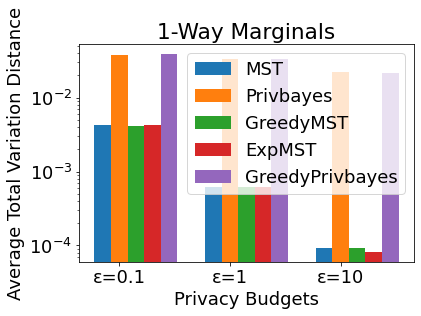

In [22]:
N = 3
workload_len = len(list(itertools.combinations(data.domain, 1)))
ind = np.arange(N) 
width = 0.15
plt.yscale("log")

xvals = [np.mean(div(mst_1_way_var_distance_01,workload_len)), np.mean(div(mst_1_way_var_distance_1,workload_len)), np.mean(div(mst_1_way_var_distance_10,workload_len))]
bar1 = plt.bar(ind, xvals, width)


yvals = [np.mean(div(privbayes_1_way_var_distance_01,workload_len)), np.mean(div(privbayes_1_way_var_distance_1,workload_len)), np.mean(div(privbayes_1_way_var_distance_10,workload_len))]
bar2 = plt.bar(ind+width, yvals, width)
  
zvals = [np.mean(div(fair_greedy_mst_1_way_var_distance_01,workload_len)), np.mean(div(fair_greedy_mst_1_way_var_distance_1,workload_len)), np.mean(div(fair_greedy_mst_1_way_var_distance_10,workload_len))]
bar3 = plt.bar(ind+width*2, zvals, width)

xxvals = [np.mean(div(fair_opt_mst_1_way_var_distance_01,workload_len)), np.mean(div(fair_opt_mst_1_way_var_distance_1,workload_len)), np.mean(div(fair_opt_mst_1_way_var_distance_10,workload_len))]
bar4 = plt.bar(ind+width*3, xxvals, width)

xyvals = [np.mean(div(fair_privbayes_1_way_var_distance_01,workload_len)), np.mean(div(fair_privbayes_1_way_var_distance_1,workload_len)), np.mean(div(fair_privbayes_1_way_var_distance_10,workload_len))]
bar5 = plt.bar(ind+width*4, xyvals, width)
  
plt.xlabel("Privacy Budgets")
plt.ylabel('Average Total Variation Distance')
plt.title("1-Way Marginals")
  
plt.xticks(ind+width,['ε=0.1','ε=1','ε=10'])
plt.legend( (bar1, bar2, bar3, bar4, bar5), ('MST', 'Privbayes', 'GreedyMST', 'ExpMST', "GreedyPrivbayes") )
plt.savefig(artifactspath + '1wayAVG.pdf', bbox_inches='tight')

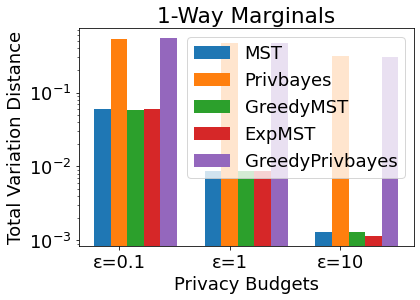

In [23]:
N = 3
workload_len = len(list(itertools.combinations(data.domain, 1)))
ind = np.arange(N) 
width = 0.15
plt.yscale("log")

xvals = [np.mean(mst_1_way_var_distance_01), np.mean(mst_1_way_var_distance_1), np.mean(mst_1_way_var_distance_10)]
bar1 = plt.bar(ind, xvals, width)


yvals = [np.mean(privbayes_1_way_var_distance_01), np.mean(privbayes_1_way_var_distance_1), np.mean(privbayes_1_way_var_distance_10)]
bar2 = plt.bar(ind+width, yvals, width)
  
zvals = [np.mean(fair_greedy_mst_1_way_var_distance_01), np.mean(fair_greedy_mst_1_way_var_distance_1), np.mean(fair_greedy_mst_1_way_var_distance_10)]
bar3 = plt.bar(ind+width*2, zvals, width)

xxvals = [np.mean(fair_opt_mst_1_way_var_distance_01), np.mean(fair_opt_mst_1_way_var_distance_1), np.mean(fair_opt_mst_1_way_var_distance_10)]
bar4 = plt.bar(ind+width*3, xxvals, width)

xyvals = [np.mean(fair_privbayes_1_way_var_distance_01), np.mean(fair_privbayes_1_way_var_distance_1), np.mean(fair_privbayes_1_way_var_distance_10)]
bar5 = plt.bar(ind+width*4, xyvals, width)
  
plt.xlabel("Privacy Budgets")
plt.ylabel('Total Variation Distance')
plt.title("1-Way Marginals")
  
plt.xticks(ind+width,['ε=0.1','ε=1','ε=10'])
plt.legend( (bar1, bar2, bar3, bar4, bar5), ('MST', 'Privbayes', 'GreedyMST', 'ExpMST', "GreedyPrivbayes") )
plt.savefig(artifactspath + '1way.pdf', bbox_inches='tight')

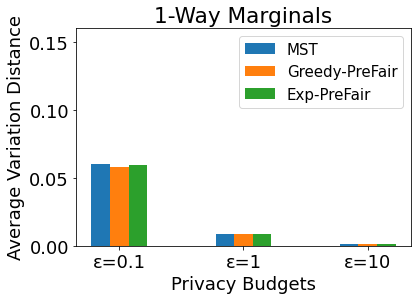

In [24]:
N = 3
workload_len = len(list(itertools.combinations(data.domain, 1)))
ind = np.arange(N) 
width = 0.15
#plt.yscale("log")

xvals = [np.mean(mst_1_way_var_distance_01), np.mean(mst_1_way_var_distance_1), np.mean(mst_1_way_var_distance_10)]
bar1 = plt.bar(ind, xvals, width)

  
zvals = [np.mean(fair_greedy_mst_1_way_var_distance_01), np.mean(fair_greedy_mst_1_way_var_distance_1), np.mean(fair_greedy_mst_1_way_var_distance_10)]
bar3 = plt.bar(ind+width*1, zvals, width)

xxvals = [np.mean(fair_opt_mst_1_way_var_distance_01), np.mean(fair_opt_mst_1_way_var_distance_1), np.mean(fair_opt_mst_1_way_var_distance_10)]
bar4 = plt.bar(ind+width*2, xxvals, width)


  
plt.xlabel("Privacy Budgets")
plt.ylabel('Average Variation Distance')
plt.title("1-Way Marginals")

plt.ylim(0,0.16)
  
plt.xticks(ind+width,['ε=0.1','ε=1','ε=10'])
plt.legend( (bar1,  bar3, bar4), ('MST', 'Greedy-PreFair', 'Exp-PreFair'), fontsize = 15 )
plt.savefig(artifactspath + '1wayMST.pdf', bbox_inches='tight')

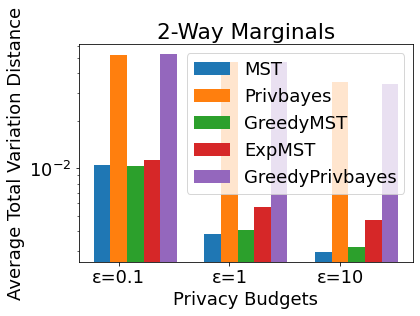

In [25]:
N = 3
workload_len = len(list(itertools.combinations(data.domain, 1)))
ind = np.arange(N) 
width = 0.15
plt.yscale("log")

xvals = [np.mean(div(mst_2_way_var_distance_01,workload_len)), np.mean(div(mst_2_way_var_distance_1,workload_len)), np.mean(div(mst_2_way_var_distance_10,workload_len))]
bar1 = plt.bar(ind, xvals, width)


yvals = [np.mean(div(privbayes_2_way_var_distance_01,workload_len)), np.mean(div(privbayes_2_way_var_distance_1,workload_len)), np.mean(div(privbayes_2_way_var_distance_10,workload_len))]
bar2 = plt.bar(ind+width, yvals, width)
  
zvals = [np.mean(div(fair_greedy_mst_2_way_var_distance_01,workload_len)), np.mean(div(fair_greedy_mst_2_way_var_distance_1,workload_len)), np.mean(div(fair_greedy_mst_2_way_var_distance_10,workload_len))]
bar3 = plt.bar(ind+width*2, zvals, width)

xxvals = [np.mean(div(fair_opt_mst_2_way_var_distance_01,workload_len)), np.mean(div(fair_opt_mst_2_way_var_distance_1,workload_len)), np.mean(div(fair_opt_mst_2_way_var_distance_10,workload_len))]
bar4 = plt.bar(ind+width*3, xxvals, width)

xyvals = [np.mean(div(fair_privbayes_2_way_var_distance_01,workload_len)), np.mean(div(fair_privbayes_2_way_var_distance_1,workload_len)), np.mean(div(fair_privbayes_2_way_var_distance_10,workload_len))]
bar5 = plt.bar(ind+width*4, xyvals, width)
  
plt.xlabel("Privacy Budgets")
plt.ylabel('Average Total Variation Distance')
plt.title("2-Way Marginals")
  
plt.xticks(ind+width,['ε=0.1','ε=1','ε=10'])
plt.legend( (bar1, bar2, bar3, bar4, bar5), ('MST', 'Privbayes', 'GreedyMST', 'ExpMST', "GreedyPrivbayes") )
plt.savefig(artifactspath + '2wayAVG.pdf', bbox_inches='tight')

In [26]:
print(np.mean(fair_greedy_mst_corr_distance_01)/np.mean(mst_corr_distance_01))
print(np.mean(fair_greedy_mst_corr_distance_1)/np.mean(mst_corr_distance_1))
print(np.mean(fair_greedy_mst_corr_distance_10)/np.mean(mst_corr_distance_10))

0.951470047418548
1.030766669266827
1.0130794447020268


In [27]:
print(np.mean(fair_opt_mst_corr_distance_01)/np.mean(mst_corr_distance_01))
print(np.mean(fair_opt_mst_corr_distance_1)/np.mean(mst_corr_distance_1))
print(np.mean(fair_opt_mst_corr_distance_10)/np.mean(mst_corr_distance_10))

0.9954356292254589
1.1842946029295416
1.5346198016130526


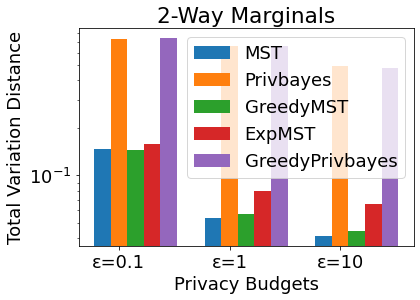

In [28]:
N = 3
workload_len = len(list(itertools.combinations(data.domain, 1)))
ind = np.arange(N) 
width = 0.15
plt.yscale("log")

xvals = [np.mean(mst_2_way_var_distance_01), np.mean(mst_2_way_var_distance_1), np.mean(mst_2_way_var_distance_10)]
bar1 = plt.bar(ind, xvals, width)


yvals = [np.mean(privbayes_2_way_var_distance_01), np.mean(privbayes_2_way_var_distance_1), np.mean(privbayes_2_way_var_distance_10)]
bar2 = plt.bar(ind+width, yvals, width)
  
zvals = [np.mean(fair_greedy_mst_2_way_var_distance_01), np.mean(fair_greedy_mst_2_way_var_distance_1), np.mean(fair_greedy_mst_2_way_var_distance_10)]
bar3 = plt.bar(ind+width*2, zvals, width)

xxvals = [np.mean(fair_opt_mst_2_way_var_distance_01), np.mean(fair_opt_mst_2_way_var_distance_1), np.mean(fair_opt_mst_2_way_var_distance_10)]
bar4 = plt.bar(ind+width*3, xxvals, width)

xyvals = [np.mean(fair_privbayes_2_way_var_distance_01), np.mean(fair_privbayes_2_way_var_distance_1), np.mean(fair_privbayes_2_way_var_distance_10)]
bar5 = plt.bar(ind+width*4, xyvals, width)
  
plt.xlabel("Privacy Budgets")
plt.ylabel('Total Variation Distance')
plt.title("2-Way Marginals")
  
plt.xticks(ind+width,['ε=0.1','ε=1','ε=10'])
plt.legend( (bar1, bar2, bar3, bar4, bar5), ('MST', 'Privbayes', 'GreedyMST', 'ExpMST', "GreedyPrivbayes") )
plt.savefig(artifactspath + '2way.pdf', bbox_inches='tight')

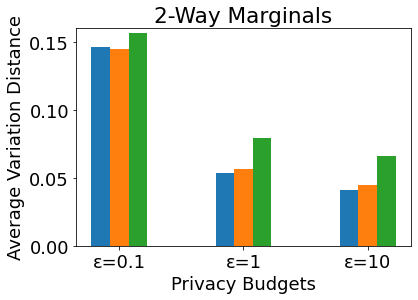

In [29]:
N = 3
workload_len = len(list(itertools.combinations(data.domain, 1)))
ind = np.arange(N) 
width = 0.15
#plt.yscale("log")

xvals = [np.mean(mst_2_way_var_distance_01), np.mean(mst_2_way_var_distance_1), np.mean(mst_2_way_var_distance_10)]
bar1 = plt.bar(ind, xvals, width)

zvals = [np.mean(fair_greedy_mst_2_way_var_distance_01), np.mean(fair_greedy_mst_2_way_var_distance_1), np.mean(fair_greedy_mst_2_way_var_distance_10)]
bar3 = plt.bar(ind+width*1, zvals, width)

xxvals = [np.mean(fair_opt_mst_2_way_var_distance_01), np.mean(fair_opt_mst_2_way_var_distance_1), np.mean(fair_opt_mst_2_way_var_distance_10)]
bar4 = plt.bar(ind+width*2, xxvals, width)
  
plt.xlabel("Privacy Budgets")
plt.ylabel('Average Variation Distance')
plt.title("2-Way Marginals")
plt.ylim(0,0.16)
plt.xticks(ind+width,['ε=0.1','ε=1','ε=10'])
#plt.legend( (bar1,  bar3, bar4), ('MST', 'GreedyMST', 'ExpMST') )
plt.savefig(artifactspath + '2wayMST.pdf', bbox_inches='tight')

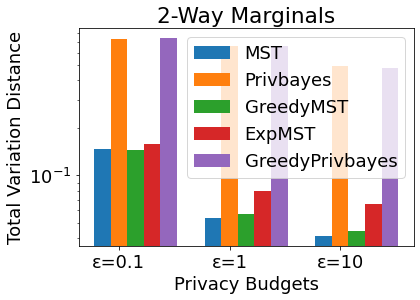

In [30]:
N = 3
workload_len = len(list(itertools.combinations(data.domain, 1)))
ind = np.arange(N) 
width = 0.15
plt.yscale("log")

xvals = [np.mean(mst_2_way_var_distance_01), np.mean(mst_2_way_var_distance_1), np.mean(mst_2_way_var_distance_10)]
bar1 = plt.bar(ind, xvals, width)


yvals = [np.mean(privbayes_2_way_var_distance_01), np.mean(privbayes_2_way_var_distance_1), np.mean(privbayes_2_way_var_distance_10)]
bar2 = plt.bar(ind+width, yvals, width)
  
zvals = [np.mean(fair_greedy_mst_2_way_var_distance_01), np.mean(fair_greedy_mst_2_way_var_distance_1), np.mean(fair_greedy_mst_2_way_var_distance_10)]
bar3 = plt.bar(ind+width*2, zvals, width)

xxvals = [np.mean(fair_opt_mst_2_way_var_distance_01), np.mean(fair_opt_mst_2_way_var_distance_1), np.mean(fair_opt_mst_2_way_var_distance_10)]
bar4 = plt.bar(ind+width*3, xxvals, width)

xyvals = [np.mean(fair_privbayes_2_way_var_distance_01), np.mean(fair_privbayes_2_way_var_distance_1), np.mean(fair_privbayes_2_way_var_distance_10)]
bar5 = plt.bar(ind+width*4, xyvals, width)
  
plt.xlabel("Privacy Budgets")
plt.ylabel('Total Variation Distance')
plt.title("2-Way Marginals")
  
plt.xticks(ind+width,['ε=0.1','ε=1','ε=10'])
plt.legend( (bar1, bar2, bar3, bar4, bar5), ('MST', 'Privbayes', 'GreedyMST', 'ExpMST', "GreedyPrivbayes") )
plt.savefig(artifactspath + '2way.pdf', bbox_inches='tight')

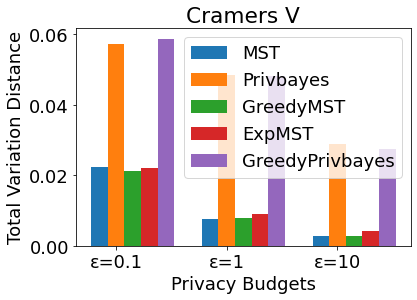

In [31]:
N = 3
workload_len = len(list(itertools.combinations(data.domain, 1)))
ind = np.arange(N) 
width = 0.15
#plt.yscale("log")

xvals = [np.mean(mst_corr_distance_01), np.mean(mst_corr_distance_1), np.mean(mst_corr_distance_10)]
bar1 = plt.bar(ind, xvals, width)


yvals = [np.mean(privbayes_corr_distance_01), np.mean(privbayes_corr_distance_1), np.mean(privbayes_corr_distance_10)]
bar2 = plt.bar(ind+width, yvals, width)
  
zvals = [np.mean(fair_greedy_mst_corr_distance_01), np.mean(fair_greedy_mst_corr_distance_1), np.mean(fair_greedy_mst_corr_distance_10)]
bar3 = plt.bar(ind+width*2, zvals, width)

xxvals = [np.mean(fair_opt_mst_corr_distance_01), np.mean(fair_opt_mst_corr_distance_1), np.mean(fair_opt_mst_corr_distance_10)]
bar4 = plt.bar(ind+width*3, xxvals, width)

xyvals = [np.mean(fair_privbayes_corr_distance_01), np.mean(fair_privbayes_corr_distance_1), np.mean(fair_privbayes_corr_distance_10)]
bar5 = plt.bar(ind+width*4, xyvals, width)
  
plt.xlabel("Privacy Budgets")
plt.ylabel('Total Variation Distance')
plt.title("Cramers V")
  
plt.xticks(ind+width,['ε=0.1','ε=1','ε=10'])
plt.legend( (bar1, bar2, bar3, bar4, bar5), ('MST', 'Privbayes', 'GreedyMST', 'ExpMST', "GreedyPrivbayes") )
plt.savefig(artifactspath + 'corr.pdf', bbox_inches='tight')

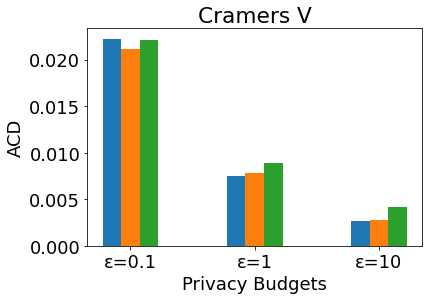

In [151]:
N = 3
workload_len = len(list(itertools.combinations(data.domain, 1)))
ind = np.arange(N) 
width = 0.15
#plt.yscale("log")

xvals = [np.mean(mst_corr_distance_01), np.mean(mst_corr_distance_1), np.mean(mst_corr_distance_10)]
bar1 = plt.bar(ind, xvals, width)

zvals = [np.mean(fair_greedy_mst_corr_distance_01), np.mean(fair_greedy_mst_corr_distance_1), np.mean(fair_greedy_mst_corr_distance_10)]
bar3 = plt.bar(ind+width*1, zvals, width)

xxvals = [np.mean(fair_opt_mst_corr_distance_01), np.mean(fair_opt_mst_corr_distance_1), np.mean(fair_opt_mst_corr_distance_10)]
bar4 = plt.bar(ind+width*2, xxvals, width)

  
plt.xlabel("Privacy Budgets")
plt.ylabel('ACD')
plt.title("Cramers V")
  
plt.xticks(ind+width,['ε=0.1','ε=1','ε=10'])
#plt.legend( (bar1, bar3, bar4), ('MST', 'GreedyMST', 'ExpMST') )
plt.savefig(artifactspath + 'corrMST.pdf', bbox_inches='tight')

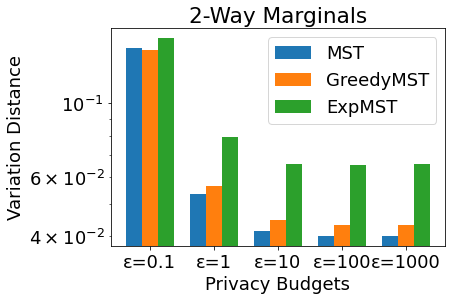

In [33]:
N = 5
ind = np.arange(N) 
width = 0.25
plt.yscale("log")
xvals = [np.mean(mst_2_way_var_distance_01), np.mean(mst_2_way_var_distance_1), np.mean(mst_2_way_var_distance_10),np.mean(mst_2_way_var_distance_100),np.mean(mst_2_way_var_distance_1000)]
bar1 = plt.bar(ind, xvals, width)


yvals = [np.mean(fair_greedy_mst_2_way_var_distance_01), np.mean(fair_greedy_mst_2_way_var_distance_1), np.mean(fair_greedy_mst_2_way_var_distance_10),np.mean(fair_greedy_mst_2_way_var_distance_100),np.mean(fair_greedy_mst_2_way_var_distance_1000)]
bar2 = plt.bar(ind+width, yvals, width)
  
zvals = [np.mean(fair_opt_mst_2_way_var_distance_01), np.mean(fair_opt_mst_2_way_var_distance_1), np.mean(fair_opt_mst_2_way_var_distance_10),np.mean(fair_opt_mst_2_way_var_distance_100),np.mean(fair_opt_mst_2_way_var_distance_1000)]
bar3 = plt.bar(ind+width*2, zvals, width)
  
plt.xlabel("Privacy Budgets")
plt.ylabel('Variation Distance')
plt.title("2-Way Marginals")
  
plt.xticks(ind+width,['ε=0.1','ε=1','ε=10','ε=100','ε=1000'])
plt.legend( (bar1, bar2, bar3), ('MST', 'GreedyMST', 'ExpMST') )
plt.savefig(artifactspath + '2wayall5.pdf', bbox_inches='tight')

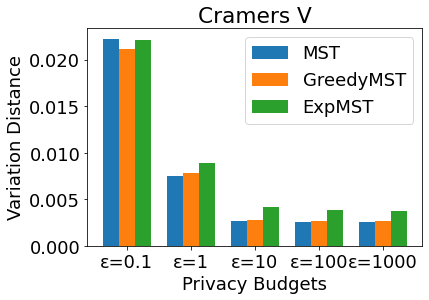

In [34]:
N = 5
ind = np.arange(N) 
width = 0.25
#plt.yscale("log")
xvals = [np.mean(mst_corr_distance_01), np.mean(mst_corr_distance_1), np.mean(mst_corr_distance_10),np.mean(mst_corr_distance_100),np.mean(mst_corr_distance_1000)]
bar1 = plt.bar(ind, xvals, width)


yvals = [np.mean(fair_greedy_mst_corr_distance_01), np.mean(fair_greedy_mst_corr_distance_1), np.mean(fair_greedy_mst_corr_distance_10),np.mean(fair_greedy_mst_corr_distance_100),np.mean(fair_greedy_mst_corr_distance_1000)]
bar2 = plt.bar(ind+width, yvals, width)
  
zvals = [np.mean(fair_opt_mst_corr_distance_01), np.mean(fair_opt_mst_corr_distance_1), np.mean(fair_opt_mst_corr_distance_10),np.mean(fair_opt_mst_corr_distance_100),np.mean(fair_opt_mst_corr_distance_1000)]
bar3 = plt.bar(ind+width*2, zvals, width)
  
plt.xlabel("Privacy Budgets")
plt.ylabel('Variation Distance')
plt.title("Cramers V")
  
plt.xticks(ind+width,['ε=0.1','ε=1','ε=10','ε=100','ε=1000'])
plt.legend( (bar1, bar2, bar3), ('MST', 'GreedyMST', 'ExpMST') )
plt.savefig(artifactspath + 'corrall5.pdf', bbox_inches='tight')

## 1-Way Marginals

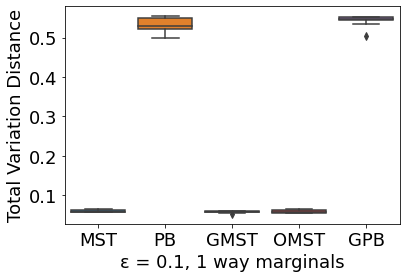

In [35]:

x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_1_way_var_distance_01,privbayes_1_way_var_distance_01,fair_greedy_mst_1_way_var_distance_01,fair_opt_mst_1_way_var_distance_01,fair_privbayes_1_way_var_distance_01]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 0.1, 1 way marginals")
plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + '1_way_01.pdf', bbox_inches='tight')


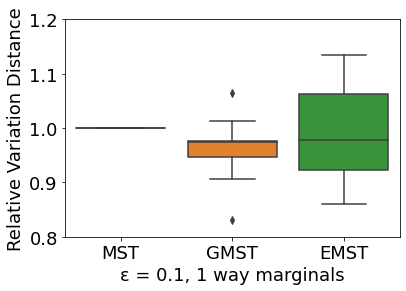

In [36]:

x=[0,1,2]
x_axis = ["MST", "GMST","EMST"]

for i in range(len(mst_1_way_var_distance_01)):
    fair_greedy_mst_1_way_var_distance_01[i]= fair_greedy_mst_1_way_var_distance_01[i]/mst_1_way_var_distance_01[i]
    fair_opt_mst_1_way_var_distance_01[i]= fair_opt_mst_1_way_var_distance_01[i]/mst_1_way_var_distance_01[i]
    mst_1_way_var_distance_01[i]= mst_1_way_var_distance_01[i]/mst_1_way_var_distance_01[i]
    
    
values = [mst_1_way_var_distance_01,fair_greedy_mst_1_way_var_distance_01,fair_opt_mst_1_way_var_distance_01]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)
ax.set_ylim([0.8, 1.2])

plt.xticks(x,x_axis)
plt.xlabel("ε = 0.1, 1 way marginals")
plt.ylabel("Relative Variation Distance")
plt.savefig(artifactspath + '1_way_01_MST.pdf', bbox_inches='tight')


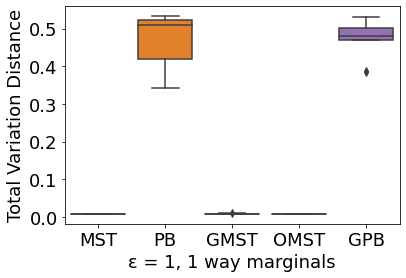

In [37]:

x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_1_way_var_distance_1,privbayes_1_way_var_distance_1,fair_greedy_mst_1_way_var_distance_1,fair_opt_mst_1_way_var_distance_1,fair_privbayes_1_way_var_distance_1]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 1, 1 way marginals")
plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + '1_way_1.pdf', bbox_inches='tight')


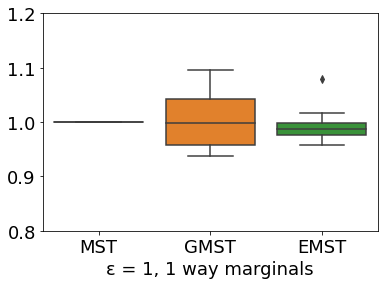

In [38]:

x=[0,1,2]
x_axis = ["MST", "GMST","EMST"]
values = [mst_1_way_var_distance_1,fair_greedy_mst_1_way_var_distance_1,fair_opt_mst_1_way_var_distance_1]

for i in range(len(mst_1_way_var_distance_1)):
    fair_greedy_mst_1_way_var_distance_1[i]= fair_greedy_mst_1_way_var_distance_1[i]/mst_1_way_var_distance_1[i]
    fair_opt_mst_1_way_var_distance_1[i]= fair_opt_mst_1_way_var_distance_1[i]/mst_1_way_var_distance_1[i]
    mst_1_way_var_distance_1[i]= mst_1_way_var_distance_1[i]/mst_1_way_var_distance_1[i]

#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)
ax.set_ylim([0.8, 1.2])

plt.xticks(x,x_axis)
plt.xlabel("ε = 1, 1 way marginals")
#plt.ylabel("Relative Variation Distance")
plt.savefig(artifactspath + '1_way_1_MST.pdf', bbox_inches='tight')


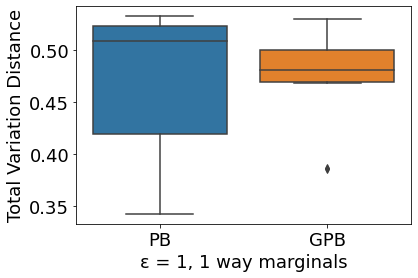

In [39]:

x=[0,1,]
x_axis = ["PB", "GPB"]
values = [privbayes_1_way_var_distance_1,fair_privbayes_1_way_var_distance_1]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 1, 1 way marginals")
plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + '1_way_1_PB.pdf', bbox_inches='tight')


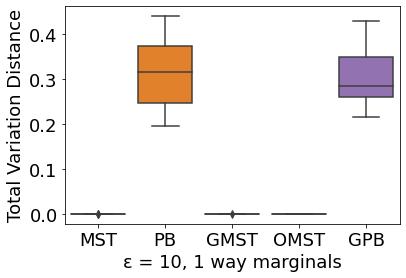

In [40]:

x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_1_way_var_distance_10,privbayes_1_way_var_distance_10,fair_greedy_mst_1_way_var_distance_10,fair_opt_mst_1_way_var_distance_10,fair_privbayes_1_way_var_distance_10]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 10, 1 way marginals")
plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + '1_way_10.pdf', bbox_inches='tight')


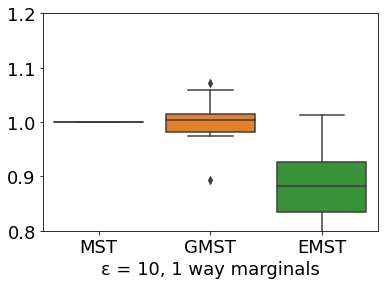

In [41]:

x=[0,1,2]
x_axis = ["MST", "GMST","EMST"]
values = [mst_1_way_var_distance_10,fair_greedy_mst_1_way_var_distance_10,fair_opt_mst_1_way_var_distance_10]


for i in range(len(mst_1_way_var_distance_10)):
    fair_greedy_mst_1_way_var_distance_10[i]= fair_greedy_mst_1_way_var_distance_10[i]/mst_1_way_var_distance_10[i]
    fair_opt_mst_1_way_var_distance_10[i]= fair_opt_mst_1_way_var_distance_10[i]/mst_1_way_var_distance_10[i]
    mst_1_way_var_distance_10[i]= mst_1_way_var_distance_10[i]/mst_1_way_var_distance_10[i]

#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)
ax.set_ylim([0.8, 1.2])

plt.xticks(x,x_axis)
plt.xlabel("ε = 10, 1 way marginals")
#plt.ylabel("Relative Variation Distance")
plt.savefig(artifactspath + '1_way_10_MST.pdf', bbox_inches='tight')


## 2-way Marginals

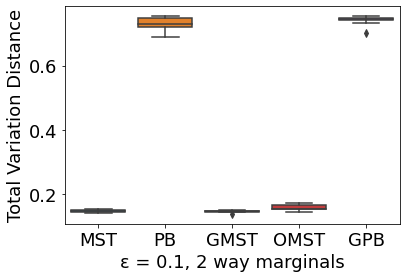

In [42]:

x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_2_way_var_distance_01,privbayes_2_way_var_distance_01,fair_greedy_mst_2_way_var_distance_01,fair_opt_mst_2_way_var_distance_01,fair_privbayes_2_way_var_distance_01]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 0.1, 2 way marginals")
plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + '2_way_01.pdf', bbox_inches='tight')


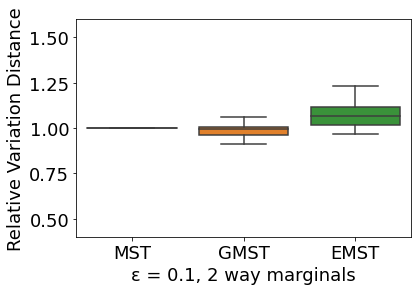

In [43]:

x=[0,1,2]
x_axis = ["MST","GMST","EMST"]
values = [mst_2_way_var_distance_01,fair_greedy_mst_2_way_var_distance_01,fair_opt_mst_2_way_var_distance_01]
for i in range(len(mst_2_way_var_distance_01)):
    fair_greedy_mst_2_way_var_distance_01[i]= fair_greedy_mst_2_way_var_distance_01[i]/mst_2_way_var_distance_01[i]
    fair_opt_mst_2_way_var_distance_01[i]= fair_opt_mst_2_way_var_distance_01[i]/mst_2_way_var_distance_01[i]
    mst_2_way_var_distance_01[i]= mst_2_way_var_distance_01[i]/mst_2_way_var_distance_01[i]

#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)
ax.set_ylim([0.4, 1.6])


plt.xticks(x,x_axis)
plt.xlabel("ε = 0.1, 2 way marginals")
plt.ylabel("Relative Variation Distance")
plt.savefig(artifactspath + '2_way_01_MST.pdf', bbox_inches='tight')


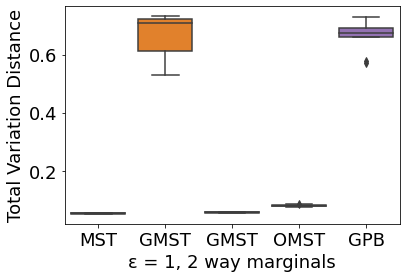

In [44]:

x=[0,1,2,3,4]
x_axis = ["MST","GMST", "GMST","OMST", "GPB"]
values = [mst_2_way_var_distance_1,privbayes_2_way_var_distance_1,fair_greedy_mst_2_way_var_distance_1,fair_opt_mst_2_way_var_distance_1,fair_privbayes_2_way_var_distance_1]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 1, 2 way marginals")
plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + '2_way_1.pdf', bbox_inches='tight')


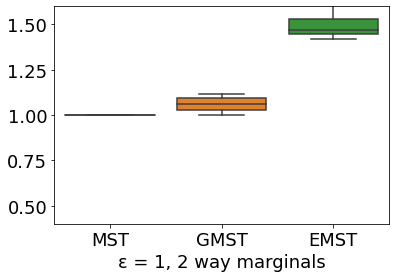

In [45]:

x=[0,1,2]
x_axis = ["MST","GMST","EMST"]
values = [mst_2_way_var_distance_1,fair_greedy_mst_2_way_var_distance_1,fair_opt_mst_2_way_var_distance_1]
for i in range(len(mst_2_way_var_distance_1)):
    fair_greedy_mst_2_way_var_distance_1[i]= fair_greedy_mst_2_way_var_distance_1[i]/mst_2_way_var_distance_1[i]
    fair_opt_mst_2_way_var_distance_1[i]= fair_opt_mst_2_way_var_distance_1[i]/mst_2_way_var_distance_1[i]
    mst_2_way_var_distance_1[i]= mst_2_way_var_distance_1[i]/mst_2_way_var_distance_1[i]

#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)
ax.set_ylim([0.4, 1.6])

plt.xticks(x,x_axis)
plt.xlabel("ε = 1, 2 way marginals")
#plt.ylabel("Relative Variation Distance")
plt.savefig(artifactspath + '2_way_1_MST.pdf', bbox_inches='tight')


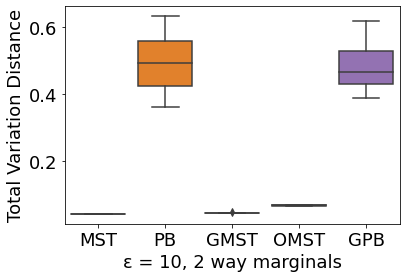

In [46]:

x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_2_way_var_distance_10,privbayes_2_way_var_distance_10,fair_greedy_mst_2_way_var_distance_10,fair_opt_mst_2_way_var_distance_10,fair_privbayes_2_way_var_distance_10]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 10, 2 way marginals")
plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + '2_way_10.pdf', bbox_inches='tight')


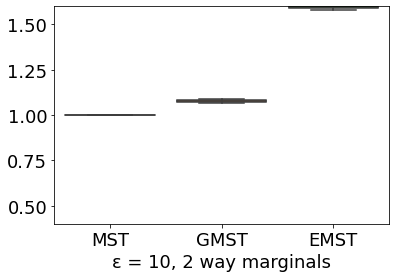

In [47]:

x=[0,1,2]
x_axis = ["MST","GMST","EMST"]
values = [mst_2_way_var_distance_10,fair_greedy_mst_2_way_var_distance_10,fair_opt_mst_2_way_var_distance_10]
for i in range(len(mst_2_way_var_distance_10)):
    fair_greedy_mst_2_way_var_distance_10[i]= fair_greedy_mst_2_way_var_distance_10[i]/mst_2_way_var_distance_10[i]
    fair_opt_mst_2_way_var_distance_10[i]= fair_opt_mst_2_way_var_distance_10[i]/mst_2_way_var_distance_10[i]
    mst_2_way_var_distance_10[i]= mst_2_way_var_distance_10[i]/mst_2_way_var_distance_10[i]

#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)
ax.set_ylim([0.4, 1.6])

plt.xticks(x,x_axis)
plt.xlabel("ε = 10, 2 way marginals")
#plt.ylabel("Relative Variation Distance")
plt.savefig(artifactspath + '2_way_10_MST.pdf', bbox_inches='tight')


## Correlation Error

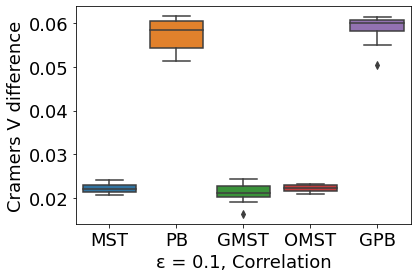

In [48]:
x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_corr_distance_01,privbayes_corr_distance_01,fair_greedy_mst_corr_distance_01,fair_opt_mst_corr_distance_01,fair_privbayes_corr_distance_01]



#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 0.1, Correlation")
plt.ylabel("Cramers V difference")
plt.savefig(artifactspath + 'corr_01.pdf', bbox_inches='tight')


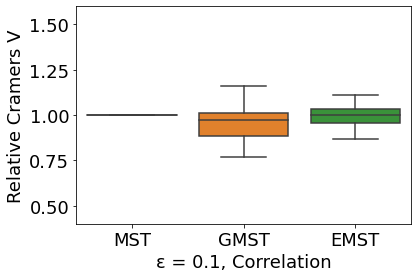

In [49]:
x=[0,1,2]
x_axis = ["MST", "GMST","EMST",]
values = [mst_corr_distance_01,fair_greedy_mst_corr_distance_01,fair_opt_mst_corr_distance_01]

for i in range(len(mst_corr_distance_01)):
    fair_greedy_mst_corr_distance_01[i]= fair_greedy_mst_corr_distance_01[i]/mst_corr_distance_01[i]
    fair_opt_mst_corr_distance_01[i]= fair_opt_mst_corr_distance_01[i]/mst_corr_distance_01[i]
    mst_corr_distance_01[i]= mst_corr_distance_01[i]/mst_corr_distance_01[i]

#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)
ax.set_ylim([0.4, 1.6])

plt.xticks(x,x_axis)
plt.xlabel("ε = 0.1, Correlation")
plt.ylabel("Relative Cramers V")
plt.savefig(artifactspath + 'corr_01_MST.pdf', bbox_inches='tight')


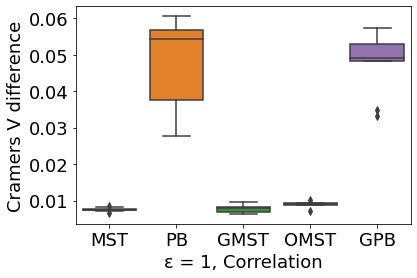

In [50]:
x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_corr_distance_1,privbayes_corr_distance_1,fair_greedy_mst_corr_distance_1,fair_opt_mst_corr_distance_1,fair_privbayes_corr_distance_1]

#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 1, Correlation")
plt.ylabel("Cramers V difference")
plt.savefig(artifactspath + 'corr_1.pdf', bbox_inches='tight')


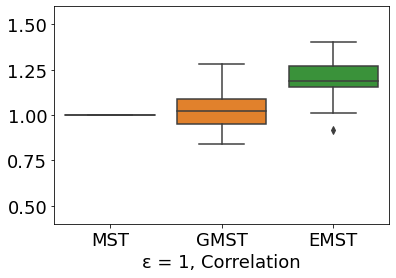

In [51]:
x=[0,1,2]
x_axis = ["MST", "GMST","EMST",]
values = [mst_corr_distance_1,fair_greedy_mst_corr_distance_1,fair_opt_mst_corr_distance_1]
for i in range(len(mst_corr_distance_1)):
    fair_greedy_mst_corr_distance_1[i]= fair_greedy_mst_corr_distance_1[i]/mst_corr_distance_1[i]
    fair_opt_mst_corr_distance_1[i]= fair_opt_mst_corr_distance_1[i]/mst_corr_distance_1[i]
    mst_corr_distance_1[i]= mst_corr_distance_1[i]/mst_corr_distance_1[i]
#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)
ax.set_ylim([0.4, 1.6])

plt.xticks(x,x_axis)
plt.xlabel("ε = 1, Correlation")
#plt.ylabel("Relative Cramers V")
plt.savefig(artifactspath + 'corr_1_MST.pdf', bbox_inches='tight')


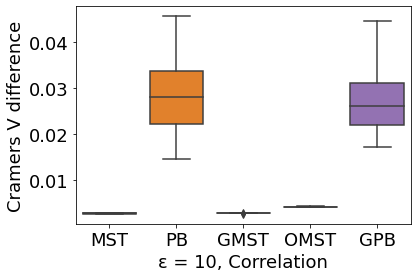

In [52]:
x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_corr_distance_10,privbayes_corr_distance_10,fair_greedy_mst_corr_distance_10,fair_opt_mst_corr_distance_10,fair_privbayes_corr_distance_10]

#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 10, Correlation")
plt.ylabel("Cramers V difference")
plt.savefig(artifactspath + 'corr_10.pdf', bbox_inches='tight')


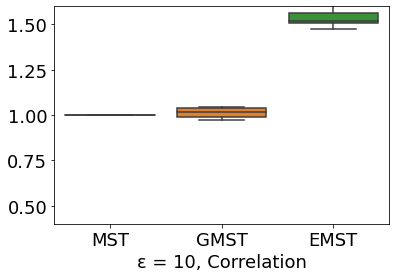

In [53]:
x=[0,1,2]
x_axis = ["MST", "GMST","EMST",]
values = [mst_corr_distance_10,fair_greedy_mst_corr_distance_10,fair_opt_mst_corr_distance_10]

for i in range(len(mst_corr_distance_10)):
    fair_greedy_mst_corr_distance_10[i]= fair_greedy_mst_corr_distance_10[i]/mst_corr_distance_10[i]
    fair_opt_mst_corr_distance_10[i]= fair_opt_mst_corr_distance_10[i]/mst_corr_distance_10[i]
    mst_corr_distance_10[i]= mst_corr_distance_10[i]/mst_corr_distance_10[i]
#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)
ax.set_ylim([0.4, 1.6])

plt.xticks(x,x_axis)
plt.xlabel("ε = 10, Correlation")
#plt.ylabel("Relative Cramers V")
plt.savefig(artifactspath + 'corr_10_MST.pdf', bbox_inches='tight')


# Fairness Metrics 

In [54]:

SHUFFLE_BUFFER = 500
BATCH_SIZE = 50


In [55]:
def mlp_test(path):
    #eps = 0.1 MST
    accuracy_vals = []
    accuracy_parity_vals = []
    demographic_parity_vals = []
    TPRBalance_vals = []
    TNRBalance_vals =[]
    conditional_demographic_parity_vals = []
    conditional_TPRBalance_vals = []
    conditional_TNRBalance_vals =[]

    for i in range(10):
        # training models on greedy_fair_mst
        testpath = "data/adult.csv"
        test = pd.read_csv(testpath)
        test_sex0 = copy.copy(test).loc[test['sex'] == 0]
        test_sex1 = copy.copy(test).loc[test['sex'] == 1]
        test_lables = test.pop('income>50K')
        test_sex0_lables = test_sex0.pop('income>50K')
        test_sex1_lables = test_sex1.pop('income>50K')
        #tf.convert_to_tensor(test)


        trainpath = f'{path}{i}.csv'
        train = pd.read_csv(trainpath)
        train_lables = train.pop('income>50K')
        tf.convert_to_tensor(train)


        model = Sequential()
        model.add(Dense(20, activation='relu', kernel_initializer='he_normal'))
        model.add(Dense(20, activation='relu', kernel_initializer='he_normal'))
        model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
        model.add(Dense(5, activation='relu', kernel_initializer='he_normal'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        model.fit(train, train_lables, epochs=20, batch_size=BATCH_SIZE, verbose=0)
        #model.fit(train, train_lables, epochs=10, batch_size=BATCH_SIZE)

        predictions = model.predict(test)
        loss = model.evaluate(test, test_lables, verbose=0)
        accuracy = loss[1]
        accuracy_vals.append(accuracy)
        sex0_accuracy = model.evaluate(test_sex0, test_sex0_lables, verbose=0)[1]
        sex1_accuracy = model.evaluate(test_sex1, test_sex1_lables, verbose=0)[1]
        accuracy_parity_vals.append(abs(sex1_accuracy-sex0_accuracy))

        test['Income'] = test_lables
        test['Predicted'] = predictions
        test = test.round({'Predicted': 0})
        test["Predicted"]=test["Predicted"].astype(int)

        sex1 = test.loc[test['sex'] == 1]
        sex0 = test.loc[test['sex'] == 0]
        sex1_count = len(sex1.index)
        sex0_count = len(sex0.index)
        demographic_parity = abs((sex1['Predicted'].sum()/sex1_count) -(sex0['Predicted'].sum()/sex0_count))
        demographic_parity_vals.append(demographic_parity)

        sex1TPR = len(sex1.loc[(sex1['Income'] == 1) & (sex1['Predicted'] == 1)].index)/len(sex1.loc[(sex1['Income'] == 1)].index)
        sex0TPR = len(sex0.loc[(sex0['Income'] == 1) & (sex0['Predicted'] == 1)].index)/len(sex0.loc[(sex0['Income'] == 1)].index) 
        TPRBalance = abs(sex1TPR - sex0TPR)
        TPRBalance_vals.append(TPRBalance)

        sex1TNR = len(sex1.loc[(sex1['Income'] == 0) & (sex1['Predicted'] == 0)].index)/len(sex1.loc[(sex1['Income'] == 0)].index)
        sex0TNR = len(sex0.loc[(sex0['Income'] == 0) & (sex0['Predicted'] == 0)].index)/len(sex0.loc[(sex0['Income'] == 0)].index) 
        TNRBalance = abs(sex1TNR - sex0TNR)
        TNRBalance_vals.append(TNRBalance)


        admis_group = test.groupby(admissible, sort = False)
        test['S0TP'] = (test['Predicted'] == 1) & (test['Income'] == 1) & (test['sex'] == 0) 
        test['S0TN'] = (test['Predicted'] == 0) & (test['Income'] == 0)  & (test['sex'] == 0) 
        test['S0Pos'] = (test['Income'] == 1)  & (test['sex'] == 0) 
        test['S0Neg'] = (test['Income'] == 0)  & (test['sex'] == 0) 
        test['S0pred_pos'] = (test['Predicted'] == 1) & (test['sex'] == 0) 
        test['S0count'] = (test['sex'] == 0)
        test['S1TP'] = (test['Predicted'] == 1) & (test['Income'] == 1) & (test['sex'] == 1) 
        test['S1TN'] = (test['Predicted'] == 0) & (test['Income'] == 0)  & (test['sex'] == 1) 
        test['S1Pos'] = (test['Income'] == 1)  & (test['sex'] == 1) 
        test['S1Neg'] = (test['Income'] == 0)  & (test['sex'] == 1) 
        test['S1pred_pos'] = (test['Predicted'] == 1) & (test['sex'] == 1) 
        test['S1count'] = (test['sex'] == 1)


        tp0 = admis_group['S0TP'].sum()
        pos0 = admis_group['S0Pos'].sum()
        tn0 = admis_group['S0TN'].sum()
        neg0 = admis_group['S0Neg'].sum()
        pred_pos0 = admis_group['S0pred_pos'].sum()
        counts0 = admis_group['S0count'].sum()

        sex0_group_tpr = (tp0/pos0)
        sex0_group_tpr = sex0_group_tpr.values
        sex0_group_tpr = sex0_group_tpr[~np.isnan(sex0_group_tpr)]

        sex0_group_tnr = (tn0/neg0)
        sex0_group_tnr =sex0_group_tnr.values
        sex0_group_tnr = sex0_group_tnr[~np.isnan(sex0_group_tnr)]

        sex0_group_dp = (pred_pos0/counts0)
        sex0_group_dp =sex0_group_dp.values
        sex0_group_dp = sex0_group_dp[~np.isnan(sex0_group_dp)]


        tp1 = admis_group['S1TP'].sum()
        pos1 = admis_group['S1Pos'].sum()
        tn1 = admis_group['S1TN'].sum()
        neg1 = admis_group['S1Neg'].sum()
        pred_pos1 = admis_group['S1pred_pos'].sum()
        counts1 = admis_group['S1count'].sum()

        sex1_group_tpr = (tp1/pos1)
        sex1_group_tpr = sex1_group_tpr.values
        sex1_group_tpr = sex1_group_tpr[~np.isnan(sex1_group_tpr)]

        sex1_group_tnr = (tn1/neg1)
        sex1_group_tnr =sex1_group_tnr.values
        sex1_group_tnr = sex1_group_tnr[~np.isnan(sex1_group_tnr)]

        sex1_group_dp = (pred_pos1/counts1)
        sex1_group_dp =sex1_group_dp.values
        sex1_group_dp = sex1_group_dp[~np.isnan(sex1_group_dp)]


        conditional_demographic_parity_vals.append(abs(np.mean(sex1_group_dp)-np.mean(sex0_group_dp)))
        conditional_TPRBalance_vals.append(abs(np.mean(sex1_group_tpr)-np.mean(sex0_group_tpr)))
        conditional_TNRBalance_vals.append(abs(np.mean(sex1_group_tnr)-np.mean(sex0_group_tnr)))


    print("Average Accuracy: " + str(np.mean(accuracy_vals)))
    print("Average Accuracy Parity: " + str(np.mean(accuracy_parity_vals)))
    print("Average Demographic Parity: " + str(np.mean(demographic_parity_vals)))
    print("Average TPR Balance: " + str(np.mean(TPRBalance_vals)))
    print("Average TNR Balance: " + str(np.mean(TNRBalance_vals)))

    print("Average Conditional Demographic Parity: " + str(np.mean(conditional_demographic_parity_vals)))
    print("Average Conditional TPR Balance: " + str(np.mean(conditional_TPRBalance_vals)))
    print("Average Conditional TNR Balance: " + str(np.mean(conditional_TNRBalance_vals)))

    return((accuracy_vals,accuracy_parity_vals,demographic_parity_vals,TPRBalance_vals,TNRBalance_vals,conditional_demographic_parity_vals,conditional_TPRBalance_vals,conditional_TNRBalance_vals))

In [56]:
#eps = 0.1 MST

path = 'data/original/eps=0.1/results_original_'
vals = mlp_test(path)
mst_accuracy_01 = vals[0]
mst_accuracy_parity_01 = vals[1]
mst_demographic_parity_01 = vals[2]
mst_TPRBalance_01 = vals[3]
mst_TNRBalance_01 =vals[4]
mst_conditional_demographic_parity_01 = vals[5]
mst_conditional_TPRBalance_01 = vals[6]
mst_conditional_TNRBalance_01 =vals[7]

#eps = 1 MST
path = 'data/original/eps=1/results_original_'
vals = mlp_test(path)
mst_accuracy_1 = vals[0]
mst_accuracy_parity_1 = vals[1]
mst_demographic_parity_1 = vals[2]
mst_TPRBalance_1 = vals[3]
mst_TNRBalance_1 =vals[4]
mst_conditional_demographic_parity_1 = vals[5]
mst_conditional_TPRBalance_1 = vals[6]
mst_conditional_TNRBalance_1 =vals[7]

#eps = 10 MST
path = 'data/original/eps=10/results_original_'
vals = mlp_test(path)
mst_accuracy_10 = vals[0]
mst_accuracy_parity_10 = vals[1]
mst_demographic_parity_10 = vals[2]
mst_TPRBalance_10 = vals[3]
mst_TNRBalance_10 =vals[4]

mst_conditional_demographic_parity_10 = vals[5]
mst_conditional_TPRBalance_10 = vals[6]
mst_conditional_TNRBalance_10 =vals[7]

#eps = 100 MST
path = 'data/original/eps=100/results_original_'
vals = mlp_test(path)
mst_accuracy_100 = vals[0]
mst_accuracy_parity_100 = vals[1]
mst_demographic_parity_100 = vals[2]
mst_TPRBalance_100 = vals[3]
mst_TNRBalance_100 =vals[4]

mst_conditional_demographic_parity_100 = vals[5]
mst_conditional_TPRBalance_100 = vals[6]
mst_conditional_TNRBalance_100 =vals[7]


#eps = 1000 MST
path = 'data/original/eps=1000/results_original_'
vals = mlp_test(path)
mst_accuracy_1000 = vals[0]
mst_accuracy_parity_1000 = vals[1]
mst_demographic_parity_10 = vals[2]
mst_TPRBalance_1000 = vals[3]
mst_TNRBalance_1000 =vals[4]

mst_conditional_demographic_parity_1000 = vals[5]
mst_conditional_TPRBalance_1000 = vals[6]
mst_conditional_TNRBalance_1000 =vals[7]

1527/1527 [==============================] - 1s 921us/step
Average Accuracy: 0.7611707210540771
Average Accuracy Parity: 0.19247151613235475
Average Demographic Parity: 0.006146050608623016
Average TPR Balance: 0.046840320133289697
Average TNR Balance: 0.0029366648029243493
Average Conditional Demographic Parity: 0.0036225485985255353
Average Conditional TPR Balance: 0.04378897618965304
Average Conditional TNR Balance: 0.0011103493197117341
1527/1527 [==============================] - 1s 780us/step
Average Accuracy: 0.8024425685405732
Average Accuracy Parity: 0.15980600714683532
Average Demographic Parity: 0.05639459147201424
Average TPR Balance: 0.02639066575426695
Average TNR Balance: 0.017335714839690253
Average Conditional Demographic Parity: 0.08497307490070442
Average Conditional TPR Balance: 0.04012107671224977
Average Conditional TNR Balance: 0.025972836891327455
1527/1527 [==============================] - 1s 662us/step
Average Accuracy: 0.8093976557254792
Average Accuracy Par

In [57]:
#eps = 0.1 fair_greedy_MST
path = 'data/fair_greedy/eps=0.1/results_greedy_'
vals = mlp_test(path)
fair_greedy_mst_accuracy_01 = vals[0]
fair_greedy_mst_accuracy_parity_01 = vals[1]
fair_greedy_mst_demographic_parity_01 = vals[2]
fair_greedy_mst_TPRBalance_01 = vals[3]
fair_greedy_mst_TNRBalance_01 =vals[4]

fair_greedy_mst_conditional_demographic_parity_01 = vals[5]
fair_greedy_mst_conditional_TPRBalance_01 = vals[6]
fair_greedy_mst_conditional_TNRBalance_01 =vals[7]

#eps = 1 fair_greedy_MST
path = 'data/fair_greedy/eps=1/results_greedy_'
vals = mlp_test(path)
fair_greedy_mst_accuracy_1 = vals[0]
fair_greedy_mst_accuracy_parity_1 = vals[1]
fair_greedy_mst_demographic_parity_1 = vals[2]
fair_greedy_mst_TPRBalance_1 = vals[3]
fair_greedy_mst_TNRBalance_1 =vals[4]

fair_greedy_mst_conditional_demographic_parity_1 = vals[5]
fair_greedy_mst_conditional_TPRBalance_1 = vals[6]
fair_greedy_mst_conditional_TNRBalance_1 =vals[7]

#eps = 10 fair_greedy_MST
path = 'data/fair_greedy/eps=10/results_greedy_'
vals = mlp_test(path)
fair_greedy_mst_accuracy_10 = vals[0]
fair_greedy_mst_accuracy_parity_10 = vals[1]
fair_greedy_mst_demographic_parity_10 = vals[2]
fair_greedy_mst_TPRBalance_10 = vals[3]
fair_greedy_mst_TNRBalance_10 =vals[4]

fair_greedy_mst_conditional_demographic_parity_10 = vals[5]
fair_greedy_mst_conditional_TPRBalance_10 = vals[6]
fair_greedy_mst_conditional_TNRBalance_10 =vals[7]

#eps = 100 fair_greedy_MST
path = 'data/fair_greedy/eps=100/results_greedy_'
vals = mlp_test(path)
fair_greedy_mst_accuracy_100 = vals[0]
fair_greedy_mst_accuracy_parity_100 = vals[1]
fair_greedy_mst_demographic_parity_100 = vals[2]
fair_greedy_mst_TPRBalance_100 = vals[3]
fair_greedy_mst_TNRBalance_100 =vals[4]

fair_greedy_mst_conditional_demographic_parity_100 = vals[5]
fair_greedy_mst_conditional_TPRBalance_100 = vals[6]
fair_greedy_mst_conditional_TNRBalance_100 =vals[7]

#eps = 1000 fair_greedy_MST
path = 'data/fair_greedy/eps=1000/results_greedy_'
vals = mlp_test(path)
fair_greedy_mst_accuracy_1000 = vals[0]
fair_greedy_mst_accuracy_parity_1000 = vals[1]
fair_greedy_mst_demographic_parity_1000 = vals[2]
fair_greedy_mst_TPRBalance_1000 = vals[3]
fair_greedy_mst_TNRBalance_1000 =vals[4]

fair_greedy_mst_conditional_demographic_parity_1000 = vals[5]
fair_greedy_mst_conditional_TPRBalance_1000 = vals[6]
fair_greedy_mst_conditional_TNRBalance_1000 =vals[7]

1527/1527 [==============================] - 1s 632us/step
Average Accuracy: 0.7625998079776763
Average Accuracy Parity: 0.18766372799873351
Average Demographic Parity: 0.0052231760224927225
Average TPR Balance: 0.005796713377564884
Average TNR Balance: 0.001219237988320232
Average Conditional Demographic Parity: 0.005952209251951635
Average Conditional TPR Balance: 0.005912281135799964
Average Conditional TNR Balance: 0.0015393597677910487
1527/1527 [==============================] - 1s 786us/step
Average Accuracy: 0.8014946162700654
Average Accuracy Parity: 0.15701123476028442
Average Demographic Parity: 0.036354045103474994
Average TPR Balance: 0.017919398080654812
Average TNR Balance: 0.0017697897427087716
Average Conditional Demographic Parity: 0.055079793240521355
Average Conditional TPR Balance: 0.010347998191207108
Average Conditional TNR Balance: 0.0030398674236770894
1527/1527 [==============================] - 1s 629us/step
Average Accuracy: 0.8087731957435608
Average Accura

In [58]:
#eps = 0.1 privbayes
path = 'data/Bayes_original/eps=0.1/sythetic_data_'
vals = mlp_test(path)

privbayes_accuracy_01 = vals[0]
privbayes_accuracy_parity_01 = vals[1]
privbayes_demographic_parity_01 = vals[2]
privbayes_TPRBalance_01 = vals[3]
privbayes_TNRBalance_01 =vals[4]
privbayes_conditional_demographic_parity_01 = vals[5]
privbayes_conditional_TPRBalance_01 = vals[6]
privbayes_conditional_TNRBalance_01 =vals[7]

#eps = 1 privbayes
path = 'data/Bayes_original/eps=1/sythetic_data_'
vals = mlp_test(path)

privbayes_accuracy_1 = vals[0]
privbayes_accuracy_parity_1 = vals[1]
privbayes_demographic_parity_1 = vals[2]
privbayes_TPRBalance_1 = vals[3]
privbayes_TNRBalance_1 =vals[4]
privbayes_conditional_demographic_parity_1 = vals[5]
privbayes_conditional_TPRBalance_1 = vals[6]
privbayes_conditional_TNRBalance_1 =vals[7]

#eps = 10 privbayes
path = 'data/Bayes_original/eps=10/sythetic_data_'
vals = mlp_test(path)

privbayes_accuracy_10 = vals[0]
privbayes_accuracy_parity_10 = vals[1]
privbayes_demographic_parity_10 = vals[2]
privbayes_TPRBalance_10 = vals[3]
privbayes_TNRBalance_10 =vals[4]
privbayes_conditional_demographic_parity_10 = vals[5]
privbayes_conditional_TPRBalance_10 = vals[6]
privbayes_conditional_TNRBalance_10 =vals[7]

#eps = 100 privbayes
path = 'data/Bayes_original/eps=100/sythetic_data_'
vals = mlp_test(path)

privbayes_accuracy_100 = vals[0]
privbayes_accuracy_parity_100 = vals[1]
privbayes_demographic_parity_100 = vals[2]
privbayes_TPRBalance_100 = vals[3]
privbayes_TNRBalance_100 =vals[4]
privbayes_conditional_demographic_parity_100 = vals[5]
privbayes_conditional_TPRBalance_100 = vals[6]
privbayes_conditional_TNRBalance_100 =vals[7]

#eps = 1000 privbayes
path = 'data/Bayes_original/eps=1000/sythetic_data_'
vals = mlp_test(path)

privbayes_accuracy_1000 = vals[0]
privbayes_accuracy_parity_1000 = vals[1]
privbayes_demographic_parity_1000 = vals[2]
privbayes_TPRBalance_1000 = vals[3]
privbayes_TNRBalance_1000 =vals[4]
privbayes_conditional_demographic_parity_1000 = vals[5]
privbayes_conditional_TPRBalance_1000 = vals[6]
privbayes_conditional_TNRBalance_1000 =vals[7]

1527/1527 [==============================] - 1s 689us/step
Average Accuracy: 0.7580688655376434
Average Accuracy Parity: 0.18534156680107117
Average Demographic Parity: 0.027053573806511754
Average TPR Balance: 0.048634210361025984
Average TNR Balance: 0.016752994223488703
Average Conditional Demographic Parity: 0.028427106801473305
Average Conditional TPR Balance: 0.04422285874636038
Average Conditional TNR Balance: 0.017356341976083368
1527/1527 [==============================] - 1s 697us/step
Average Accuracy: 0.7790057778358459
Average Accuracy Parity: 0.17048485875129699
Average Demographic Parity: 0.07018797931710742
Average TPR Balance: 0.0959032922422884
Average TNR Balance: 0.03615283184378519
Average Conditional Demographic Parity: 0.08477833985033796
Average Conditional TPR Balance: 0.09964855917338958
Average Conditional TNR Balance: 0.04592484833158992
1527/1527 [==============================] - 1s 681us/step
Average Accuracy: 0.798691701889038
Average Accuracy Parity: 0.

In [59]:
path = 'data/Bayes_fair/eps=0.1/sythetic_data_'
vals = mlp_test(path)

fair_privbayes_accuracy_01 = vals[0]
fair_privbayes_accuracy_parity_01 = vals[1]
fair_privbayes_demographic_parity_01 = vals[2]
fair_privbayes_TPRBalance_01 = vals[3]
fair_privbayes_TNRBalance_01 =vals[4]
fair_privbayes_conditional_demographic_parity_01 = vals[5]
fair_privbayes_conditional_TPRBalance_01 = vals[6]
fair_privbayes_conditional_TNRBalance_01 =vals[7]


path = 'data/Bayes_fair/eps=1/sythetic_data_'
vals = mlp_test(path)

fair_privbayes_accuracy_1 = vals[0]
fair_privbayes_accuracy_parity_1 = vals[1]
fair_privbayes_demographic_parity_1 = vals[2]
fair_privbayes_TPRBalance_1 = vals[3]
fair_privbayes_TNRBalance_1 =vals[4]
fair_privbayes_conditional_demographic_parity_1 = vals[5]
fair_privbayes_conditional_TPRBalance_1 = vals[6]
fair_privbayes_conditional_TNRBalance_1 =vals[7]


path = 'data/Bayes_fair/eps=10/sythetic_data_'
vals = mlp_test(path)

fair_privbayes_accuracy_10 = vals[0]
fair_privbayes_accuracy_parity_10 = vals[1]
fair_privbayes_demographic_parity_10 = vals[2]
fair_privbayes_TPRBalance_10 = vals[3]
fair_privbayes_TNRBalance_10 =vals[4]
fair_privbayes_conditional_demographic_parity_10 = vals[5]
fair_privbayes_conditional_TPRBalance_10 = vals[6]
fair_privbayes_conditional_TNRBalance_10 =vals[7]

path = 'data/Bayes_fair/eps=100/sythetic_data_'
vals = mlp_test(path)

fair_privbayes_accuracy_100 = vals[0]
fair_privbayes_accuracy_parity_100 = vals[1]
fair_privbayes_demographic_parity_100 = vals[2]
fair_privbayes_TPRBalance_100 = vals[3]
fair_privbayes_TNRBalance_100 =vals[4]
fair_privbayes_conditional_demographic_parity_100 = vals[5]
fair_privbayes_conditional_TPRBalance_100 = vals[6]
fair_privbayes_conditional_TNRBalance_100 =vals[7]

path = 'data/Bayes_fair/eps=1000/sythetic_data_'
vals = mlp_test(path)

fair_privbayes_accuracy_1000 = vals[0]
fair_privbayes_accuracy_parity_1000 = vals[1]
fair_privbayes_demographic_parity_1000 = vals[2]
fair_privbayes_TPRBalance_1000 = vals[3]
fair_privbayes_TNRBalance_1000 =vals[4]
fair_privbayes_conditional_demographic_parity_1000 = vals[5]
fair_privbayes_conditional_TPRBalance_1000 = vals[6]
fair_privbayes_conditional_TNRBalance_1000 =vals[7]

1527/1527 [==============================] - 1s 759us/step
Average Accuracy: 0.6451558113098145
Average Accuracy Parity: 0.18066420033574104
Average Demographic Parity: 0.0066953029949942235
Average TPR Balance: 0.007136717807331594
Average TNR Balance: 0.00523697388630195
Average Conditional Demographic Parity: 0.008876019835585693
Average Conditional TPR Balance: 0.004199451676339694
Average Conditional TNR Balance: 0.006278511683255987
1527/1527 [==============================] - 1s 838us/step
Average Accuracy: 0.7642930328845978
Average Accuracy Parity: 0.17873765230178834
Average Demographic Parity: 0.005176572175244689
Average TPR Balance: 0.024374130162413764
Average TNR Balance: 0.004934055571810947
Average Conditional Demographic Parity: 0.010065124142386844
Average Conditional TPR Balance: 0.018040023301764525
Average Conditional TNR Balance: 0.005645460072216013
1527/1527 [==============================] - 1s 653us/step
Average Accuracy: 0.7933131337165833
Average Accuracy P

In [60]:
path = 'data/fair_opt/eps=0.1/results_opt_'
vals = mlp_test(path)


fair_opt_mst_accuracy_01 = vals[0]
fair_opt_mst_accuracy_parity_01 = vals[1]
fair_opt_mst_demographic_parity_01 = vals[2]
fair_opt_mst_TPRBalance_01 = vals[3]
fair_opt_mst_TNRBalance_01 =vals[4]
fair_opt_mst_conditional_demographic_parity_01 = vals[5]
fair_opt_mst_conditional_TPRBalance_01 = vals[6]
fair_opt_mst_conditional_TNRBalance_01 =vals[7]

path = 'data/fair_opt/eps=1/results_opt_'
vals = mlp_test(path)


fair_opt_mst_accuracy_1 = vals[0]
fair_opt_mst_accuracy_parity_1 = vals[1]
fair_opt_mst_demographic_parity_1 = vals[2]
fair_opt_mst_TPRBalance_1 = vals[3]
fair_opt_mst_TNRBalance_1 =vals[4]
fair_opt_mst_conditional_demographic_parity_1 = vals[5]
fair_opt_mst_conditional_TPRBalance_1 = vals[6]
fair_opt_mst_conditional_TNRBalance_1 =vals[7]

path = 'data/fair_opt/eps=10/results_opt_'
vals = mlp_test(path)


fair_opt_mst_accuracy_10 = vals[0]
fair_opt_mst_accuracy_parity_10 = vals[1]
fair_opt_mst_demographic_parity_10 = vals[2]
fair_opt_mst_TPRBalance_10 = vals[3]
fair_opt_mst_TNRBalance_10 =vals[4]
fair_opt_mst_conditional_demographic_parity_10 = vals[5]
fair_opt_mst_conditional_TPRBalance_10 = vals[6]
fair_opt_mst_conditional_TNRBalance_10=vals[7]

path = 'data/fair_opt/eps=100/results_opt_'
vals = mlp_test(path)


fair_opt_mst_accuracy_100 = vals[0]
fair_opt_mst_accuracy_parity_100 = vals[1]
fair_opt_mst_demographic_parity_100 = vals[2]
fair_opt_mst_TPRBalance_100 = vals[3]
fair_opt_mst_TNRBalance_100 =vals[4]
fair_opt_mst_conditional_demographic_parity_100 = vals[5]
fair_opt_mst_conditional_TPRBalance_100 = vals[6]
fair_opt_mst_conditional_TNRBalance_100=vals[7]

path = 'data/fair_opt/eps=1000/results_opt_'
vals = mlp_test(path)


fair_opt_mst_accuracy_1000 = vals[0]
fair_opt_mst_accuracy_parity_1000 = vals[1]
fair_opt_mst_demographic_parity_1000 = vals[2]
fair_opt_mst_TPRBalance_1000 = vals[3]
fair_opt_mst_TNRBalance_1000 =vals[4]
fair_opt_mst_conditional_demographic_parity_1000 = vals[5]
fair_opt_mst_conditional_TPRBalance_1000 = vals[6]
fair_opt_mst_conditional_TNRBalance_1000=vals[7]



1527/1527 [==============================] - 1s 673us/step
Average Accuracy: 0.7632897913455963
Average Accuracy Parity: 0.1910291790962219
Average Demographic Parity: 0.02279413311320812
Average TPR Balance: 0.018023365366497082
Average TNR Balance: 0.01538186259851032
Average Conditional Demographic Parity: 0.026414376229929638
Average Conditional TPR Balance: 0.01986832515908963
Average Conditional TNR Balance: 0.016880678812680582
1527/1527 [==============================] - 1s 666us/step
Average Accuracy: 0.761058109998703
Average Accuracy Parity: 0.1931850552558899
Average Demographic Parity: 0.0011006849657101004
Average TPR Balance: 0.002312404338526739
Average TNR Balance: 0.00015568637200131797
Average Conditional Demographic Parity: 0.001203904328554019
Average Conditional TPR Balance: 0.0021307095031012696
Average Conditional TNR Balance: 0.0002714986816130138
1527/1527 [==============================] - 1s 677us/step
Average Accuracy: 0.7868453323841095
Average Accuracy Pa

## Classification accuracy score

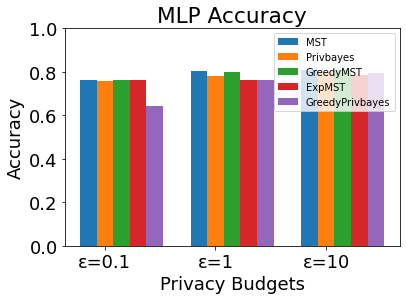

In [61]:
N = 3
workload_len = len(list(itertools.combinations(data.domain, 1)))
ind = np.arange(N) 
width = 0.15
#plt.yscale("log")
xvals = [np.mean(mst_accuracy_01), np.mean(mst_accuracy_1), np.mean(mst_accuracy_10)]
bar1 = plt.bar(ind, xvals, width)

yvals = [np.mean(privbayes_accuracy_01), np.mean(privbayes_accuracy_1), np.mean(privbayes_accuracy_10)]
bar2 = plt.bar(ind+width, yvals, width)
  
zvals = [np.mean(fair_greedy_mst_accuracy_01), np.mean(fair_greedy_mst_accuracy_1), np.mean(fair_greedy_mst_accuracy_10)]
bar3 = plt.bar(ind+width*2, zvals, width)

xxvals = [np.mean(fair_opt_mst_accuracy_01), np.mean(fair_opt_mst_accuracy_1), np.mean(fair_opt_mst_accuracy_10)]
bar4 = plt.bar(ind+width*3, xxvals, width)

xyvals = [np.mean(fair_privbayes_accuracy_01), np.mean(fair_privbayes_accuracy_1), np.mean(fair_privbayes_accuracy_10)]
bar5 = plt.bar(ind+width*4, xyvals, width)


plt.xlabel("Privacy Budgets")
plt.ylabel('Accuracy')
plt.title("MLP Accuracy")


plt.ylim([0, 1])
plt.xticks(ind+width,['ε=0.1','ε=1','ε=10'])
plt.legend( (bar1, bar2, bar3,bar4,bar5), ('MST','Privbayes', 'GreedyMST', 'ExpMST','GreedyPrivbayes'), fontsize = 10)
plt.savefig(artifactspath + 'ACCMLP.pdf', bbox_inches='tight')

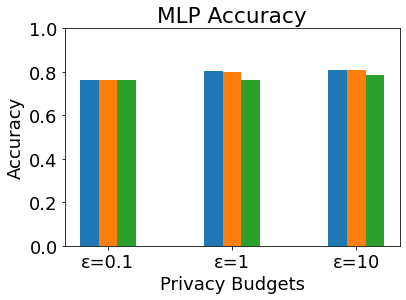

In [62]:
N = 3
workload_len = len(list(itertools.combinations(data.domain, 1)))
ind = np.arange(N) 
width = 0.15
#plt.yscale("log")
xvals = [np.mean(mst_accuracy_01), np.mean(mst_accuracy_1), np.mean(mst_accuracy_10)]
bar1 = plt.bar(ind, xvals, width)

  
zvals = [np.mean(fair_greedy_mst_accuracy_01), np.mean(fair_greedy_mst_accuracy_1), np.mean(fair_greedy_mst_accuracy_10)]
bar3 = plt.bar(ind+width*1, zvals, width)

xxvals = [np.mean(fair_opt_mst_accuracy_01), np.mean(fair_opt_mst_accuracy_1), np.mean(fair_opt_mst_accuracy_10)]
bar4 = plt.bar(ind+width*2, xxvals, width)


plt.xlabel("Privacy Budgets")
plt.ylabel('Accuracy')
plt.title("MLP Accuracy")

plt.ylim([0, 1])
plt.xticks(ind+width,['ε=0.1','ε=1','ε=10'])
#plt.legend( (bar1,  bar3,bar4), ('MST', 'GreedyMST', 'ExpMST'), fontsize = 10 )
plt.savefig(artifactspath + 'ACCMLPMST.pdf', bbox_inches='tight')

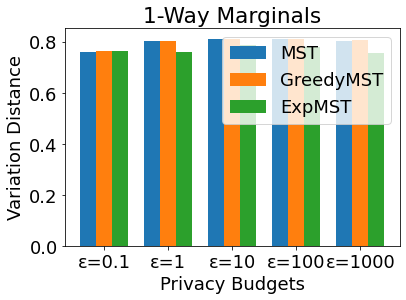

In [63]:
N = 5
ind = np.arange(N) 
width = 0.25
#plt.yscale("log")
xvals = [np.mean(mst_accuracy_01), np.mean(mst_accuracy_1), np.mean(mst_accuracy_10),np.mean(mst_accuracy_100),np.mean(mst_accuracy_1000)]
bar1 = plt.bar(ind, xvals, width)


yvals = [np.mean(fair_greedy_mst_accuracy_01), np.mean(fair_greedy_mst_accuracy_1), np.mean(fair_greedy_mst_accuracy_10),np.mean(fair_greedy_mst_accuracy_100),np.mean(fair_greedy_mst_accuracy_1000)]
bar2 = plt.bar(ind+width, yvals, width)
  
zvals = [np.mean(fair_opt_mst_accuracy_01), np.mean(fair_opt_mst_accuracy_1), np.mean(fair_opt_mst_accuracy_10),np.mean(fair_opt_mst_accuracy_100),np.mean(fair_opt_mst_accuracy_1000)]
bar3 = plt.bar(ind+width*2, zvals, width)
  
plt.xlabel("Privacy Budgets")
plt.ylabel('Variation Distance')
plt.title("1-Way Marginals")
  
plt.xticks(ind+width,['ε=0.1','ε=1','ε=10','ε=100','ε=1000'])
plt.legend( (bar1, bar2, bar3), ('MST', 'GreedyMST', 'ExpMST') )
plt.savefig(artifactspath + 'ACCall5.pdf', bbox_inches='tight')

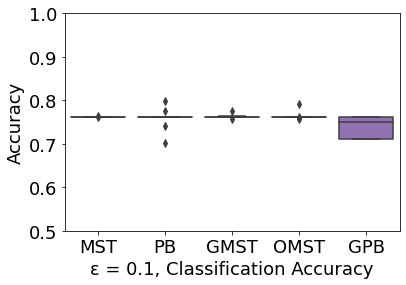

In [64]:

x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_accuracy_01,privbayes_accuracy_01,fair_greedy_mst_accuracy_01,fair_opt_mst_accuracy_01,fair_privbayes_accuracy_01]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)
ax.set_ylim([0.5, 1])

plt.xticks(x,x_axis)
plt.xlabel("ε = 0.1, Classification Accuracy")
plt.ylabel("Accuracy")
plt.savefig(artifactspath + 'accuracy_01.pdf', bbox_inches='tight')


<class 'list'>


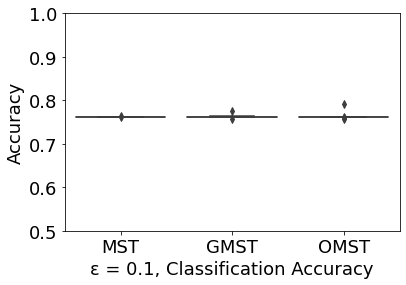

In [65]:

x=[0,1,2]
x_axis = ["MST", "GMST","OMST"]
print(type(mst_accuracy_01))
values = [mst_accuracy_01,fair_greedy_mst_accuracy_01,fair_opt_mst_accuracy_01]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)
ax.set_ylim([0.5, 1])
plt.xticks(x,x_axis)
plt.xlabel("ε = 0.1, Classification Accuracy")
plt.ylabel("Accuracy")
plt.savefig(artifactspath + 'accuracy_01_MST.pdf', bbox_inches='tight')


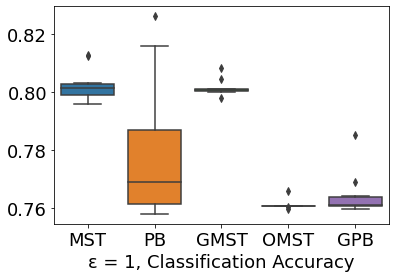

In [66]:

x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_accuracy_1,privbayes_accuracy_1,fair_greedy_mst_accuracy_1,fair_opt_mst_accuracy_1,fair_privbayes_accuracy_1]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 1, Classification Accuracy")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'accuracy_1.pdf', bbox_inches='tight')


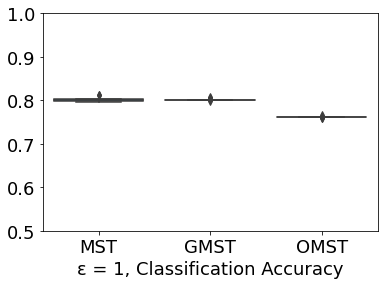

In [67]:

x=[0,1,2]
x_axis = ["MST", "GMST","OMST",]
values = [mst_accuracy_1,fair_greedy_mst_accuracy_1,fair_opt_mst_accuracy_1]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)
ax.set_ylim([0.5, 1])

plt.xticks(x,x_axis)
plt.xlabel("ε = 1, Classification Accuracy")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'accuracy_1_MST.pdf', bbox_inches='tight')


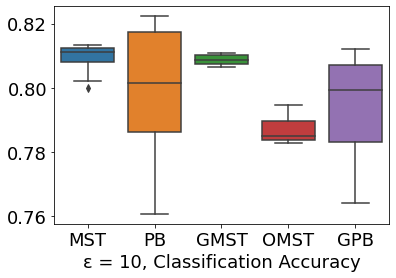

In [68]:

x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_accuracy_10,privbayes_accuracy_10,fair_greedy_mst_accuracy_10,fair_opt_mst_accuracy_10,fair_privbayes_accuracy_10]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 10, Classification Accuracy")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'accuracy_10.pdf', bbox_inches='tight')


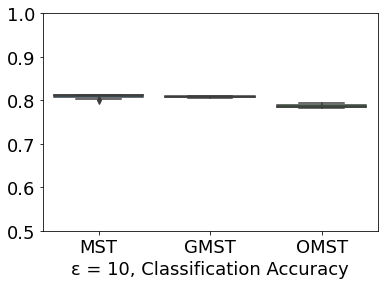

In [69]:

x=[0,1,2]
x_axis = ["MST","GMST","OMST"]
values = [mst_accuracy_10,fair_greedy_mst_accuracy_10,fair_opt_mst_accuracy_10]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)
ax.set_ylim([0.5, 1])

plt.xticks(x,x_axis)
plt.xlabel("ε = 10, Classification Accuracy")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'accuracy_10_MST.pdf', bbox_inches='tight')


## Accuracy Pairity (F1) Score

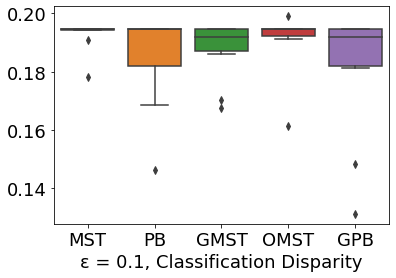

In [70]:

x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_accuracy_parity_01,privbayes_accuracy_parity_01,fair_greedy_mst_accuracy_parity_01,fair_opt_mst_accuracy_parity_01,fair_privbayes_accuracy_parity_01]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 0.1, Classification Disparity")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'accuracy_parity_01.pdf', bbox_inches='tight')


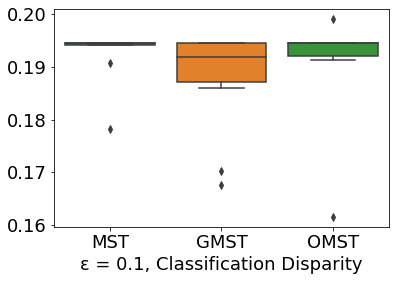

In [71]:

x=[0,1,2]
x_axis = ["MST", "GMST","OMST"]
values = [mst_accuracy_parity_01,fair_greedy_mst_accuracy_parity_01,fair_opt_mst_accuracy_parity_01]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 0.1, Classification Disparity")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'accuracy_parity_01_MST.pdf', bbox_inches='tight')


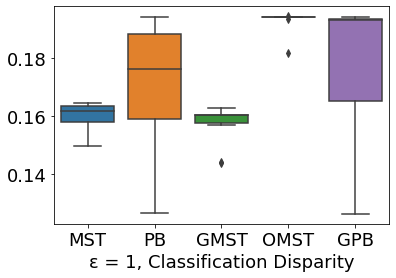

In [72]:

x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_accuracy_parity_1,privbayes_accuracy_parity_1,fair_greedy_mst_accuracy_parity_1,fair_opt_mst_accuracy_parity_1,fair_privbayes_accuracy_parity_1]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 1, Classification Disparity")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'accuracy_parity_1.pdf', bbox_inches='tight')


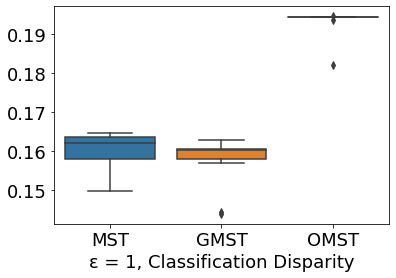

In [73]:

x=[0,1,2]
x_axis = ["MST", "GMST","OMST"]
values = [mst_accuracy_parity_1,fair_greedy_mst_accuracy_parity_1,fair_opt_mst_accuracy_parity_1]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 1, Classification Disparity")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'accuracy_parity_1_MST.pdf', bbox_inches='tight')


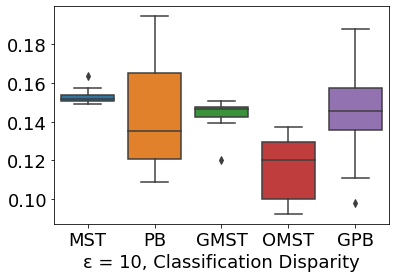

In [74]:

x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_accuracy_parity_10,privbayes_accuracy_parity_10,fair_greedy_mst_accuracy_parity_10,fair_opt_mst_accuracy_parity_10,fair_privbayes_accuracy_parity_10]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 10, Classification Disparity")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'accuracy_parity_10.pdf', bbox_inches='tight')


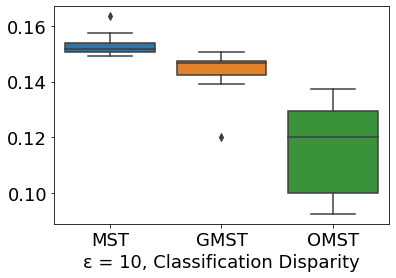

In [75]:

x=[0,1,2]
x_axis = ["MST", "GMST","OMST"]
values = [mst_accuracy_parity_10,fair_greedy_mst_accuracy_parity_10,fair_opt_mst_accuracy_parity_10]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 10, Classification Disparity")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'accuracy_parity_10_MST.pdf', bbox_inches='tight')


## Demographic Parity 

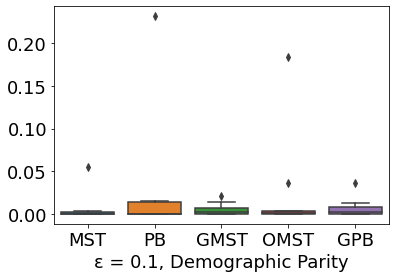

In [76]:
x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_demographic_parity_01,privbayes_demographic_parity_01,fair_greedy_mst_demographic_parity_01,fair_opt_mst_demographic_parity_01,fair_privbayes_demographic_parity_01]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 0.1, Demographic Parity")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'dem_parity_01.pdf', bbox_inches='tight')

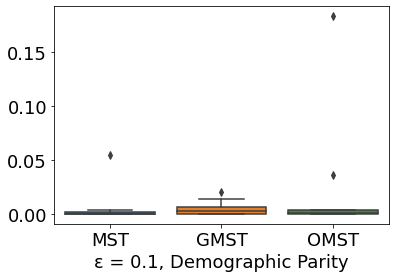

In [77]:
x=[0,1,2]
x_axis = ["MST", "GMST","OMST"]
values = [mst_demographic_parity_01,fair_greedy_mst_demographic_parity_01,fair_opt_mst_demographic_parity_01]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 0.1, Demographic Parity")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'dem_parity_01_MST.pdf', bbox_inches='tight')

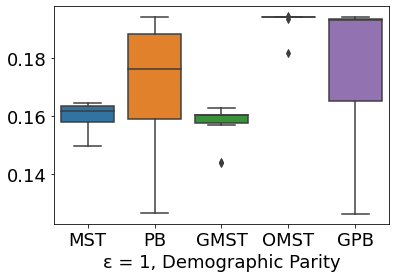

In [78]:

x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_accuracy_parity_1,privbayes_accuracy_parity_1,fair_greedy_mst_accuracy_parity_1,fair_opt_mst_accuracy_parity_1,fair_privbayes_accuracy_parity_1]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 1, Demographic Parity")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'dem_parity_1.pdf', bbox_inches='tight')


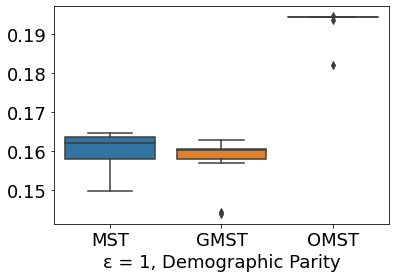

In [79]:

x=[0,1,2]
x_axis = ["MST", "GMST", "OMST"]
values = [mst_accuracy_parity_1,fair_greedy_mst_accuracy_parity_1,fair_opt_mst_accuracy_parity_1]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 1, Demographic Parity")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'dem_parity_1_MST.pdf', bbox_inches='tight')


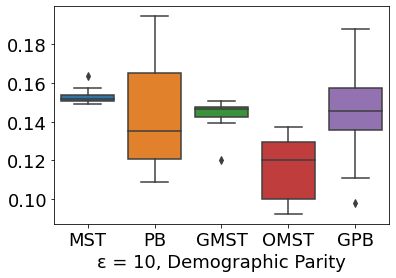

In [80]:

x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_accuracy_parity_10,privbayes_accuracy_parity_10,fair_greedy_mst_accuracy_parity_10,fair_opt_mst_accuracy_parity_10,fair_privbayes_accuracy_parity_10]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 10, Demographic Parity")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'dem_parity_10.pdf', bbox_inches='tight')


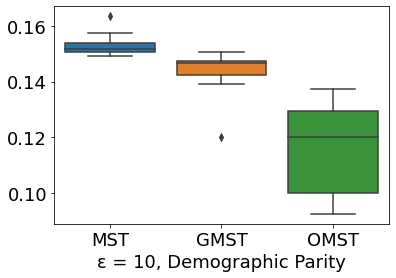

In [81]:

x=[0,1,2]
x_axis = ["MST", "GMST","OMST"]
values = [mst_accuracy_parity_10,fair_greedy_mst_accuracy_parity_10,fair_opt_mst_accuracy_parity_10]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 10, Demographic Parity")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'dem_parity_10_MST.pdf', bbox_inches='tight')


## True Positive Rate Balance

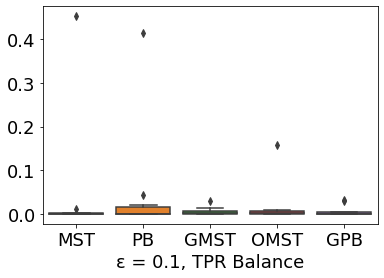

In [82]:
x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_TPRBalance_01,privbayes_TPRBalance_01,fair_greedy_mst_TPRBalance_01,fair_opt_mst_TPRBalance_01,fair_privbayes_TPRBalance_01]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 0.1, TPR Balance")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'TPR_Balance_01.pdf', bbox_inches='tight')

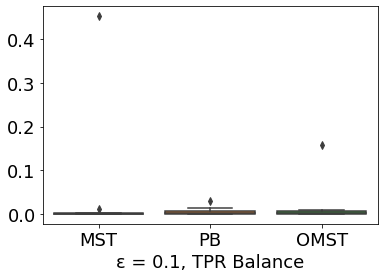

In [83]:
x=[0,1,2]
x_axis = ["MST","PB","OMST", ]
values = [mst_TPRBalance_01,fair_greedy_mst_TPRBalance_01,fair_opt_mst_TPRBalance_01]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 0.1, TPR Balance")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'TPR_Balance_01_MST.pdf', bbox_inches='tight')

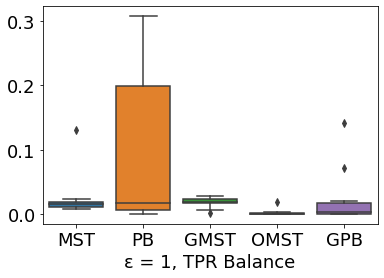

In [84]:
x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_TPRBalance_1,privbayes_TPRBalance_1,fair_greedy_mst_TPRBalance_1,fair_opt_mst_TPRBalance_1,fair_privbayes_TPRBalance_1]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 1, TPR Balance")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'TPR_Balance_1_MST.pdf', bbox_inches='tight')

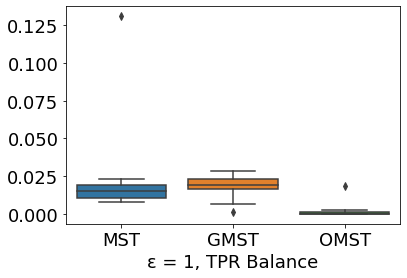

In [85]:
x=[0,1,2]
x_axis = ["MST", "GMST","OMST"]
values = [mst_TPRBalance_1,fair_greedy_mst_TPRBalance_1,fair_opt_mst_TPRBalance_1]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 1, TPR Balance")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'TPR_Balance_1_MST.pdf', bbox_inches='tight')

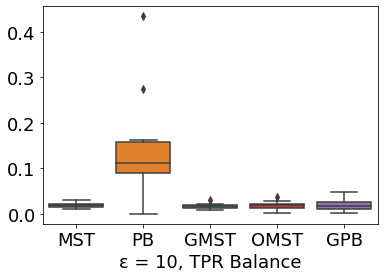

In [86]:
x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_TPRBalance_10,privbayes_TPRBalance_10,fair_greedy_mst_TPRBalance_10,fair_opt_mst_TPRBalance_10,fair_privbayes_TPRBalance_10]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 10, TPR Balance")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'TPR_Balance_10.pdf', bbox_inches='tight')

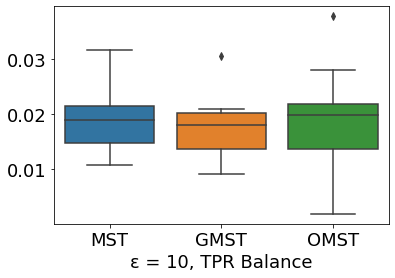

In [87]:
x=[0,1,2]
x_axis = ["MST", "GMST","OMST"]
values = [mst_TPRBalance_10,fair_greedy_mst_TPRBalance_10,fair_opt_mst_TPRBalance_10]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 10, TPR Balance")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'TPR_Balance_10_MST.pdf', bbox_inches='tight')

## True Negative Rate Balance

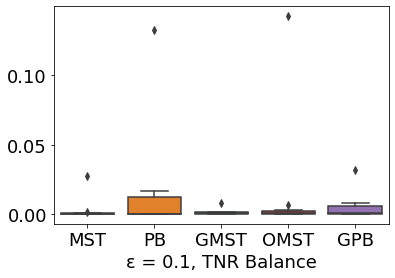

In [88]:
x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_TNRBalance_01,privbayes_TNRBalance_01,fair_greedy_mst_TNRBalance_01,fair_opt_mst_TNRBalance_01,fair_privbayes_TNRBalance_01]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 0.1, TNR Balance")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'TNR_Balance_01.pdf', bbox_inches='tight')

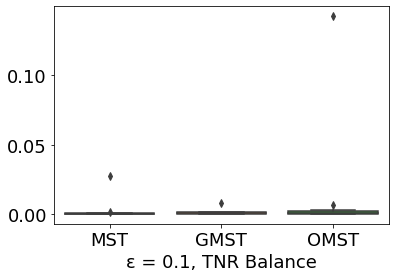

In [89]:
x=[0,1,2]
x_axis = ["MST", "GMST","OMST"]
values = [mst_TNRBalance_01,fair_greedy_mst_TNRBalance_01,fair_opt_mst_TNRBalance_01]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 0.1, TNR Balance")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'TNR_Balance_01_MST.pdf', bbox_inches='tight')

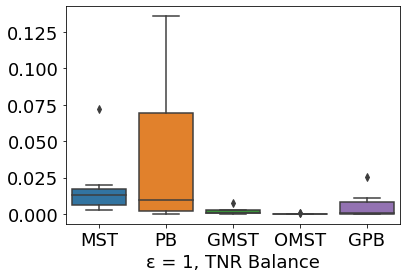

In [90]:
x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_TNRBalance_1,privbayes_TNRBalance_1,fair_greedy_mst_TNRBalance_1,fair_opt_mst_TNRBalance_1,fair_privbayes_TNRBalance_1]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 1, TNR Balance")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'TNR_Balance_1.pdf', bbox_inches='tight')

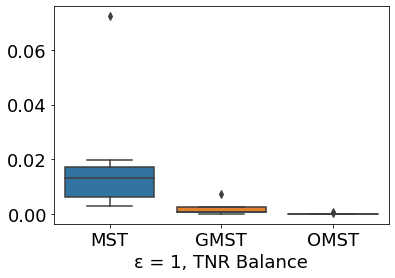

In [91]:
x=[0,1,2]
x_axis = ["MST", "GMST","OMST"]
values = [mst_TNRBalance_1,fair_greedy_mst_TNRBalance_1,fair_opt_mst_TNRBalance_1]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 1, TNR Balance")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'TNR_Balance_1_MST.pdf', bbox_inches='tight')

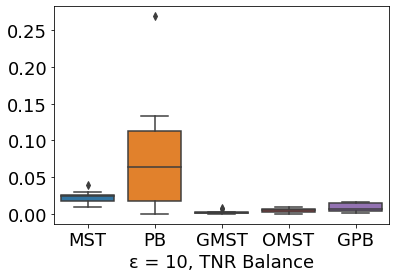

In [92]:
x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_TNRBalance_10,privbayes_TNRBalance_10,fair_greedy_mst_TNRBalance_10,fair_opt_mst_TNRBalance_10,fair_privbayes_TNRBalance_10]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 10, TNR Balance")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'TNR_Balance_10.pdf', bbox_inches='tight')

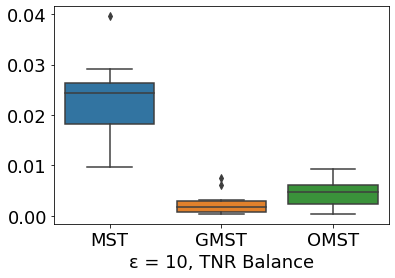

In [93]:
x=[0,1,2]
x_axis = ["MST", "GMST","OMST"]
values = [mst_TNRBalance_10,fair_greedy_mst_TNRBalance_10,fair_opt_mst_TNRBalance_10]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 10, TNR Balance")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'TNR_Balance_10._MST.pdf', bbox_inches='tight')

## Conditioned Demographic Parity

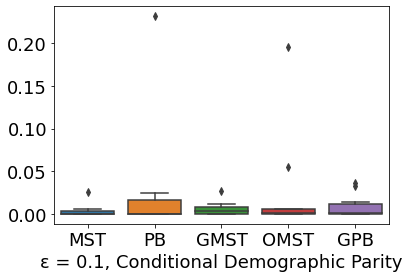

In [94]:
x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_conditional_demographic_parity_01,privbayes_conditional_demographic_parity_01,fair_greedy_mst_conditional_demographic_parity_01,fair_opt_mst_conditional_demographic_parity_01,fair_privbayes_conditional_demographic_parity_01]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 0.1, Conditional Demographic Parity")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'con_dem_parity_01.pdf', bbox_inches='tight')

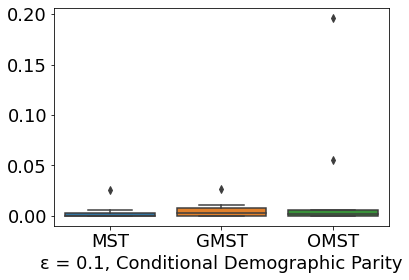

In [95]:
x=[0,1,2]
x_axis = ["MST", "GMST","OMST"]
values = [mst_conditional_demographic_parity_01,fair_greedy_mst_conditional_demographic_parity_01,fair_opt_mst_conditional_demographic_parity_01]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 0.1, Conditional Demographic Parity")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'con_dem_parity_01_MST.pdf', bbox_inches='tight')

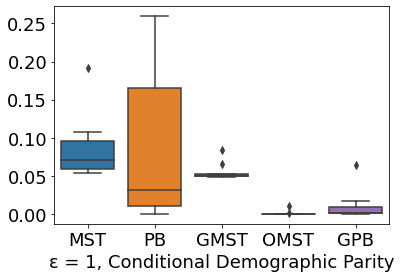

In [96]:
x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_conditional_demographic_parity_1,privbayes_conditional_demographic_parity_1,fair_greedy_mst_conditional_demographic_parity_1,fair_opt_mst_conditional_demographic_parity_1,fair_privbayes_conditional_demographic_parity_1]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 1, Conditional Demographic Parity")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'con_dem_parity_1.pdf', bbox_inches='tight')

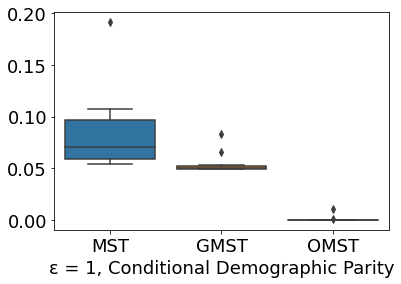

In [97]:
x=[0,1,2]
x_axis = ["MST", "GMST","OMST"]
values = [mst_conditional_demographic_parity_1,fair_greedy_mst_conditional_demographic_parity_1,fair_opt_mst_conditional_demographic_parity_1]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 1, Conditional Demographic Parity")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'con_dem_parity_1_MST.pdf', bbox_inches='tight')

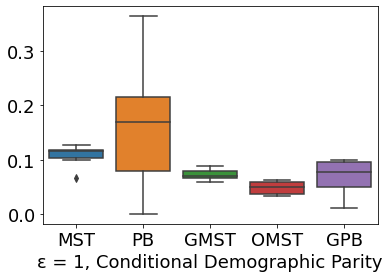

In [98]:
x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_conditional_demographic_parity_10,privbayes_conditional_demographic_parity_10,fair_greedy_mst_conditional_demographic_parity_10,fair_opt_mst_conditional_demographic_parity_10,fair_privbayes_conditional_demographic_parity_10]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 1, Conditional Demographic Parity")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'con_dem_parity_10.pdf', bbox_inches='tight')

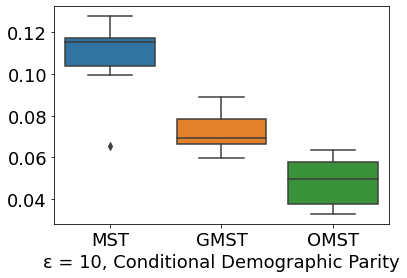

In [99]:
x=[0,1,2]
x_axis = ["MST", "GMST","OMST"]
values = [mst_conditional_demographic_parity_10,fair_greedy_mst_conditional_demographic_parity_10,fair_opt_mst_conditional_demographic_parity_10]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 10, Conditional Demographic Parity")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'con_dem_parity_10_MST.pdf', bbox_inches='tight')

## Conditioned True Positive Rate

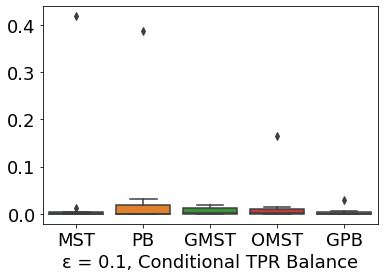

In [100]:
x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_conditional_TPRBalance_01,privbayes_conditional_TPRBalance_01,fair_greedy_mst_conditional_TPRBalance_01,fair_opt_mst_conditional_TPRBalance_01,fair_privbayes_conditional_TPRBalance_01]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 0.1, Conditional TPR Balance")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'con_TPR_Balance_01.pdf', bbox_inches='tight')

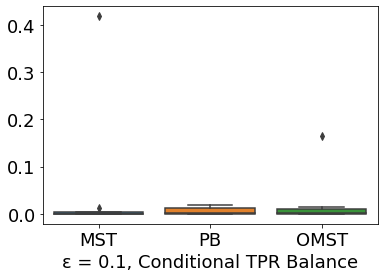

In [101]:
x=[0,1,2]
x_axis = ["MST","PB","OMST", ]
values = [mst_conditional_TPRBalance_01,fair_greedy_mst_conditional_TPRBalance_01,fair_opt_mst_conditional_TPRBalance_01]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 0.1, Conditional TPR Balance")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'con_TPR_Balance_01_MST.pdf', bbox_inches='tight')

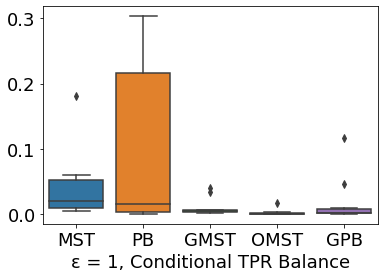

In [102]:
x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_conditional_TPRBalance_1,privbayes_conditional_TPRBalance_1,fair_greedy_mst_conditional_TPRBalance_1,fair_opt_mst_conditional_TPRBalance_1,fair_privbayes_conditional_TPRBalance_1]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 1, Conditional TPR Balance")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'con_TPR_Balance_1.pdf', bbox_inches='tight')

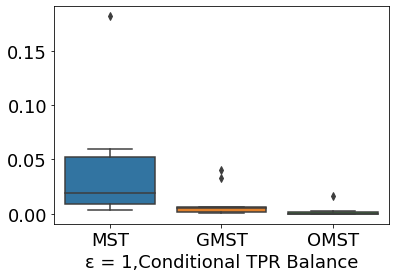

In [103]:
x=[0,1,2]
x_axis = ["MST","GMST","OMST"]
values = [mst_conditional_TPRBalance_1,fair_greedy_mst_conditional_TPRBalance_1,fair_opt_mst_conditional_TPRBalance_1]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 1,Conditional TPR Balance")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'con_TPR_Balance_1_MST.pdf', bbox_inches='tight')

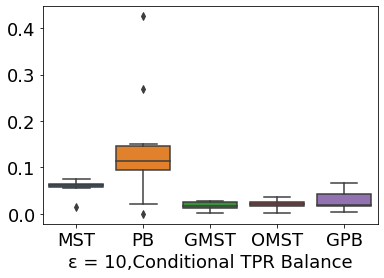

In [104]:
x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_conditional_TPRBalance_10,privbayes_conditional_TPRBalance_10,fair_greedy_mst_conditional_TPRBalance_10,fair_opt_mst_conditional_TPRBalance_10,fair_privbayes_conditional_TPRBalance_10]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 10,Conditional TPR Balance")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'con_TPR_Balance_10.pdf', bbox_inches='tight')

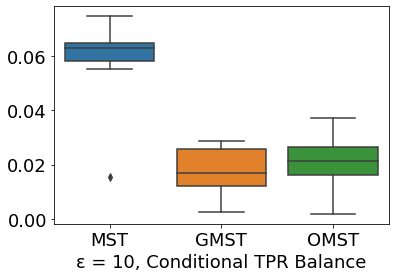

In [105]:
x=[0,1,2]
x_axis = ["MST","GMST","OMST", ]
values = [mst_conditional_TPRBalance_10,fair_greedy_mst_conditional_TPRBalance_10,fair_opt_mst_conditional_TPRBalance_10]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 10, Conditional TPR Balance")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'con_TPR_Balance_10_MST.pdf', bbox_inches='tight')

## Conditioned True Negative Balance 

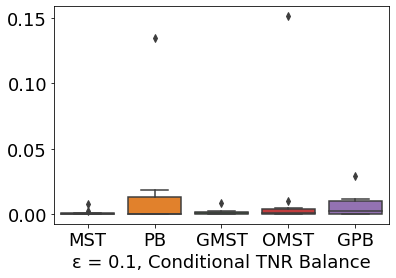

In [106]:
x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_conditional_TNRBalance_01,privbayes_conditional_TNRBalance_01,fair_greedy_mst_conditional_TNRBalance_01,fair_opt_mst_conditional_TNRBalance_01,fair_privbayes_conditional_TNRBalance_01]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 0.1, Conditional TNR Balance")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'con_TNR_Balance_01.pdf', bbox_inches='tight')

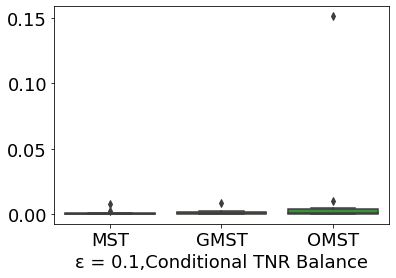

In [107]:
x=[0,1,2]
x_axis = ["MST", "GMST","OMST"]
values = [mst_conditional_TNRBalance_01,fair_greedy_mst_conditional_TNRBalance_01,fair_opt_mst_conditional_TNRBalance_01]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 0.1,Conditional TNR Balance")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'con_TNR_Balance_01_MST.pdf', bbox_inches='tight')

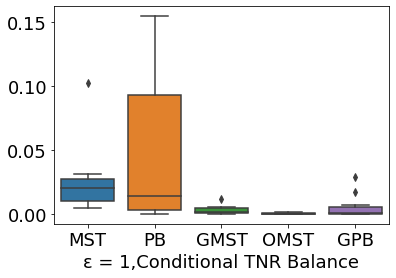

In [108]:
x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_conditional_TNRBalance_1,privbayes_conditional_TNRBalance_1,fair_greedy_mst_conditional_TNRBalance_1,fair_opt_mst_conditional_TNRBalance_1,fair_privbayes_conditional_TNRBalance_1]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 1,Conditional TNR Balance")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'con_TNR_Balance_1.pdf', bbox_inches='tight')

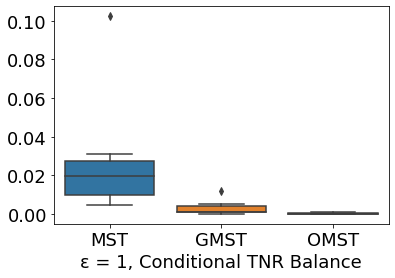

In [109]:
x=[0,1,2]
x_axis = ["MST", "GMST","OMST"]
values = [mst_conditional_TNRBalance_1,fair_greedy_mst_conditional_TNRBalance_1,fair_opt_mst_conditional_TNRBalance_1]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 1, Conditional TNR Balance")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'con_TNR_Balance_1_MST.pdf', bbox_inches='tight')

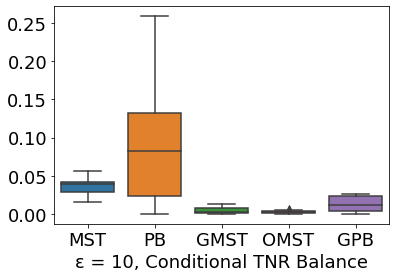

In [110]:
x=[0,1,2,3,4]
x_axis = ["MST","PB", "GMST","OMST", "GPB"]
values = [mst_conditional_TNRBalance_10,privbayes_conditional_TNRBalance_10,fair_greedy_mst_conditional_TNRBalance_10,fair_opt_mst_conditional_TNRBalance_10,fair_privbayes_conditional_TNRBalance_10]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 10, Conditional TNR Balance")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'con_TNR_Balance_10.pdf', bbox_inches='tight')

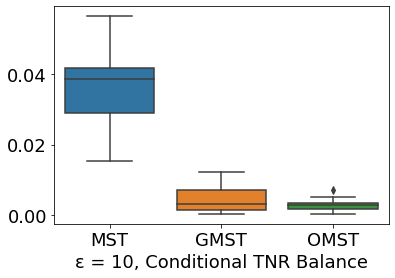

In [111]:
x=[0,1,2]
x_axis = ["MST", "GMST","OMST"]
values = [mst_conditional_TNRBalance_10,fair_greedy_mst_conditional_TNRBalance_10,fair_opt_mst_conditional_TNRBalance_10]


#ax = sns.boxplot(x = x_axis, data = np.array(values))

ax = sns.boxplot(data = values)

plt.xticks(x,x_axis)
plt.xlabel("ε = 10, Conditional TNR Balance")
#plt.ylabel("Total Variation Distance")
plt.savefig(artifactspath + 'con_TNR_Balance_10_MST.pdf', bbox_inches='tight')

# Linear Regression

In [112]:
def LR_test(path):
    accuracy_vals= []
    accuracy_parity_vals = []
    demographic_parity_vals = []
    TPRBalance_vals = []
    TNRBalance_vals =[]
    conditional_demographic_parity_vals = []
    conditional_TPRBalance_vals = []
    conditional_TNRBalance_vals =[]

    for i in range(10):
        # training models on greedy_fair_mst
        testpath = "data/adult.csv"
        test = pd.read_csv(testpath)
        test_lables = test.pop('income>50K')
        #tf.convert_to_tensor(test)


        trainpath = f'{path}{i}.csv'
        train = pd.read_csv(trainpath)
        train_lables = train.pop('income>50K')

        regr = LinearRegression()
        regr.fit(train, train_lables)
        predictions = regr.predict(test)
        #model.fit(train, train_lables, epochs=10, batch_size=BATCH_SIZE)

        test['Income'] = test_lables
        test['Predicted'] = predictions

        test = test.round({'Predicted': 0})
        test["Predicted"]=test["Predicted"].astype(int)

        test['ACC'] = ((test['Predicted'] == 1) & (test['Income'] == 1)) | ((test['Predicted'] == 0) & (test['Income'] == 0))
        test['S0TP'] = (test['Predicted'] == 1) & (test['Income'] == 1) & (test['sex'] == 0) 
        test['S0TN'] = (test['Predicted'] == 0) & (test['Income'] == 0)  & (test['sex'] == 0) 
        test['S0Pos'] = (test['Income'] == 1)  & (test['sex'] == 0) 
        test['S0Neg'] = (test['Income'] == 0)  & (test['sex'] == 0) 
        test['S0pred_pos'] = (test['Predicted'] == 1) & (test['sex'] == 0) 
        test['S0count'] = (test['sex'] == 0)
        test['S1TP'] = (test['Predicted'] == 1) & (test['Income'] == 1) & (test['sex'] == 1) 
        test['S1TN'] = (test['Predicted'] == 0) & (test['Income'] == 0)  & (test['sex'] == 1) 
        test['S1Pos'] = (test['Income'] == 1)  & (test['sex'] == 1) 
        test['S1Neg'] = (test['Income'] == 0)  & (test['sex'] == 1) 
        test['S1pred_pos'] = (test['Predicted'] == 1) & (test['sex'] == 1) 
        test['S1count'] = (test['sex'] == 1)
        test['S0ACC'] = (test['ACC'] == 1)  & (test['sex'] == 1) 
        test['S1ACC'] =(test['ACC'] == 1)  & (test['sex'] == 0) 

        accuracy = test['ACC'].sum()/test.shape[0]

        accuracy_vals.append(accuracy)


        sex0_accuracy = test['S0ACC'].sum()/test['S0count'].sum()
        sex1_accuracy = test['S1ACC'].sum()/test['S1count'].sum()
        accuracy_parity_vals.append(abs(sex1_accuracy-sex0_accuracy))


        sex1 = test.loc[test['sex'] == 1]
        sex0 = test.loc[test['sex'] == 0]
        sex1_count = len(sex1.index)
        sex0_count = len(sex0.index)
        demographic_parity = abs((sex1['Predicted'].sum()/sex1_count) -(sex0['Predicted'].sum()/sex0_count))
        demographic_parity_vals.append(demographic_parity)

        sex1TPR = len(sex1.loc[(sex1['Income'] == 1) & (sex1['Predicted'] == 1)].index)/len(sex1.loc[(sex1['Income'] == 1)].index)
        sex0TPR = len(sex0.loc[(sex0['Income'] == 1) & (sex0['Predicted'] == 1)].index)/len(sex0.loc[(sex0['Income'] == 1)].index) 
        TPRBalance = abs(sex1TPR - sex0TPR)
        TPRBalance_vals.append(TPRBalance)

        sex1TNR = len(sex1.loc[(sex1['Income'] == 0) & (sex1['Predicted'] == 0)].index)/len(sex1.loc[(sex1['Income'] == 0)].index)
        sex0TNR = len(sex0.loc[(sex0['Income'] == 0) & (sex0['Predicted'] == 0)].index)/len(sex0.loc[(sex0['Income'] == 0)].index) 
        TNRBalance = abs(sex1TNR - sex0TNR)
        TNRBalance_vals.append(TNRBalance)


        admis_group = test.groupby(admissible, sort = False)


        tp0 = admis_group['S0TP'].sum()
        pos0 = admis_group['S0Pos'].sum()
        tn0 = admis_group['S0TN'].sum()
        neg0 = admis_group['S0Neg'].sum()
        pred_pos0 = admis_group['S0pred_pos'].sum()
        counts0 = admis_group['S0count'].sum()

        sex0_group_tpr = (tp0/pos0)
        sex0_group_tpr = sex0_group_tpr.values
        sex0_group_tpr = sex0_group_tpr[~np.isnan(sex0_group_tpr)]

        sex0_group_tnr = (tn0/neg0)
        sex0_group_tnr =sex0_group_tnr.values
        sex0_group_tnr = sex0_group_tnr[~np.isnan(sex0_group_tnr)]

        sex0_group_dp = (pred_pos0/counts0)
        sex0_group_dp =sex0_group_dp.values
        sex0_group_dp = sex0_group_dp[~np.isnan(sex0_group_dp)]


        tp1 = admis_group['S1TP'].sum()
        pos1 = admis_group['S1Pos'].sum()
        tn1 = admis_group['S1TN'].sum()
        neg1 = admis_group['S1Neg'].sum()
        pred_pos1 = admis_group['S1pred_pos'].sum()
        counts1 = admis_group['S1count'].sum()

        sex1_group_tpr = (tp1/pos1)
        sex1_group_tpr = sex1_group_tpr.values
        sex1_group_tpr = sex1_group_tpr[~np.isnan(sex1_group_tpr)]

        sex1_group_tnr = (tn1/neg1)
        sex1_group_tnr =sex1_group_tnr.values
        sex1_group_tnr = sex1_group_tnr[~np.isnan(sex1_group_tnr)]

        sex1_group_dp = (pred_pos1/counts1)
        sex1_group_dp =sex1_group_dp.values
        sex1_group_dp = sex1_group_dp[~np.isnan(sex1_group_dp)]

        conditional_demographic_parity_vals.append(abs(np.mean(sex1_group_dp)-np.mean(sex0_group_dp)))
        conditional_TPRBalance_vals.append(abs(np.mean(sex1_group_tpr)-np.mean(sex0_group_tpr)))
        conditional_TNRBalance_vals.append(abs(np.mean(sex1_group_tnr)-np.mean(sex0_group_tnr)))

    print("eps = 0.1")
    print("Average Accuracy: " + str(np.mean(accuracy_vals)))
    print("Average Accuracy Parity: " + str(np.mean(accuracy_parity_vals)))
    print("Average Demographic Parity: " + str(np.mean(demographic_parity_vals)))
    print("Average TPR Balance: " + str(np.mean(TPRBalance_vals)))
    print("Average TNR Balance: " + str(np.mean(TNRBalance_vals)))

    print("Average Conditional Demographic Parity: " + str(np.mean(conditional_demographic_parity_vals)))
    print("Average Conditional TPR Balance: " + str(np.mean(conditional_TPRBalance_vals)))
    print("Average Conditional TNR Balance: " + str(np.mean(conditional_TNRBalance_vals)))

    return((accuracy_vals,accuracy_parity_vals,demographic_parity_vals,TPRBalance_vals,TNRBalance_vals,conditional_demographic_parity_vals,conditional_TPRBalance_vals,conditional_TNRBalance_vals))

In [113]:
#eps = 0.1 MST

path = 'data/original/eps=0.1/results_original_'
print("eps=0.1")
vals = LR_test(path)
mst_accuracy_01LR = vals[0]
mst_accuracy_parity_01LR = vals[1]
mst_demographic_parity_01LR = vals[2]
mst_TPRBalance_01LR = vals[3]
mst_TNRBalance_01LR =vals[4]
mst_conditional_demographic_parity_01LR = vals[5]
mst_conditional_TPRBalance_01LR = vals[6]
mst_conditional_TNRBalance_01LR =vals[7]

#eps = 1 MST
path = 'data/original/eps=1/results_original_'
print("eps=1")
vals = LR_test(path)
mst_accuracy_1LR = vals[0]
mst_accuracy_parity_1LR = vals[1]
mst_demographic_parity_1LR = vals[2]
mst_TPRBalance_1LR = vals[3]
mst_TNRBalance_1LR =vals[4]
mst_conditional_demographic_parity_1LR = vals[5]
mst_conditional_TPRBalance_1LR = vals[6]
mst_conditional_TNRBalance_1LR =vals[7]

#eps = 10 MST
path = 'data/original/eps=10/results_original_'
print("eps=10")
vals = LR_test(path)
mst_accuracy_10LR = vals[0]
mst_accuracy_parity_10LR = vals[1]
mst_demographic_parity_10LR = vals[2]
mst_TPRBalance_10LR = vals[3]
mst_TNRBalance_10LR =vals[4]

mst_conditional_demographic_parity_10LR = vals[5]
mst_conditional_TPRBalance_10LR = vals[6]
mst_conditional_TNRBalance_10LR =vals[7]

eps=0.1
eps = 0.1
Average Accuracy: 0.7607182343065395
Average Accuracy Parity: 0.9621573733876481
Average Demographic Parity: 0.0
Average TPR Balance: 0.0
Average TNR Balance: 0.0
Average Conditional Demographic Parity: 0.0
Average Conditional TPR Balance: 0.0
Average Conditional TNR Balance: 0.0
eps=1
eps = 0.1
Average Accuracy: 0.7781151467998854
Average Accuracy Parity: 1.007788045748113
Average Demographic Parity: 0.02288621269119721
Average TPR Balance: 0.040786911692270056
Average TNR Balance: 0.002749761489255198
Average Conditional Demographic Parity: 0.035478691451802144
Average Conditional TPR Balance: 0.05618867395570507
Average Conditional TNR Balance: 0.0043518510391826306
eps=10
eps = 0.1
Average Accuracy: 0.7898366160271897
Average Accuracy Parity: 1.0367148933320824
Average Demographic Parity: 0.04925139179766235
Average TPR Balance: 0.06471889163269962
Average TNR Balance: 0.014351238086068219
Average Conditional Demographic Parity: 0.07695687223172622
Average Conditi

In [114]:
#eps = 0.1 fair_greedy_mst
path = 'data/fair_greedy/eps=0.1/results_greedy_'
print("eps=0.1")
vals = LR_test(path)

fair_greedy_mst_accuracy_01LR= vals[0]
fair_greedy_mst_accuracy_parity_01LR = vals[1]
fair_greedy_mst_demographic_parity_01LR = vals[2]
fair_greedy_mst_TPRBalance_01LR = vals[3]
fair_greedy_mst_TNRBalance_01LR =vals[4]
fair_greedy_mst_conditional_demographic_parity_01LR = vals[5]
fair_greedy_mst_conditional_TPRBalance_01LR = vals[6]
fair_greedy_mst_conditional_TNRBalance_01LR =vals[7]


path = 'data/fair_greedy/eps=1/results_greedy_'
print("eps=1")
vals = LR_test(path)

fair_greedy_mst_accuracy_1LR= vals[0]
fair_greedy_mst_accuracy_parity_1LR = vals[1]
fair_greedy_mst_demographic_parity_1LR = vals[2]
fair_greedy_mst_TPRBalance_1LR = vals[3]
fair_greedy_mst_TNRBalance_1LR =vals[4]
fair_greedy_mst_conditional_demographic_parity_1LR = vals[5]
fair_greedy_mst_conditional_TPRBalance_1LR = vals[6]
fair_greedy_mst_conditional_TNRBalance_1LR =vals[7]



path = 'data/fair_greedy/eps=10/results_greedy_'
print("eps=10")
vals = LR_test(path)

fair_greedy_mst_accuracy_10LR= vals[0]
fair_greedy_mst_accuracy_parity_10LR = vals[1]
fair_greedy_mst_demographic_parity_10LR = vals[2]
fair_greedy_mst_TPRBalance_10LR = vals[3]
fair_greedy_mst_TNRBalance_10LR =vals[4]
fair_greedy_mst_conditional_demographic_parity_10LR = vals[5]
fair_greedy_mst_conditional_TPRBalance_10LR = vals[6]
fair_greedy_mst_conditional_TNRBalance_10LR =vals[7]


eps=0.1
eps = 0.1
Average Accuracy: 0.7607182343065395
Average Accuracy Parity: 0.9621573733876481
Average Demographic Parity: 0.0
Average TPR Balance: 0.0
Average TNR Balance: 0.0
Average Conditional Demographic Parity: 0.0
Average Conditional TPR Balance: 0.0
Average Conditional TNR Balance: 0.0
eps=1
eps = 0.1
Average Accuracy: 0.7720465992383605
Average Accuracy Parity: 0.9906837377201001
Average Demographic Parity: 0.011940830629687245
Average TPR Balance: 0.01410302182817133
Average TNR Balance: 0.00026188784168792447
Average Conditional Demographic Parity: 0.01804558892546137
Average Conditional TPR Balance: 0.022847998184415342
Average Conditional TNR Balance: 0.0004259502735756815
eps=10
eps = 0.1
Average Accuracy: 0.7795872404897425
Average Accuracy Parity: 1.0117111442929865
Average Demographic Parity: 0.027666891255924315
Average TPR Balance: 0.0023429829520097588
Average TNR Balance: 0.0016554595886931645
Average Conditional Demographic Parity: 0.032113071547932706
Average

In [115]:
#eps = 0.1 fair_opt_mst
path = 'data/fair_opt/eps=0.1/results_opt_'
print("eps=0.1")
vals = LR_test(path)
fair_opt_mst_accuracy_01LR= vals[0]
fair_opt_mst_accuracy_parity_01LR = vals[1]
fair_opt_mst_demographic_parity_01LR = vals[2]
fair_opt_mst_TPRBalance_01LR = vals[3]
fair_opt_mst_TNRBalance_01LR =vals[4]
fair_opt_mst_conditional_demographic_parity_01LR = vals[5]
fair_opt_mst_conditional_TPRBalance_01LR = vals[6]
fair_opt_mst_conditional_TNRBalance_01LR =vals[7]

path = 'data/fair_opt/eps=1/results_opt_'
print("eps=1")
vals = LR_test(path)
fair_opt_mst_accuracy_1LR= vals[0]
fair_opt_mst_accuracy_parity_1LR = vals[1]
fair_opt_mst_demographic_parity_1LR = vals[2]
fair_opt_mst_TPRBalance_1LR = vals[3]
fair_opt_mst_TNRBalance_1LR =vals[4]
fair_opt_mst_conditional_demographic_parity_1LR = vals[5]
fair_opt_mst_conditional_TPRBalance_1LR = vals[6]
fair_opt_mst_conditional_TNRBalance_1LR =vals[7]


path = 'data/fair_opt/eps=10/results_opt_'
print("eps=10")
vals = LR_test(path)
fair_opt_mst_accuracy_10LR= vals[0]
fair_opt_mst_accuracy_parity_10LR = vals[1]
fair_opt_mst_demographic_parity_10LR = vals[2]
fair_opt_mst_TPRBalance_10LR = vals[3]
fair_opt_mst_TNRBalance_10LR =vals[4]
fair_opt_mst_conditional_demographic_parity_10LR = vals[5]
fair_opt_mst_conditional_TPRBalance_10LR = vals[6]
fair_opt_mst_conditional_TNRBalance_10LR =vals[7]



eps=0.1
eps = 0.1
Average Accuracy: 0.7612505630400066
Average Accuracy Parity: 0.963282693436798
Average Demographic Parity: 0.0005382454951001458
Average TPR Balance: 0.0010796729906545144
Average TNR Balance: 1.3866740622614504e-05
Average Conditional Demographic Parity: 0.0008453619009506993
Average Conditional TPR Balance: 0.0014984135884051778
Average Conditional TNR Balance: 2.186987424822595e-05
eps=1
eps = 0.1
Average Accuracy: 0.7604889234675075
Average Accuracy Parity: 0.9617705501062289
Average Demographic Parity: 0.00050279380965928
Average TPR Balance: 0.0004390097157345974
Average TNR Balance: 0.00046984015025075543
Average Conditional Demographic Parity: 0.0007933726946624551
Average Conditional TPR Balance: 0.0006459676665732175
Average Conditional TNR Balance: 0.0007242479630838905
eps=10
eps = 0.1
Average Accuracy: 0.7786167642602678
Average Accuracy Parity: 1.0301990247958646
Average Demographic Parity: 0.038101856966024854
Average TPR Balance: 0.050859837553182
Ave

In [116]:
#eps = 0.1 privbayes
path = 'data/Bayes_original/eps=0.1/sythetic_data_'
print('eps=0.1')

values = LR_test(path)
privbayes_accuracy_01LR= vals[0]
privbayes_accuracy_parity_01LR = vals[1]
privbayes_demographic_parity_01LR = vals[2]
privbayes_TPRBalance_01LR = vals[3]
privbayes_TNRBalance_01LR =vals[4]
privbayes_conditional_demographic_parity_01LR = vals[5]
privbayes_conditional_TPRBalance_01LR = vals[6]
privbayes_conditional_TNRBalance_01LR =vals[7]

path = 'data/Bayes_original/eps=1/sythetic_data_'
print('eps=1')

values = LR_test(path)
privbayes_accuracy_1LR= vals[0]
privbayes_accuracy_parity_1LR = vals[1]
privbayes_demographic_parity_1LR = vals[2]
privbayes_TPRBalance_1LR = vals[3]
privbayes_TNRBalance_1LR =vals[4]
privbayes_conditional_demographic_parity_1LR = vals[5]
privbayes_conditional_TPRBalance_1LR = vals[6]
privbayes_conditional_TNRBalance_1LR =vals[7]


path = 'data/Bayes_original/eps=10/sythetic_data_'
print('eps=10')

values = LR_test(path)
privbayes_accuracy_10LR= vals[0]
privbayes_accuracy_parity_10LR = vals[1]
privbayes_demographic_parity_10LR = vals[2]
privbayes_TPRBalance_10LR = vals[3]
privbayes_TNRBalance_10LR =vals[4]
privbayes_conditional_demographic_parity_10LR = vals[5]
privbayes_conditional_TPRBalance_10LR = vals[6]
privbayes_conditional_TNRBalance_10LR =vals[7]


eps=0.1
eps = 0.1
Average Accuracy: 0.7138917325252857
Average Accuracy Parity: 0.9212775896742913
Average Demographic Parity: 0.01015409042485579
Average TPR Balance: 0.02033345564778726
Average TNR Balance: 0.00923787351641522
Average Conditional Demographic Parity: 0.011556201795951838
Average Conditional TPR Balance: 0.01954954250447328
Average Conditional TNR Balance: 0.00988483847601912
eps=1
eps = 0.1
Average Accuracy: 0.7585582080995865
Average Accuracy Parity: 0.9619425874952334
Average Demographic Parity: 0.008778040996555877
Average TPR Balance: 0.012903679020426514
Average TNR Balance: 0.005837095029349359
Average Conditional Demographic Parity: 0.01265315885236266
Average Conditional TPR Balance: 0.016533818282520006
Average Conditional TNR Balance: 0.007898584527497565
eps=10
eps = 0.1
Average Accuracy: 0.7679619999181033
Average Accuracy Parity: 0.9827881645370411
Average Demographic Parity: 0.022202299057557395
Average TPR Balance: 0.03351465624679752
Average TNR Balanc

In [117]:
#eps = 0.1 fair privbayes
path = 'data/Bayes_fair/eps=0.1/sythetic_data_'
print('eps=0.1')

values = LR_test(path)
fair_privbayes_accuracy_01LR= vals[0]
fair_privbayes_accuracy_parity_01LR = vals[1]
fair_privbayes_demographic_parity_01LR = vals[2]
fair_privbayes_TPRBalance_01LR = vals[3]
fair_privbayes_TNRBalance_01LR =vals[4]
fair_privbayes_conditional_demographic_parity_01LR = vals[5]
fair_privbayes_conditional_TPRBalance_01LR = vals[6]
fair_privbayes_conditional_TNRBalance_01LR =vals[7]

path = 'data/Bayes_fair/eps=1/sythetic_data_'
print('eps=1')

values = LR_test(path)
fair_privbayes_accuracy_1LR= vals[0]
fair_privbayes_accuracy_parity_1LR = vals[1]
fair_privbayes_demographic_parity_1LR = vals[2]
fair_privbayes_TPRBalance_1LR = vals[3]
fair_privbayes_TNRBalance_1LR =vals[4]
fair_privbayes_conditional_demographic_parity_1LR = vals[5]
fair_privbayes_conditional_TPRBalance_1LR = vals[6]
fair_privbayes_conditional_TNRBalance_1LR =vals[7]


path = 'data/Bayes_fair/eps=10/sythetic_data_'
print('eps=10')

values = LR_test(path)
fair_privbayes_accuracy_10LR= vals[0]
fair_privbayes_accuracy_parity_10LR = vals[1]
fair_privbayes_demographic_parity_10LR = vals[2]
fair_privbayes_TPRBalance_10LR = vals[3]
fair_privbayes_TNRBalance_10LR =vals[4]
fair_privbayes_conditional_demographic_parity_10LR = vals[5]
fair_privbayes_conditional_TPRBalance_10LR = vals[6]
fair_privbayes_conditional_TNRBalance_10LR =vals[7]


eps=0.1
eps = 0.1
Average Accuracy: 0.7212542483927766
Average Accuracy Parity: 0.9028728659606922
Average Demographic Parity: 0.0694485674206611
Average TPR Balance: 0.06837989547072883
Average TNR Balance: 0.06944701241585693
Average Conditional Demographic Parity: 0.06968401794194104
Average Conditional TPR Balance: 0.06738540215964575
Average Conditional TNR Balance: 0.07011679168088822
eps=1
eps = 0.1
Average Accuracy: 0.7614593996969822
Average Accuracy Parity: 0.9639403501776538
Average Demographic Parity: 0.0006870641883916735
Average TPR Balance: 0.0003439680792333199
Average TNR Balance: 6.933370311308362e-05
Average Conditional Demographic Parity: 0.0010859318131405033
Average Conditional TPR Balance: 0.0007762403157693317
Average Conditional TNR Balance: 0.00010934937124110756
eps=10
eps = 0.1
Average Accuracy: 0.7641701814012529
Average Accuracy Parity: 0.9710270638252153
Average Demographic Parity: 0.003970950054173804
Average TPR Balance: 0.004379353320176266
Average TNR

# Random Forest

In [118]:
def RF_test(path):
    accuracy_vals= []
    accuracy_parity_vals = []
    demographic_parity_vals = []
    TPRBalance_vals = []
    TNRBalance_vals =[]
    conditional_demographic_parity_vals = []
    conditional_TPRBalance_vals = []
    conditional_TNRBalance_vals =[]

    for i in range(10):
        # training models on greedy_fair_mst
        testpath = "data/adult.csv"
        test = pd.read_csv(testpath)
        test_lables = test.pop('income>50K')
        #tf.convert_to_tensor(test)


        trainpath = f'{path}{i}.csv'
        train = pd.read_csv(trainpath)
        train_lables = train.pop('income>50K')

        rf = RandomForestRegressor(n_estimators = 200)
        rf.fit(train, train_lables)
        predictions = rf.predict(test)
        #model.fit(train, train_lables, epochs=10, batch_size=BATCH_SIZE)

        test['Income'] = test_lables
        test['Predicted'] = predictions

        test = test.round({'Predicted': 0})
        test["Predicted"]=test["Predicted"].astype(int)

        test['ACC'] = ((test['Predicted'] == 1) & (test['Income'] == 1)) | ((test['Predicted'] == 0) & (test['Income'] == 0))
        test['S0TP'] = (test['Predicted'] == 1) & (test['Income'] == 1) & (test['sex'] == 0) 
        test['S0TN'] = (test['Predicted'] == 0) & (test['Income'] == 0)  & (test['sex'] == 0) 
        test['S0Pos'] = (test['Income'] == 1)  & (test['sex'] == 0) 
        test['S0Neg'] = (test['Income'] == 0)  & (test['sex'] == 0) 
        test['S0pred_pos'] = (test['Predicted'] == 1) & (test['sex'] == 0) 
        test['S0count'] = (test['sex'] == 0)
        test['S1TP'] = (test['Predicted'] == 1) & (test['Income'] == 1) & (test['sex'] == 1) 
        test['S1TN'] = (test['Predicted'] == 0) & (test['Income'] == 0)  & (test['sex'] == 1) 
        test['S1Pos'] = (test['Income'] == 1)  & (test['sex'] == 1) 
        test['S1Neg'] = (test['Income'] == 0)  & (test['sex'] == 1) 
        test['S1pred_pos'] = (test['Predicted'] == 1) & (test['sex'] == 1) 
        test['S1count'] = (test['sex'] == 1)
        test['S0ACC'] = (test['ACC'] == 1)  & (test['sex'] == 1) 
        test['S1ACC'] =(test['ACC'] == 1)  & (test['sex'] == 0) 

        accuracy = test['ACC'].sum()/test.shape[0]

        accuracy_vals.append(accuracy)


        sex0_accuracy = test['S0ACC'].sum()/test['S0count'].sum()
        sex1_accuracy = test['S1ACC'].sum()/test['S1count'].sum()
        accuracy_parity_vals.append(abs(sex1_accuracy-sex0_accuracy))


        sex1 = test.loc[test['sex'] == 1]
        sex0 = test.loc[test['sex'] == 0]
        sex1_count = len(sex1.index)
        sex0_count = len(sex0.index)
        demographic_parity = abs((sex1['Predicted'].sum()/sex1_count) -(sex0['Predicted'].sum()/sex0_count))
        demographic_parity_vals.append(demographic_parity)

        sex1TPR = len(sex1.loc[(sex1['Income'] == 1) & (sex1['Predicted'] == 1)].index)/len(sex1.loc[(sex1['Income'] == 1)].index)
        sex0TPR = len(sex0.loc[(sex0['Income'] == 1) & (sex0['Predicted'] == 1)].index)/len(sex0.loc[(sex0['Income'] == 1)].index) 
        TPRBalance = abs(sex1TPR - sex0TPR)
        TPRBalance_vals.append(TPRBalance)

        sex1TNR = len(sex1.loc[(sex1['Income'] == 0) & (sex1['Predicted'] == 0)].index)/len(sex1.loc[(sex1['Income'] == 0)].index)
        sex0TNR = len(sex0.loc[(sex0['Income'] == 0) & (sex0['Predicted'] == 0)].index)/len(sex0.loc[(sex0['Income'] == 0)].index) 
        TNRBalance = abs(sex1TNR - sex0TNR)
        TNRBalance_vals.append(TNRBalance)


        admis_group = test.groupby(admissible, sort = False)


        tp0 = admis_group['S0TP'].sum()
        pos0 = admis_group['S0Pos'].sum()
        tn0 = admis_group['S0TN'].sum()
        neg0 = admis_group['S0Neg'].sum()
        pred_pos0 = admis_group['S0pred_pos'].sum()
        counts0 = admis_group['S0count'].sum()

        sex0_group_tpr = (tp0/pos0)
        sex0_group_tpr = sex0_group_tpr.values
        sex0_group_tpr = sex0_group_tpr[~np.isnan(sex0_group_tpr)]

        sex0_group_tnr = (tn0/neg0)
        sex0_group_tnr =sex0_group_tnr.values
        sex0_group_tnr = sex0_group_tnr[~np.isnan(sex0_group_tnr)]

        sex0_group_dp = (pred_pos0/counts0)
        sex0_group_dp =sex0_group_dp.values
        sex0_group_dp = sex0_group_dp[~np.isnan(sex0_group_dp)]


        tp1 = admis_group['S1TP'].sum()
        pos1 = admis_group['S1Pos'].sum()
        tn1 = admis_group['S1TN'].sum()
        neg1 = admis_group['S1Neg'].sum()
        pred_pos1 = admis_group['S1pred_pos'].sum()
        counts1 = admis_group['S1count'].sum()

        sex1_group_tpr = (tp1/pos1)
        sex1_group_tpr = sex1_group_tpr.values
        sex1_group_tpr = sex1_group_tpr[~np.isnan(sex1_group_tpr)]

        sex1_group_tnr = (tn1/neg1)
        sex1_group_tnr =sex1_group_tnr.values
        sex1_group_tnr = sex1_group_tnr[~np.isnan(sex1_group_tnr)]

        sex1_group_dp = (pred_pos1/counts1)
        sex1_group_dp =sex1_group_dp.values
        sex1_group_dp = sex1_group_dp[~np.isnan(sex1_group_dp)]

        conditional_demographic_parity_vals.append(abs(np.mean(sex1_group_dp)-np.mean(sex0_group_dp)))
        conditional_TPRBalance_vals.append(abs(np.mean(sex1_group_tpr)-np.mean(sex0_group_tpr)))
        conditional_TNRBalance_vals.append(abs(np.mean(sex1_group_tnr)-np.mean(sex0_group_tnr)))

    print("Average Accuracy: " + str(np.mean(accuracy_vals)))
    print("Average Accuracy Parity: " + str(np.mean(accuracy_parity_vals)))
    print("Average Demographic Parity: " + str(np.mean(demographic_parity_vals)))
    print("Average TPR Balance: " + str(np.mean(TPRBalance_vals)))
    print("Average TNR Balance: " + str(np.mean(TNRBalance_vals)))

    print("Average Conditional Demographic Parity: " + str(np.mean(conditional_demographic_parity_vals)))
    print("Average Conditional TPR Balance: " + str(np.mean(conditional_TPRBalance_vals)))
    print("Average Conditional TNR Balance: " + str(np.mean(conditional_TNRBalance_vals)))

    return((accuracy_vals,accuracy_parity_vals,demographic_parity_vals,TPRBalance_vals,TNRBalance_vals,conditional_demographic_parity_vals,conditional_TPRBalance_vals,conditional_TNRBalance_vals))

In [119]:
#eps = 0.1 MST
path = 'data/original/eps=0.1/results_original_'
print("eps=0.1")
vals = RF_test(path)
mst_accuracy_01RF= vals[0]
mst_accuracy_parity_01RF = vals[1]
mst_demographic_parity_01RF = vals[2]
mst_TPRBalance_01RF = vals[3]
mst_TNRBalance_01RF =vals[4]
mst_conditional_demographic_parity_01RF = vals[5]
mst_conditional_TPRBalance_01RF = vals[6]
mst_conditional_TNRBalance_01RF =vals[7]

path = 'data/original/eps=1/results_original_'
print("eps=1")
vals = RF_test(path)
mst_accuracy_1RF= vals[0]
mst_accuracy_parity_1RF = vals[1]
mst_demographic_parity_1RF = vals[2]
mst_TPRBalance_1RF = vals[3]
mst_TNRBalance_1RF =vals[4]
mst_conditional_demographic_parity_1RF = vals[5]
mst_conditional_TPRBalance_1RF = vals[6]
mst_conditional_TNRBalance_1RF =vals[7]

path = 'data/original/eps=10/results_original_'
print("eps=10")
vals = RF_test(path)
mst_accuracy_10RF= vals[0]
mst_accuracy_parity_10RF = vals[1]
mst_demographic_parity_10RF = vals[2]
mst_TPRBalance_10RF = vals[3]
mst_TNRBalance_10RF =vals[4]
mst_conditional_demographic_parity_10RF = vals[5]
mst_conditional_TPRBalance_10RF = vals[6]
mst_conditional_TNRBalance_10RF =vals[7]


eps=0.1
Average Accuracy: 0.7425944883501904
Average Accuracy Parity: 0.9175955131076394
Average Demographic Parity: 0.16467310951582542
Average TPR Balance: 0.11938882442586587
Average TNR Balance: 0.14168570008782555
Average Conditional Demographic Parity: 0.15846761162457906
Average Conditional TPR Balance: 0.11385085441638243
Average Conditional TNR Balance: 0.13811642453776402
eps=1
Average Accuracy: 0.7813521149830065
Average Accuracy Parity: 1.0054586992839374
Average Demographic Parity: 0.15005634605257584
Average TPR Balance: 0.05037735661936073
Average TNR Balance: 0.1067983818736153
Average Conditional Demographic Parity: 0.1583837419568407
Average Conditional TPR Balance: 0.06428176136519184
Average Conditional TNR Balance: 0.10169336975974677
eps=10
Average Accuracy: 0.7958253142786945
Average Accuracy Parity: 1.0409583096259887
Average Demographic Parity: 0.15204965944651924
Average TPR Balance: 0.04976909014575256
Average TNR Balance: 0.09822600454537751
Average Conditio

In [120]:
#eps = 0.1 fair_greedy_mst
path = 'data/fair_greedy/eps=0.1/results_greedy_'
print("eps=0.1")
vals = RF_test(path)
fair_greedy_mst_accuracy_01RF= vals[0]
fair_greedy_mst_accuracy_parity_01RF = vals[1]
fair_greedy_mst_demographic_parity_01RF = vals[2]
fair_greedy_mst_TPRBalance_01RF = vals[3]
fair_greedy_mst_TNRBalance_01RF =vals[4]
fair_greedy_mst_conditional_demographic_parity_01RF = vals[5]
fair_greedy_mst_conditional_TPRBalance_01RF = vals[6]
fair_greedy_mst_conditional_TNRBalance_01RF =vals[7]

path = 'data/fair_greedy/eps=1/results_greedy_'
print("eps=1")
vals = RF_test(path)
fair_greedy_mst_accuracy_1RF= vals[0]
fair_greedy_mst_accuracy_parity_1RF = vals[1]
fair_greedy_mst_demographic_parity_1RF = vals[2]
fair_greedy_mst_TPRBalance_1RF = vals[3]
fair_greedy_mst_TNRBalance_1RF =vals[4]
fair_greedy_mst_conditional_demographic_parity_1RF = vals[5]
fair_greedy_mst_conditional_TPRBalance_1RF = vals[6]
fair_greedy_mst_conditional_TNRBalance_1RF =vals[7]

path = 'data/fair_greedy/eps=10/results_greedy_'
print("eps=10")
vals = RF_test(path)
fair_greedy_mst_accuracy_10RF= vals[0]
fair_greedy_mst_accuracy_parity_10RF = vals[1]
fair_greedy_mst_demographic_parity_10RF = vals[2]
fair_greedy_mst_TPRBalance_10RF = vals[3]
fair_greedy_mst_TNRBalance_10RF =vals[4]
fair_greedy_mst_conditional_demographic_parity_10RF = vals[5]
fair_greedy_mst_conditional_TPRBalance_10RF = vals[6]
fair_greedy_mst_conditional_TNRBalance_10RF =vals[7]



eps=0.1
Average Accuracy: 0.7393431882396299
Average Accuracy Parity: 0.9955094338837472
Average Demographic Parity: 0.025372831156292942
Average TPR Balance: 0.027295792713364343
Average TNR Balance: 0.012990277457912425
Average Conditional Demographic Parity: 0.023375776249328233
Average Conditional TPR Balance: 0.026751752877267658
Average Conditional TNR Balance: 0.01242529392151268
eps=1
Average Accuracy: 0.7839298145039106
Average Accuracy Parity: 1.0688324989104712
Average Demographic Parity: 0.04808123725099722
Average TPR Balance: 0.018008158704656867
Average TNR Balance: 0.00502409544436333
Average Conditional Demographic Parity: 0.061417978016117106
Average Conditional TPR Balance: 0.016822952724195844
Average Conditional TNR Balance: 0.005312687848844255
eps=10
Average Accuracy: 0.7976290897178658
Average Accuracy Parity: 1.0985331194123806
Average Demographic Parity: 0.05885395241784648
Average TPR Balance: 0.015657407131924407
Average TNR Balance: 0.004320759439146826
Ave

In [140]:
print(np.mean(fair_greedy_mst_accuracy_1)/np.mean(mst_accuracy_1))
print(np.mean(fair_greedy_mst_demographic_parity_1)/np.mean(mst_demographic_parity_1))
print(np.mean(fair_greedy_mst_TPRBalance_1)/np.mean(mst_TPRBalance_1))
print(np.mean(fair_greedy_mst_TNRBalance_1)/np.mean(mst_TNRBalance_1))
print(np.mean(fair_greedy_mst_conditional_demographic_parity_1)/np.mean(mst_conditional_demographic_parity_1))
print(np.mean(fair_greedy_mst_conditional_TPRBalance_1)/np.mean(mst_conditional_TPRBalance_1))
print(np.mean(fair_greedy_mst_conditional_TNRBalance_1)/np.mean(mst_conditional_TNRBalance_1))

0.9988186665218522
0.6446370858367801
0.6790051546068909
0.10208922787866954
0.6482028960924979
0.2579192543964718
0.1170402538773932


In [121]:
#eps = 0.1 privbayes
path = 'data/Bayes_original/eps=0.1/sythetic_data_'
print("eps=0.1")
vals = RF_test(path)
privbayes_accuracy_01RF= vals[0]
privbayes_accuracy_parity_01RF = vals[1]
privbayes_demographic_parity_01RF = vals[2]
privbayes_TPRBalance_01RF = vals[3]
privbayes_TNRBalance_01RF =vals[4]
privbayes_conditional_demographic_parity_01RF = vals[5]
privbayes_conditional_TPRBalance_01RF = vals[6]
privbayes_conditional_TNRBalance_01RF =vals[7]

path = 'data/Bayes_original/eps=1/sythetic_data_'
print("eps=1")
vals = RF_test(path)
privbayes_accuracy_1RF= vals[0]
privbayes_accuracy_parity_1RF = vals[1]
privbayes_demographic_parity_1RF = vals[2]
privbayes_TPRBalance_1RF = vals[3]
privbayes_TNRBalance_1RF =vals[4]
privbayes_conditional_demographic_parity_1RF = vals[5]
privbayes_conditional_TPRBalance_1RF = vals[6]
privbayes_conditional_TNRBalance_1RF =vals[7]

path = 'data/Bayes_original/eps=10/sythetic_data_'
print("eps=10")
vals = RF_test(path)
privbayes_accuracy_10RF= vals[0]
privbayes_accuracy_parity_10RF = vals[1]
privbayes_demographic_parity_10RF = vals[2]
privbayes_TPRBalance_10RF = vals[3]
privbayes_TNRBalance_10RF =vals[4]
privbayes_conditional_demographic_parity_10RF = vals[5]
privbayes_conditional_TPRBalance_10RF = vals[6]
privbayes_conditional_TNRBalance_10RF =vals[7]

eps=0.1
Average Accuracy: 0.7157180295647189
Average Accuracy Parity: 0.9413743530921439
Average Demographic Parity: 0.10170259451664257
Average TPR Balance: 0.10820614283022423
Average TNR Balance: 0.07148489288394276
Average Conditional Demographic Parity: 0.10904911990918409
Average Conditional TPR Balance: 0.11485911038785541
Average Conditional TNR Balance: 0.07524632417247931
eps=1
Average Accuracy: 0.7709880840260432
Average Accuracy Parity: 1.0163062348298215
Average Demographic Parity: 0.15033220647785533
Average TPR Balance: 0.15075719258576062
Average TNR Balance: 0.09406857794988889
Average Conditional Demographic Parity: 0.16282411454136342
Average Conditional TPR Balance: 0.15391212458621897
Average Conditional TNR Balance: 0.10149118878340072
eps=10
Average Accuracy: 0.7820339052454854
Average Accuracy Parity: 1.0405158227608666
Average Demographic Parity: 0.16277784578927296
Average TPR Balance: 0.1335217637083098
Average TNR Balance: 0.10322115655424499
Average Conditi

In [122]:
#eps = 0.1 fair_privbayes
path = 'data/Bayes_fair/eps=0.1/sythetic_data_'
print("eps=0.1")
vals = RF_test(path)
fair_privbayes_accuracy_01RF= vals[0]
fair_privbayes_accuracy_parity_01RF = vals[1]
fair_privbayes_demographic_parity_01RF = vals[2]
fair_privbayes_TPRBalance_01RF = vals[3]
fair_privbayes_TNRBalance_01RF =vals[4]
fair_privbayes_conditional_demographic_parity_01RF = vals[5]
fair_privbayes_conditional_TPRBalance_01RF = vals[6]
fair_privbayes_conditional_TNRBalance_01RF =vals[7]


path = 'data/Bayes_fair/eps=1/sythetic_data_'
print("eps=1")
vals = RF_test(path)
fair_privbayes_accuracy_1RF= vals[0]
fair_privbayes_accuracy_parity_1RF = vals[1]
fair_privbayes_demographic_parity_1RF = vals[2]
fair_privbayes_TPRBalance_1RF = vals[3]
fair_privbayes_TNRBalance_1RF =vals[4]
fair_privbayes_conditional_demographic_parity_1RF = vals[5]
fair_privbayes_conditional_TPRBalance_1RF = vals[6]
fair_privbayes_conditional_TNRBalance_1RF =vals[7]


path = 'data/Bayes_fair/eps=10/sythetic_data_'
print("eps=10")
vals = RF_test(path)
fair_privbayes_accuracy_10RF= vals[0]
fair_privbayes_accuracy_parity_10RF = vals[1]
fair_privbayes_demographic_parity_10RF = vals[2]
fair_privbayes_TPRBalance_10RF = vals[3]
fair_privbayes_TNRBalance_10RF =vals[4]
fair_privbayes_conditional_demographic_parity_10RF = vals[5]
fair_privbayes_conditional_TPRBalance_10RF = vals[6]
fair_privbayes_conditional_TNRBalance_10RF =vals[7]


eps=0.1
Average Accuracy: 0.679538102452807
Average Accuracy Parity: 0.9295234759456203
Average Demographic Parity: 0.042754969841231415
Average TPR Balance: 0.03479747040486085
Average TNR Balance: 0.020700823619243962
Average Conditional Demographic Parity: 0.04590459483705635
Average Conditional TPR Balance: 0.03702981981544007
Average Conditional TNR Balance: 0.022861686446137952
eps=1
Average Accuracy: 0.7513717701977807
Average Accuracy Parity: 1.0137219325218358
Average Demographic Parity: 0.03646964261934883
Average TPR Balance: 0.028315961375078934
Average TNR Balance: 0.012783320990193614
Average Conditional Demographic Parity: 0.049264790174981074
Average Conditional TPR Balance: 0.04016727229082977
Average Conditional TNR Balance: 0.014483426528344123
eps=10
Average Accuracy: 0.7889132304164448
Average Accuracy Parity: 1.0660709226646248
Average Demographic Parity: 0.05813311245150081
Average TPR Balance: 0.018930641093028402
Average TNR Balance: 0.011706667890427468
Averag

In [123]:
#eps = 0.1 fair_opt_mst
path = 'data/fair_opt/eps=0.1/results_opt_'
print("eps=0.1")
vals = RF_test(path)

fair_opt_mst_accuracy_01RF= vals[0]
fair_opt_mst_accuracy_parity_01RF = vals[1]
fair_opt_mst_demographic_parity_01RF = vals[2]
fair_opt_mst_TPRBalance_01RF = vals[3]
fair_opt_mst_TNRBalance_01RF =vals[4]
fair_opt_mst_conditional_demographic_parity_01RF = vals[5]
fair_opt_mst_conditional_TPRBalance_01RF = vals[6]
fair_opt_mst_conditional_TNRBalance_01RF =vals[7]

path = 'data/fair_opt/eps=1/results_opt_'
print("eps=1")
vals = RF_test(path)

fair_opt_mst_accuracy_1RF= vals[0]
fair_opt_mst_accuracy_parity_1RF = vals[1]
fair_opt_mst_demographic_parity_1RF = vals[2]
fair_opt_mst_TPRBalance_1RF = vals[3]
fair_opt_mst_TNRBalance_1RF =vals[4]
fair_opt_mst_conditional_demographic_parity_1RF = vals[5]
fair_opt_mst_conditional_TPRBalance_1RF = vals[6]
fair_opt_mst_conditional_TNRBalance_1RF =vals[7]

path = 'data/fair_opt/eps=10/results_opt_'
print("eps=10")
vals = RF_test(path)

fair_opt_mst_accuracy_10RF= vals[0]
fair_opt_mst_accuracy_parity_10RF = vals[1]
fair_opt_mst_demographic_parity_10RF = vals[2]
fair_opt_mst_TPRBalance_10RF = vals[3]
fair_opt_mst_TNRBalance_10RF =vals[4]
fair_opt_mst_conditional_demographic_parity_10RF = vals[5]
fair_opt_mst_conditional_TPRBalance_10RF = vals[6]
fair_opt_mst_conditional_TNRBalance_10RF =vals[7]


eps=0.1
Average Accuracy: 0.736878096720036
Average Accuracy Parity: 0.96218689167963
Average Demographic Parity: 0.054503596580694744
Average TPR Balance: 0.039244757833910196
Average TNR Balance: 0.03982418440573872
Average Conditional Demographic Parity: 0.05610964686698679
Average Conditional TPR Balance: 0.040609160128163437
Average Conditional TNR Balance: 0.03960907940444923
eps=1
Average Accuracy: 0.7465480529052864
Average Accuracy Parity: 0.953532475530994
Average Demographic Parity: 0.041165069321283956
Average TPR Balance: 0.02224222228833814
Average TNR Balance: 0.03887093016927316
Average Conditional Demographic Parity: 0.03715486763469371
Average Conditional TPR Balance: 0.019636974670104883
Average Conditional TNR Balance: 0.03553067031283108
eps=10
Average Accuracy: 0.7765017812538388
Average Accuracy Parity: 1.0746412903504046
Average Demographic Parity: 0.05078673226034901
Average TPR Balance: 0.012152602157362496
Average TNR Balance: 0.004561687957367733
Average Con

## Vizualizations 

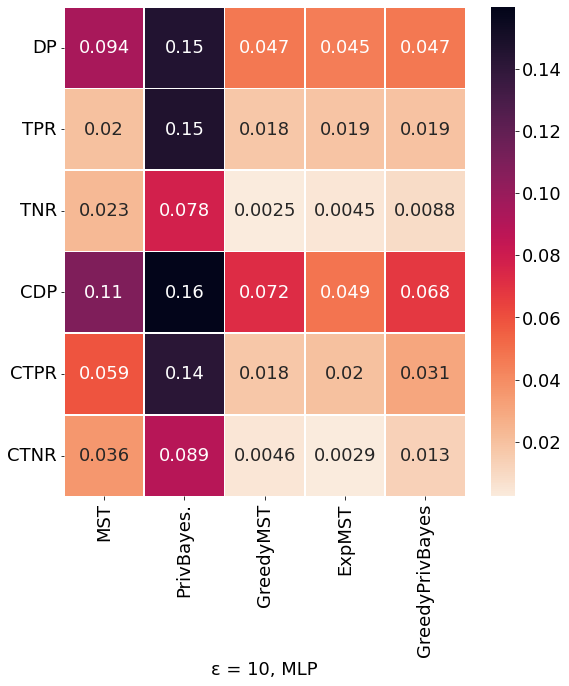

In [124]:
measures = ["DP", "TPR", "TNR", "CDP",
              "CTPR", "CTNR"]
mechanisms = ["MST", "PrivBayes.", "GreedyMST",
           "ExpMST", "GreedyPrivBayes"]

values = np.array([[np.mean(mst_demographic_parity_10), np.mean(privbayes_demographic_parity_10), np.mean(fair_greedy_mst_demographic_parity_10), np.mean(fair_opt_mst_demographic_parity_10), np.mean(fair_privbayes_demographic_parity_10) ],
                   [np.mean(mst_TPRBalance_10), np.mean(privbayes_TPRBalance_10), np.mean(fair_greedy_mst_TPRBalance_10), np.mean(fair_opt_mst_TPRBalance_10), np.mean(fair_privbayes_TPRBalance_10) ],
                    [np.mean(mst_TNRBalance_10), np.mean(privbayes_TNRBalance_10), np.mean(fair_greedy_mst_TNRBalance_10), np.mean(fair_opt_mst_TNRBalance_10), np.mean(fair_privbayes_TNRBalance_10) ],
                    [np.mean(mst_conditional_demographic_parity_10), np.mean(privbayes_conditional_demographic_parity_10), np.mean(fair_greedy_mst_conditional_demographic_parity_10), np.mean(fair_opt_mst_conditional_demographic_parity_10), np.mean(fair_privbayes_conditional_demographic_parity_10) ],
                   [np.mean(mst_conditional_TPRBalance_10), np.mean(privbayes_conditional_TPRBalance_10), np.mean(fair_greedy_mst_conditional_TPRBalance_10), np.mean(fair_opt_mst_conditional_TPRBalance_10), np.mean(fair_privbayes_conditional_TPRBalance_10) ],
                    [np.mean(mst_conditional_TNRBalance_10), np.mean(privbayes_conditional_TNRBalance_10), np.mean(fair_greedy_mst_conditional_TNRBalance_10), np.mean(fair_opt_mst_conditional_TNRBalance_10), np.mean(fair_privbayes_conditional_TNRBalance_10) ]])


plt.figure(figsize=(9, 9))
palette = sns.color_palette("Blues_d",n_colors=15)
palette.reverse()
ax = sns.heatmap(values,annot=True, linewidth=0.5, cmap = sns.cm.rocket_r)
ax.set_xlabel("ε = 10, MLP")
#ax.set_xticks(range(len(mechanisms)))
ax.set_xticklabels(mechanisms,rotation = 90)
#ax.set_yticks(range(len(measures)))
ax.set_yticklabels(measures,rotation = 0)
plt.savefig(artifactspath + 'MLP10.pdf', bbox_inches='tight')
plt.show()





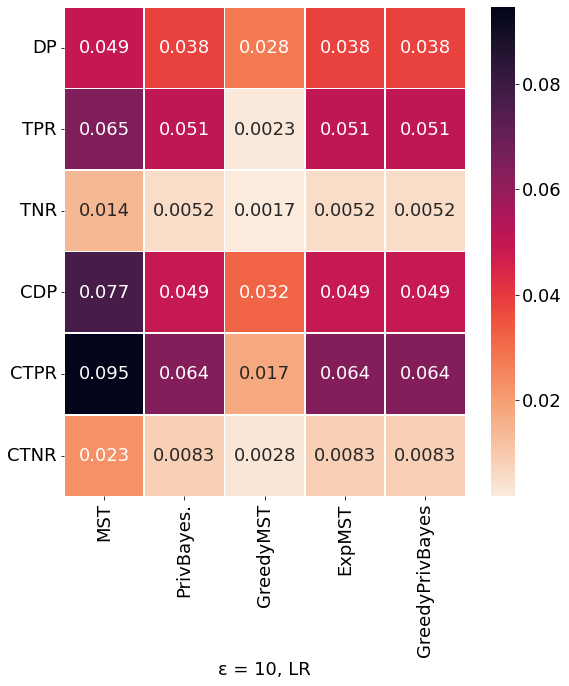

In [125]:
measures = ["DP", "TPR", "TNR", "CDP",
              "CTPR", "CTNR"]
mechanisms = ["MST", "PrivBayes.", "GreedyMST",
           "ExpMST", "GreedyPrivBayes"]

values = np.array([[np.mean(mst_demographic_parity_10LR), np.mean(privbayes_demographic_parity_10LR), np.mean(fair_greedy_mst_demographic_parity_10LR), np.mean(fair_opt_mst_demographic_parity_10LR), np.mean(fair_privbayes_demographic_parity_10LR) ],
                   [np.mean(mst_TPRBalance_10LR), np.mean(privbayes_TPRBalance_10LR), np.mean(fair_greedy_mst_TPRBalance_10LR), np.mean(fair_opt_mst_TPRBalance_10LR), np.mean(fair_privbayes_TPRBalance_10LR) ],
                    [np.mean(mst_TNRBalance_10LR), np.mean(privbayes_TNRBalance_10LR), np.mean(fair_greedy_mst_TNRBalance_10LR), np.mean(fair_opt_mst_TNRBalance_10LR), np.mean(fair_privbayes_TNRBalance_10LR) ],
                    [np.mean(mst_conditional_demographic_parity_10LR), np.mean(privbayes_conditional_demographic_parity_10LR), np.mean(fair_greedy_mst_conditional_demographic_parity_10LR), np.mean(fair_opt_mst_conditional_demographic_parity_10LR), np.mean(fair_privbayes_conditional_demographic_parity_10LR) ],
                   [np.mean(mst_conditional_TPRBalance_10LR), np.mean(privbayes_conditional_TPRBalance_10LR), np.mean(fair_greedy_mst_conditional_TPRBalance_10LR), np.mean(fair_opt_mst_conditional_TPRBalance_10LR), np.mean(fair_privbayes_conditional_TPRBalance_10LR) ],
                    [np.mean(mst_conditional_TNRBalance_10LR), np.mean(privbayes_conditional_TNRBalance_10LR), np.mean(fair_greedy_mst_conditional_TNRBalance_10LR), np.mean(fair_opt_mst_conditional_TNRBalance_10LR), np.mean(fair_privbayes_conditional_TNRBalance_10LR) ]])


plt.figure(figsize=(9, 9))
ax = sns.heatmap(values,annot=True, linewidth=0.5, cmap = sns.cm.rocket_r)
ax.set_xlabel("ε = 10, LR")
#ax.set_xticks(range(len(mechanisms)))
ax.set_xticklabels(mechanisms,rotation = 90)
#ax.set_yticks(range(len(measures)))
ax.set_yticklabels(measures,rotation = 0)
plt.savefig(artifactspath + 'LR10.pdf', bbox_inches='tight')
plt.show()





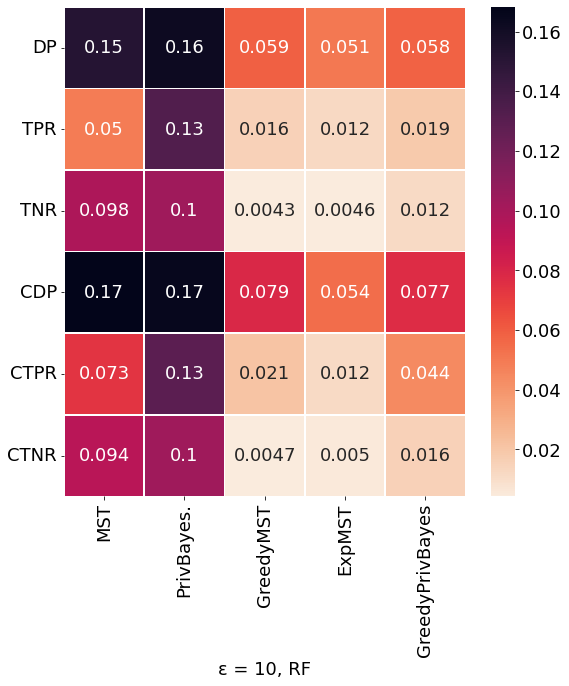

In [126]:
measures = ["DP", "TPR", "TNR", "CDP",
              "CTPR", "CTNR"]
mechanisms = ["MST", "PrivBayes.", "GreedyMST",
           "ExpMST", "GreedyPrivBayes"]

values = np.array([[np.mean(mst_demographic_parity_10RF), np.mean(privbayes_demographic_parity_10RF), np.mean(fair_greedy_mst_demographic_parity_10RF), np.mean(fair_opt_mst_demographic_parity_10RF), np.mean(fair_privbayes_demographic_parity_10RF) ],
                   [np.mean(mst_TPRBalance_10RF), np.mean(privbayes_TPRBalance_10RF), np.mean(fair_greedy_mst_TPRBalance_10RF), np.mean(fair_opt_mst_TPRBalance_10RF), np.mean(fair_privbayes_TPRBalance_10RF) ],
                    [np.mean(mst_TNRBalance_10RF), np.mean(privbayes_TNRBalance_10RF), np.mean(fair_greedy_mst_TNRBalance_10RF), np.mean(fair_opt_mst_TNRBalance_10RF), np.mean(fair_privbayes_TNRBalance_10RF) ],
                    [np.mean(mst_conditional_demographic_parity_10RF), np.mean(privbayes_conditional_demographic_parity_10RF), np.mean(fair_greedy_mst_conditional_demographic_parity_10RF), np.mean(fair_opt_mst_conditional_demographic_parity_10RF), np.mean(fair_privbayes_conditional_demographic_parity_10RF) ],
                   [np.mean(mst_conditional_TPRBalance_10RF), np.mean(privbayes_conditional_TPRBalance_10RF), np.mean(fair_greedy_mst_conditional_TPRBalance_10RF), np.mean(fair_opt_mst_conditional_TPRBalance_10RF), np.mean(fair_privbayes_conditional_TPRBalance_10RF) ],
                    [np.mean(mst_conditional_TNRBalance_10RF), np.mean(privbayes_conditional_TNRBalance_10RF), np.mean(fair_greedy_mst_conditional_TNRBalance_10RF), np.mean(fair_opt_mst_conditional_TNRBalance_10RF), np.mean(fair_privbayes_conditional_TNRBalance_10RF) ]])


plt.figure(figsize=(9, 9))
ax = sns.heatmap(values,annot=True, linewidth=0.5, cmap = sns.cm.rocket_r)
#ax.set_xticks(range(len(mechanisms)))
ax.set_xticklabels(mechanisms,rotation = 90)
ax.set_xlabel("ε = 10, RF")
#ax.set_yticks(range(len(measures)))
ax.set_yticklabels(measures,rotation = 0)
plt.savefig(artifactspath + 'RF10.pdf', bbox_inches='tight')
plt.show()





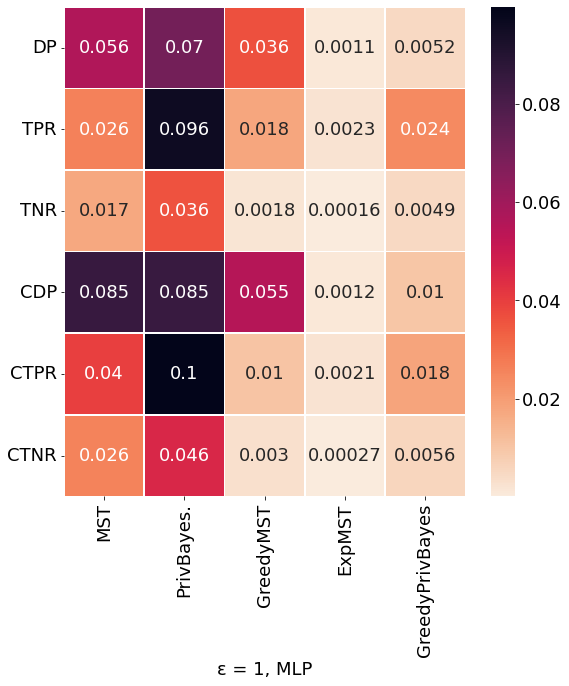

In [127]:
measures = ["DP", "TPR", "TNR", "CDP",
              "CTPR", "CTNR"]
mechanisms = ["MST", "PrivBayes.", "GreedyMST",
           "ExpMST", "GreedyPrivBayes"]

values = np.array([[np.mean(mst_demographic_parity_1), np.mean(privbayes_demographic_parity_1), np.mean(fair_greedy_mst_demographic_parity_1), np.mean(fair_opt_mst_demographic_parity_1), np.mean(fair_privbayes_demographic_parity_1) ],
                   [np.mean(mst_TPRBalance_1), np.mean(privbayes_TPRBalance_1), np.mean(fair_greedy_mst_TPRBalance_1), np.mean(fair_opt_mst_TPRBalance_1), np.mean(fair_privbayes_TPRBalance_1) ],
                    [np.mean(mst_TNRBalance_1), np.mean(privbayes_TNRBalance_1), np.mean(fair_greedy_mst_TNRBalance_1), np.mean(fair_opt_mst_TNRBalance_1), np.mean(fair_privbayes_TNRBalance_1) ],
                    [np.mean(mst_conditional_demographic_parity_1), np.mean(privbayes_conditional_demographic_parity_1), np.mean(fair_greedy_mst_conditional_demographic_parity_1), np.mean(fair_opt_mst_conditional_demographic_parity_1), np.mean(fair_privbayes_conditional_demographic_parity_1) ],
                   [np.mean(mst_conditional_TPRBalance_1), np.mean(privbayes_conditional_TPRBalance_1), np.mean(fair_greedy_mst_conditional_TPRBalance_1), np.mean(fair_opt_mst_conditional_TPRBalance_1), np.mean(fair_privbayes_conditional_TPRBalance_1) ],
                    [np.mean(mst_conditional_TNRBalance_1), np.mean(privbayes_conditional_TNRBalance_1), np.mean(fair_greedy_mst_conditional_TNRBalance_1), np.mean(fair_opt_mst_conditional_TNRBalance_1), np.mean(fair_privbayes_conditional_TNRBalance_1) ]])


plt.figure(figsize=(9, 9))
palette = sns.color_palette("Blues_d",n_colors=15)
palette.reverse()
ax = sns.heatmap(values,annot=True, linewidth=0.5, cmap = sns.cm.rocket_r)
ax.set_xlabel("ε = 1, MLP")
#ax.set_xticks(range(len(mechanisms)))
ax.set_xticklabels(mechanisms,rotation = 90)
#ax.set_yticks(range(len(measures)))
ax.set_yticklabels(measures,rotation = 0)
plt.savefig(artifactspath + 'MLP1.pdf', bbox_inches='tight')
plt.show()





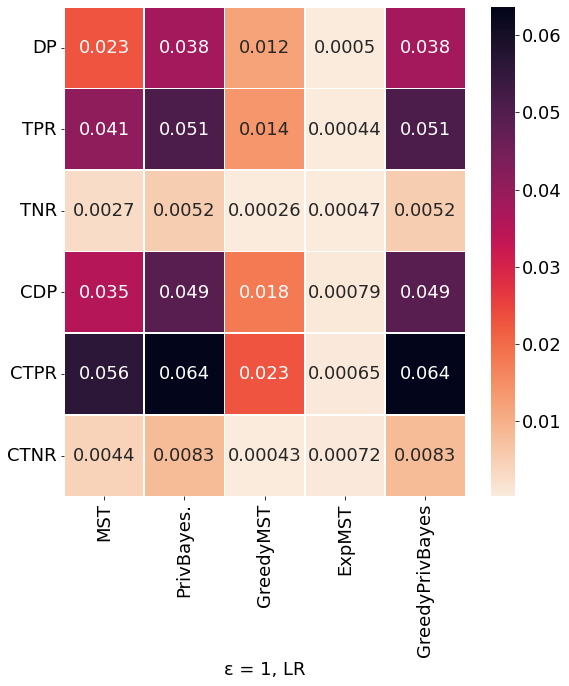

In [128]:
measures = ["DP", "TPR", "TNR", "CDP",
              "CTPR", "CTNR"]
mechanisms = ["MST", "PrivBayes.", "GreedyMST",
           "ExpMST", "GreedyPrivBayes"]

values = np.array([[np.mean(mst_demographic_parity_1LR), np.mean(privbayes_demographic_parity_1LR), np.mean(fair_greedy_mst_demographic_parity_1LR), np.mean(fair_opt_mst_demographic_parity_1LR), np.mean(fair_privbayes_demographic_parity_1LR) ],
                   [np.mean(mst_TPRBalance_1LR), np.mean(privbayes_TPRBalance_1LR), np.mean(fair_greedy_mst_TPRBalance_1LR), np.mean(fair_opt_mst_TPRBalance_1LR), np.mean(fair_privbayes_TPRBalance_1LR) ],
                    [np.mean(mst_TNRBalance_1LR), np.mean(privbayes_TNRBalance_1LR), np.mean(fair_greedy_mst_TNRBalance_1LR), np.mean(fair_opt_mst_TNRBalance_1LR), np.mean(fair_privbayes_TNRBalance_1LR) ],
                    [np.mean(mst_conditional_demographic_parity_1LR), np.mean(privbayes_conditional_demographic_parity_1LR), np.mean(fair_greedy_mst_conditional_demographic_parity_1LR), np.mean(fair_opt_mst_conditional_demographic_parity_1LR), np.mean(fair_privbayes_conditional_demographic_parity_1LR) ],
                   [np.mean(mst_conditional_TPRBalance_1LR), np.mean(privbayes_conditional_TPRBalance_1LR), np.mean(fair_greedy_mst_conditional_TPRBalance_1LR), np.mean(fair_opt_mst_conditional_TPRBalance_1LR), np.mean(fair_privbayes_conditional_TPRBalance_1LR) ],
                    [np.mean(mst_conditional_TNRBalance_1LR), np.mean(privbayes_conditional_TNRBalance_1LR), np.mean(fair_greedy_mst_conditional_TNRBalance_1LR), np.mean(fair_opt_mst_conditional_TNRBalance_1LR), np.mean(fair_privbayes_conditional_TNRBalance_1LR) ]])


plt.figure(figsize=(9, 9))
ax = sns.heatmap(values,annot=True, linewidth=0.5, cmap = sns.cm.rocket_r)
ax.set_xlabel("ε = 1, LR")
#ax.set_xticks(range(len(mechanisms)))
ax.set_xticklabels(mechanisms,rotation = 90)
#ax.set_yticks(range(len(measures)))
ax.set_yticklabels(measures,rotation = 0)
plt.savefig(artifactspath + 'LR1.pdf', bbox_inches='tight')
plt.show()





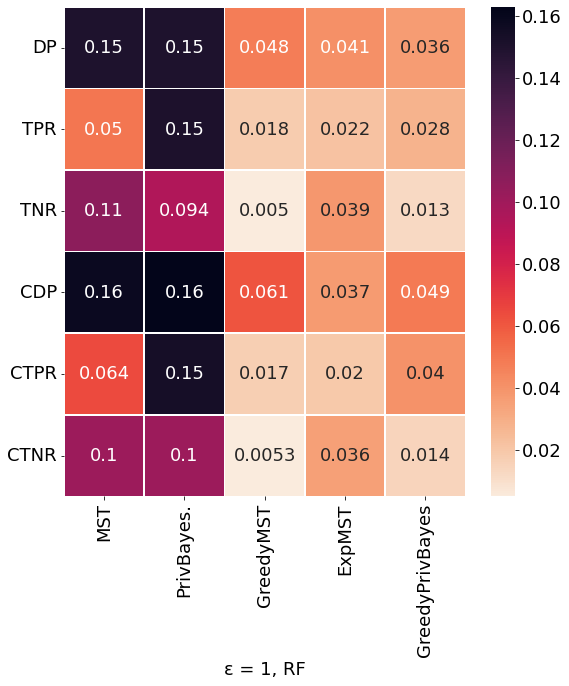

In [129]:
measures = ["DP", "TPR", "TNR", "CDP",
              "CTPR", "CTNR"]
mechanisms = ["MST", "PrivBayes.", "GreedyMST",
           "ExpMST", "GreedyPrivBayes"]

values = np.array([[np.mean(mst_demographic_parity_1RF), np.mean(privbayes_demographic_parity_1RF), np.mean(fair_greedy_mst_demographic_parity_1RF), np.mean(fair_opt_mst_demographic_parity_1RF), np.mean(fair_privbayes_demographic_parity_1RF) ],
                   [np.mean(mst_TPRBalance_1RF), np.mean(privbayes_TPRBalance_1RF), np.mean(fair_greedy_mst_TPRBalance_1RF), np.mean(fair_opt_mst_TPRBalance_1RF), np.mean(fair_privbayes_TPRBalance_1RF) ],
                    [np.mean(mst_TNRBalance_1RF), np.mean(privbayes_TNRBalance_1RF), np.mean(fair_greedy_mst_TNRBalance_1RF), np.mean(fair_opt_mst_TNRBalance_1RF), np.mean(fair_privbayes_TNRBalance_1RF) ],
                    [np.mean(mst_conditional_demographic_parity_1RF), np.mean(privbayes_conditional_demographic_parity_1RF), np.mean(fair_greedy_mst_conditional_demographic_parity_1RF), np.mean(fair_opt_mst_conditional_demographic_parity_1RF), np.mean(fair_privbayes_conditional_demographic_parity_1RF) ],
                   [np.mean(mst_conditional_TPRBalance_1RF), np.mean(privbayes_conditional_TPRBalance_1RF), np.mean(fair_greedy_mst_conditional_TPRBalance_1RF), np.mean(fair_opt_mst_conditional_TPRBalance_1RF), np.mean(fair_privbayes_conditional_TPRBalance_1RF) ],
                    [np.mean(mst_conditional_TNRBalance_1RF), np.mean(privbayes_conditional_TNRBalance_1RF), np.mean(fair_greedy_mst_conditional_TNRBalance_1RF), np.mean(fair_opt_mst_conditional_TNRBalance_1RF), np.mean(fair_privbayes_conditional_TNRBalance_1RF) ]])


plt.figure(figsize=(9, 9))
ax = sns.heatmap(values,annot=True, linewidth=0.5, cmap = sns.cm.rocket_r)
#ax.set_xticks(range(len(mechanisms)))
ax.set_xticklabels(mechanisms,rotation = 90)
ax.set_xlabel("ε = 1, RF")
#ax.set_yticks(range(len(measures)))
ax.set_yticklabels(measures,rotation = 0)
plt.savefig(artifactspath + 'RF1.pdf', bbox_inches='tight')
plt.show()





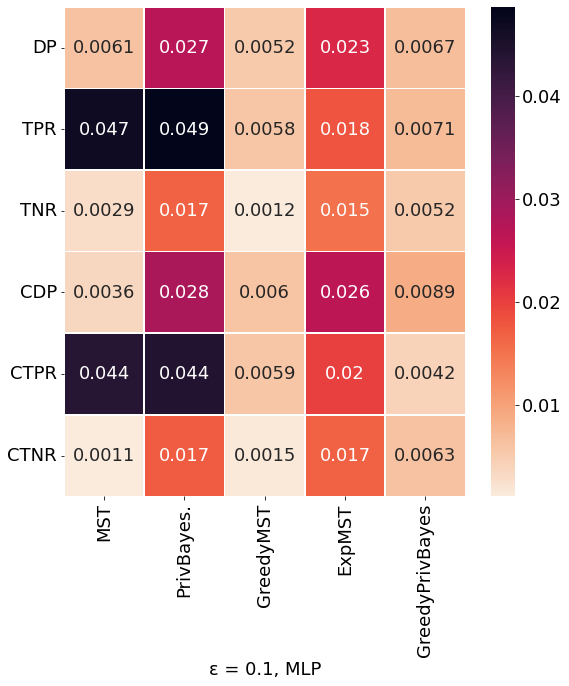

In [130]:
measures = ["DP", "TPR", "TNR", "CDP",
              "CTPR", "CTNR"]
mechanisms = ["MST", "PrivBayes.", "GreedyMST",
           "ExpMST", "GreedyPrivBayes"]

values = np.array([[np.mean(mst_demographic_parity_01), np.mean(privbayes_demographic_parity_01), np.mean(fair_greedy_mst_demographic_parity_01), np.mean(fair_opt_mst_demographic_parity_01), np.mean(fair_privbayes_demographic_parity_01) ],
                   [np.mean(mst_TPRBalance_01), np.mean(privbayes_TPRBalance_01), np.mean(fair_greedy_mst_TPRBalance_01), np.mean(fair_opt_mst_TPRBalance_01), np.mean(fair_privbayes_TPRBalance_01) ],
                    [np.mean(mst_TNRBalance_01), np.mean(privbayes_TNRBalance_01), np.mean(fair_greedy_mst_TNRBalance_01), np.mean(fair_opt_mst_TNRBalance_01), np.mean(fair_privbayes_TNRBalance_01) ],
                    [np.mean(mst_conditional_demographic_parity_01), np.mean(privbayes_conditional_demographic_parity_01), np.mean(fair_greedy_mst_conditional_demographic_parity_01), np.mean(fair_opt_mst_conditional_demographic_parity_01), np.mean(fair_privbayes_conditional_demographic_parity_01) ],
                   [np.mean(mst_conditional_TPRBalance_01), np.mean(privbayes_conditional_TPRBalance_01), np.mean(fair_greedy_mst_conditional_TPRBalance_01), np.mean(fair_opt_mst_conditional_TPRBalance_01), np.mean(fair_privbayes_conditional_TPRBalance_01) ],
                    [np.mean(mst_conditional_TNRBalance_01), np.mean(privbayes_conditional_TNRBalance_01), np.mean(fair_greedy_mst_conditional_TNRBalance_01), np.mean(fair_opt_mst_conditional_TNRBalance_01), np.mean(fair_privbayes_conditional_TNRBalance_01) ]])


plt.figure(figsize=(9, 9))
palette = sns.color_palette("Blues_d",n_colors=15)
palette.reverse()
ax = sns.heatmap(values,annot=True, linewidth=0.5, cmap = sns.cm.rocket_r)
ax.set_xlabel("ε = 0.1, MLP")
#ax.set_xticks(range(len(mechanisms)))
ax.set_xticklabels(mechanisms,rotation = 90)
#ax.set_yticks(range(len(measures)))
ax.set_yticklabels(measures,rotation = 0)
plt.savefig(artifactspath + 'MLP01.pdf', bbox_inches='tight')
plt.show()





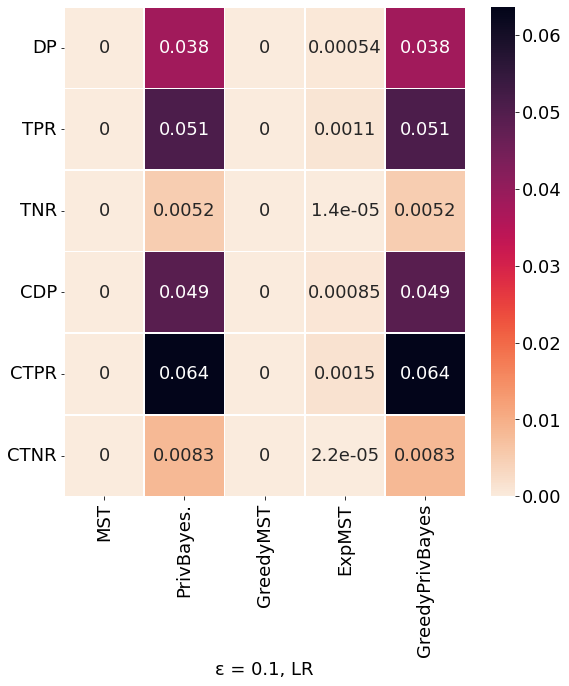

In [131]:
measures = ["DP", "TPR", "TNR", "CDP",
              "CTPR", "CTNR"]
mechanisms = ["MST", "PrivBayes.", "GreedyMST",
           "ExpMST", "GreedyPrivBayes"]

values = np.array([[np.mean(mst_demographic_parity_01LR), np.mean(privbayes_demographic_parity_01LR), np.mean(fair_greedy_mst_demographic_parity_01LR), np.mean(fair_opt_mst_demographic_parity_01LR), np.mean(fair_privbayes_demographic_parity_01LR) ],
                   [np.mean(mst_TPRBalance_01LR), np.mean(privbayes_TPRBalance_01LR), np.mean(fair_greedy_mst_TPRBalance_01LR), np.mean(fair_opt_mst_TPRBalance_01LR), np.mean(fair_privbayes_TPRBalance_01LR) ],
                    [np.mean(mst_TNRBalance_01LR), np.mean(privbayes_TNRBalance_01LR), np.mean(fair_greedy_mst_TNRBalance_01LR), np.mean(fair_opt_mst_TNRBalance_01LR), np.mean(fair_privbayes_TNRBalance_01LR) ],
                    [np.mean(mst_conditional_demographic_parity_01LR), np.mean(privbayes_conditional_demographic_parity_01LR), np.mean(fair_greedy_mst_conditional_demographic_parity_01LR), np.mean(fair_opt_mst_conditional_demographic_parity_01LR), np.mean(fair_privbayes_conditional_demographic_parity_01LR) ],
                   [np.mean(mst_conditional_TPRBalance_01LR), np.mean(privbayes_conditional_TPRBalance_01LR), np.mean(fair_greedy_mst_conditional_TPRBalance_01LR), np.mean(fair_opt_mst_conditional_TPRBalance_01LR), np.mean(fair_privbayes_conditional_TPRBalance_01LR) ],
                    [np.mean(mst_conditional_TNRBalance_01LR), np.mean(privbayes_conditional_TNRBalance_01LR), np.mean(fair_greedy_mst_conditional_TNRBalance_01LR), np.mean(fair_opt_mst_conditional_TNRBalance_01LR), np.mean(fair_privbayes_conditional_TNRBalance_01LR) ]])


plt.figure(figsize=(9, 9))
ax = sns.heatmap(values,annot=True, linewidth=0.5, cmap = sns.cm.rocket_r)
ax.set_xlabel("ε = 0.1, LR")
#ax.set_xticks(range(len(mechanisms)))
ax.set_xticklabels(mechanisms,rotation = 90)
#ax.set_yticks(range(len(measures)))
ax.set_yticklabels(measures,rotation = 0)
plt.savefig(artifactspath + 'LR01.pdf', bbox_inches='tight')
plt.show()





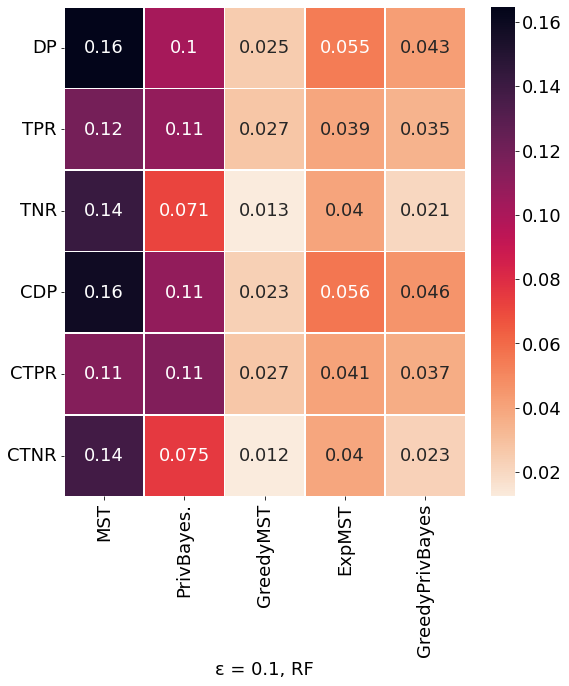

In [132]:
measures = ["DP", "TPR", "TNR", "CDP",
              "CTPR", "CTNR"]
mechanisms = ["MST", "PrivBayes.", "GreedyMST",
           "ExpMST", "GreedyPrivBayes"]

values = np.array([[np.mean(mst_demographic_parity_01RF), np.mean(privbayes_demographic_parity_01RF), np.mean(fair_greedy_mst_demographic_parity_01RF), np.mean(fair_opt_mst_demographic_parity_01RF), np.mean(fair_privbayes_demographic_parity_01RF) ],
                   [np.mean(mst_TPRBalance_01RF), np.mean(privbayes_TPRBalance_01RF), np.mean(fair_greedy_mst_TPRBalance_01RF), np.mean(fair_opt_mst_TPRBalance_01RF), np.mean(fair_privbayes_TPRBalance_01RF) ],
                    [np.mean(mst_TNRBalance_01RF), np.mean(privbayes_TNRBalance_01RF), np.mean(fair_greedy_mst_TNRBalance_01RF), np.mean(fair_opt_mst_TNRBalance_01RF), np.mean(fair_privbayes_TNRBalance_01RF) ],
                    [np.mean(mst_conditional_demographic_parity_01RF), np.mean(privbayes_conditional_demographic_parity_01RF), np.mean(fair_greedy_mst_conditional_demographic_parity_01RF), np.mean(fair_opt_mst_conditional_demographic_parity_01RF), np.mean(fair_privbayes_conditional_demographic_parity_01RF) ],
                   [np.mean(mst_conditional_TPRBalance_01RF), np.mean(privbayes_conditional_TPRBalance_01RF), np.mean(fair_greedy_mst_conditional_TPRBalance_01RF), np.mean(fair_opt_mst_conditional_TPRBalance_01RF), np.mean(fair_privbayes_conditional_TPRBalance_01RF) ],
                    [np.mean(mst_conditional_TNRBalance_01RF), np.mean(privbayes_conditional_TNRBalance_01RF), np.mean(fair_greedy_mst_conditional_TNRBalance_01RF), np.mean(fair_opt_mst_conditional_TNRBalance_01RF), np.mean(fair_privbayes_conditional_TNRBalance_01RF) ]])


plt.figure(figsize=(9, 9))
ax = sns.heatmap(values,annot=True, linewidth=0.5, cmap = sns.cm.rocket_r)
#ax.set_xticks(range(len(mechanisms)))
ax.set_xticklabels(mechanisms,rotation = 90)
ax.set_xlabel("ε = 0.1, RF")
#ax.set_yticks(range(len(measures)))
ax.set_yticklabels(measures,rotation = 0)
plt.savefig(artifactspath + 'RF01.pdf', bbox_inches='tight')
plt.show()





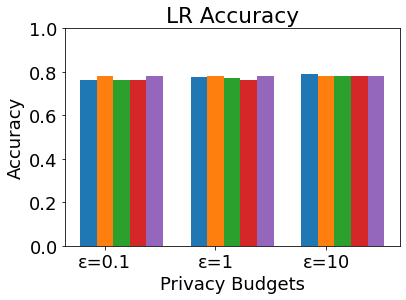

In [133]:
N = 3
workload_len = len(list(itertools.combinations(data.domain, 1)))
ind = np.arange(N) 
width = 0.15
#plt.yscale("log")
xvals = [np.mean(mst_accuracy_01LR), np.mean(mst_accuracy_1LR), np.mean(mst_accuracy_10LR)]
bar1 = plt.bar(ind, xvals, width)

yvals = [np.mean(privbayes_accuracy_01LR), np.mean(privbayes_accuracy_1LR), np.mean(privbayes_accuracy_10LR)]
bar2 = plt.bar(ind+width, yvals, width)
  
zvals = [np.mean(fair_greedy_mst_accuracy_01LR), np.mean(fair_greedy_mst_accuracy_1LR), np.mean(fair_greedy_mst_accuracy_10LR)]
bar3 = plt.bar(ind+width*2, zvals, width)

xxvals = [np.mean(fair_opt_mst_accuracy_01LR), np.mean(fair_opt_mst_accuracy_1LR), np.mean(fair_opt_mst_accuracy_10LR)]
bar4 = plt.bar(ind+width*3, xxvals, width)

xyvals = [np.mean(fair_privbayes_accuracy_01LR), np.mean(fair_privbayes_accuracy_1LR), np.mean(fair_privbayes_accuracy_10LR)]
bar5 = plt.bar(ind+width*4, xyvals, width)


plt.xlabel("Privacy Budgets")
plt.ylabel('Accuracy')
plt.title("LR Accuracy")

plt.ylim([0, 1])
plt.xticks(ind+width,['ε=0.1','ε=1','ε=10'])
#plt.legend( (bar1, bar2, bar3,bar4,bar5), ('MST','Privbayes', 'GreedyMST', 'ExpMST','GreedyPrivbayes'), fontsize = 10 )
plt.savefig(artifactspath + 'ACCLR.pdf', bbox_inches='tight')

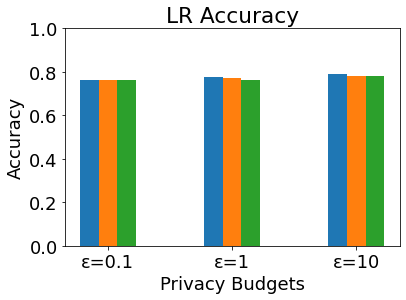

In [134]:
N = 3
workload_len = len(list(itertools.combinations(data.domain, 1)))
ind = np.arange(N) 
width = 0.15
#plt.yscale("log")
xvals = [np.mean(mst_accuracy_01LR), np.mean(mst_accuracy_1LR), np.mean(mst_accuracy_10LR)]
bar1 = plt.bar(ind, xvals, width)

  
zvals = [np.mean(fair_greedy_mst_accuracy_01LR), np.mean(fair_greedy_mst_accuracy_1LR), np.mean(fair_greedy_mst_accuracy_10LR)]
bar3 = plt.bar(ind+width*1, zvals, width)

xxvals = [np.mean(fair_opt_mst_accuracy_01LR), np.mean(fair_opt_mst_accuracy_1LR), np.mean(fair_opt_mst_accuracy_10LR)]
bar4 = plt.bar(ind+width*2, xxvals, width)



plt.xlabel("Privacy Budgets")
plt.ylabel('Accuracy')
plt.title("LR Accuracy")

plt.ylim([0, 1])
plt.xticks(ind+width,['ε=0.1','ε=1','ε=10'])
#plt.legend( (bar1, bar2, bar3,bar4,bar5), ('MST','Privbayes', 'GreedyMST', 'ExpMST','GreedyPrivbayes'), fontsize = 10 )
plt.savefig(artifactspath + 'ACCLRMST.pdf', bbox_inches='tight')

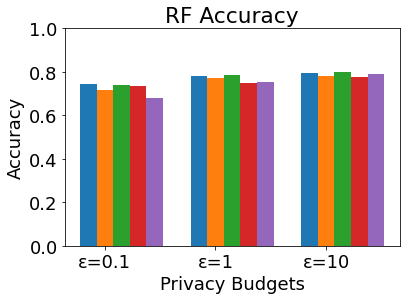

In [135]:
N = 3
workload_len = len(list(itertools.combinations(data.domain, 1)))
ind = np.arange(N) 
width = 0.15
#plt.yscale("log")
xvals = [np.mean(mst_accuracy_01RF), np.mean(mst_accuracy_1RF), np.mean(mst_accuracy_10RF)]
bar1 = plt.bar(ind, xvals, width)

yvals = [np.mean(privbayes_accuracy_01RF), np.mean(privbayes_accuracy_1RF), np.mean(privbayes_accuracy_10RF)]
bar2 = plt.bar(ind+width, yvals, width)
  
zvals = [np.mean(fair_greedy_mst_accuracy_01RF), np.mean(fair_greedy_mst_accuracy_1RF), np.mean(fair_greedy_mst_accuracy_10RF)]
bar3 = plt.bar(ind+width*2, zvals, width)

xxvals = [np.mean(fair_opt_mst_accuracy_01RF), np.mean(fair_opt_mst_accuracy_1RF), np.mean(fair_opt_mst_accuracy_10RF)]
bar4 = plt.bar(ind+width*3, xxvals, width)

xyvals = [np.mean(fair_privbayes_accuracy_01RF), np.mean(fair_privbayes_accuracy_1RF), np.mean(fair_privbayes_accuracy_10RF)]
bar5 = plt.bar(ind+width*4, xyvals, width)


plt.xlabel("Privacy Budgets")
plt.ylabel('Accuracy')
plt.title("RF Accuracy")

plt.ylim([0, 1])
plt.xticks(ind+width,['ε=0.1','ε=1','ε=10'])
#plt.legend( (bar1, bar2, bar3,bar4,bar5), ('MST','Privbayes', 'GreedyMST', 'ExpMST','GreedyPrivbayes'), fontsize = 10 )
plt.savefig(artifactspath + 'ACCRF.pdf', bbox_inches='tight')

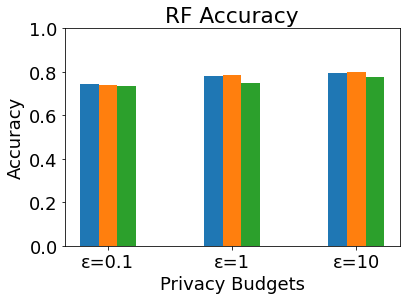

In [136]:
N = 3
workload_len = len(list(itertools.combinations(data.domain, 1)))
ind = np.arange(N) 
width = 0.15
#plt.yscale("log")
xvals = [np.mean(mst_accuracy_01RF), np.mean(mst_accuracy_1RF), np.mean(mst_accuracy_10RF)]
bar1 = plt.bar(ind, xvals, width)

zvals = [np.mean(fair_greedy_mst_accuracy_01RF), np.mean(fair_greedy_mst_accuracy_1RF), np.mean(fair_greedy_mst_accuracy_10RF)]
bar3 = plt.bar(ind+width*1, zvals, width)

xxvals = [np.mean(fair_opt_mst_accuracy_01RF), np.mean(fair_opt_mst_accuracy_1RF), np.mean(fair_opt_mst_accuracy_10RF)]
bar4 = plt.bar(ind+width*2, xxvals, width)


plt.xlabel("Privacy Budgets")
plt.ylabel('Accuracy')
plt.title("RF Accuracy")

plt.ylim([0, 1])
plt.xticks(ind+width,['ε=0.1','ε=1','ε=10'])
#plt.legend( (bar1, bar2, bar3,bar4,bar5), ('MST','Privbayes', 'GreedyMST', 'ExpMST','GreedyPrivbayes'), fontsize = 10 )
plt.savefig(artifactspath + 'ACCRFMST.pdf', bbox_inches='tight')

In [137]:
print(np.mean(fair_privbayes_accuracy_01RF)-np.mean(privbayes_accuracy_01RF))
print(np.mean(fair_privbayes_accuracy_1RF)-np.mean(privbayes_accuracy_1RF))
print(np.mean(fair_privbayes_accuracy_10RF)-np.mean(privbayes_accuracy_10RF))

-0.03617992711191187
-0.019616313828262566
0.0068793251709593495


In [138]:
print(np.mean(fair_privbayes_accuracy_01)-np.mean(privbayes_accuracy_01))
print(np.mean(fair_privbayes_accuracy_1)-np.mean(privbayes_accuracy_1))
print(np.mean(fair_privbayes_accuracy_10)-np.mean(privbayes_accuracy_10))

-0.11291305422782894
-0.01471274495124808
-0.005378568172454745


In [139]:
print(np.mean(fair_privbayes_accuracy_01)-np.mean(privbayes_accuracy_01))
print(np.mean(fair_privbayes_accuracy_1)-np.mean(privbayes_accuracy_1))
print(np.mean(fair_privbayes_accuracy_10)-np.mean(privbayes_accuracy_10))

-0.11291305422782894
-0.01471274495124808
-0.005378568172454745
